# Unit Cell Geometry Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0
from tqdm import tqdm
from shapely.geometry import Polygon, Point
from shapely.affinity import translate, rotate
import matplotlib.colors
import time

def create_regular_polygon_with_radius(n, a, is_inverted=False, x_center=0, y_center=0, rotation_angle=0):
    """
    Creates an n-sided regular polygon centered at (x_center, y_center) with all points on a circle of radius a.
    
    Parameters:
    n (int): Number of sides of the polygon.
    a (float): Radius of the circle on which the vertices lie.
    
    Returns:
    numpy.ndarray: Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    if (n % 2) != 0:
        angles += np.pi/2
    else:
        angles += np.pi/n
    if is_inverted:
        angles += np.pi
    angles += rotation_angle
    x = x_center + a * np.cos(angles)
    y = y_center + a * np.sin(angles)
    
    vertices = np.column_stack((x, y))
    return vertices

def create_ellipse(a, b, n=1200, x_center=0, y_center=0):
    """
    Creates an n-sided regular polygon centered at (x_center, y_center) with all points on a circle of radius a.
    
    Parameters:
    n (int): Number of sides of the polygon.
    a (float): Radius of the circle on which the vertices lie.
    
    Returns:
    numpy.ndarray: Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    x = x_center + a * np.cos(angles)
    y = y_center + b * np.sin(angles)
    
    vertices = np.column_stack((x, y))
    return vertices

def create_regular_polygon_with_side_length(n, a, is_inverted=False, x_center=0, y_center=0, rotation_angle=0):
    """
    Creates an n-sided regular polygon centered at (x_center, y_center) with a specified side length.
    
    Parameters:
    n (int): Number of sides of the polygon.
    a (float): Length of each side of the polygon.
    
    Returns:
    numpy.ndarray: Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex.
    """
    R = a / (2 * np.sin(np.pi / n))  # Calculate the circumradius
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    if (n % 2) != 0:
        angles += np.pi/2
    else:
        angles += np.pi/n
    if is_inverted:
        angles += np.pi
    angles += rotation_angle
    x = x_center + R * np.cos(angles)
    y = y_center + R * np.sin(angles)
    
    vertices = np.column_stack((x, y))
    return vertices

def rotate_polygon(vertices, angle, x_center=0, y_center=0):
    """
    Rotates the polygon by the specified angle about the specified center.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex.
    angle (float): Angle of rotation in radians.
    x_center (float): x-coordinate of the center of rotation.
    y_center (float): y-coordinate of the center of rotation.
    
    Returns:
    numpy.ndarray: Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex after rotation.
    """
    x = vertices[:, 0]
    y = vertices[:, 1]
    
    x_rot = x_center + np.cos(angle) * (x - x_center) - np.sin(angle) * (y - y_center)
    y_rot = y_center + np.sin(angle) * (x - x_center) + np.cos(angle) * (y - y_center)
    
    vertices_rot = np.column_stack((x_rot, y_rot))
    return vertices_rot

def plot_polygon(vertices):
    """
    Plots the polygon given its vertices.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 2) with each row representing the (x, y) coordinates of a vertex.
    """
    # Close the polygon by appending the first vertex to the end
    vertices = np.vstack([vertices, vertices[0]])
    
    plt.figure(figsize=(6, 6))
    plt.plot(vertices[:, 0], vertices[:, 1], 'o-', label=f'{len(vertices)-1}-sided Polygon')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Regular Polygon with Specified Side Length')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def generate_unit_cell_rectangle(a):
    vertices = np.array([(-a/2, -np.sqrt(3)*a/2), (-a/2,  np.sqrt(3)*a/2), 
                         ( a/2,  np.sqrt(3)*a/2), ( a/2, -np.sqrt(3)*a/2),
                         (-a/2, -np.sqrt(3)*a/2)])
    return vertices

def generate_unit_cell_rhombus(a):
    vertices = np.array([(-a, 0), (0, 0), (a/2, np.sqrt(3)*a/2), (-a/2, np.sqrt(3)*a/2), (-a, 0)])
    return vertices

def generate_unit_cell_hexagon(a):
    vertices = np.array([(-a/2, -np.sqrt(1/3)*a/2), (-a/2,  np.sqrt(1/3)*a/2), (0,  np.sqrt(1/3)*a), 
                         ( a/2,  np.sqrt(1/3)*a/2), ( a/2, -np.sqrt(1/3)*a/2), (0, -np.sqrt(1/3)*a),
                         (-a/2, -np.sqrt(1/3)*a/2)])
    return vertices

def generate_mesh_inside_polygon(vertices, Nx=100, Ny=100):
    """
    Generates a mesh of Nx-by-Ny points inside a polygon given by its vertices.
    
    Parameters
    ----------
    vertices : array-like of shape (N, 2)
        Vertices of the polygon (first and last are the same). Example:
        [
            [x0, y0],
            [x1, y1],
            ...
            [x0, y0]
        ]
    Nx : int, optional
        Number of points in the x-direction. Default is 10.
    Ny : int, optional
        Number of points in the y-direction. Default is 10.

    Returns
    -------
    mesh_points : ndarray of shape (M, 2)
        Array of points strictly inside the polygon.
    """
    # Convert vertices to a NumPy array (if not already).
    verts = np.array(vertices)
    if len(verts.shape) != 2 or verts.shape[1] != 2:
        raise ValueError("Vertices must be of shape (N, 2).")
    if not np.allclose(verts[0], verts[-1]):
        raise ValueError("First and last vertices should coincide (closed polygon).")

    # Create a Shapely Polygon object
    poly = Polygon(verts)

    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = poly.bounds

    # Generate Nx and Ny coordinates evenly spaced in bounding box
    x_coords = np.linspace(min_x, max_x, Nx, endpoint=True)
    y_coords = np.linspace(min_y, max_y, Ny, endpoint=True)

    # Store valid inside points
    inside_points = []

    # Test each point in the grid
    for x in x_coords:
        for y in y_coords:
            point = Point(x, y)
            if poly.covers(point):
                inside_points.append([x, y])

    return np.array(inside_points)

# Initialize Lattice Parameters
def initialize_rhombus_lattice_parameters(a, ng):
    a = a       # Lattice constant in meters
    c0 = c      # Speed of light in vacuum in m/s
    ng = ng     # Defines Number of Plane Waves used
    
    # Lattice vectors
    A1 = a * np.array([1, 0])
    A2 = (a / 2) * np.array([1, np.sqrt(3)])
    
    # Reciprocal lattice vectors
    B1 = (2 * np.pi / a) * np.array([1, 1/np.sqrt(3)])
    B2 = (2 * np.pi / a) * np.array([1, -1/np.sqrt(3)])
    
    return a, c0, ng, A1, A2, B1, B2

def initialize_supercell_parameters(a, ng):
    a = a       # Lattice constant in meters
    c0 = c      # Speed of light in vacuum in m/s
    ng = ng     # Defines Number of Plane Waves used
    
    # Lattice vectors
    A1 = 2 * a * np.array([1, 0])
    A2 = 2 * (a / 2) * np.array([1, np.sqrt(3)]) 
    
    # Reciprocal lattice vectors
    B1 = (np.pi / a) * np.array([1, 1/np.sqrt(3)])
    B2 = (np.pi / a) * np.array([1, -1/np.sqrt(3)])
    
    return a, c0, ng, A1, A2, B1, B2

def initialize_rectangle_lattice_parameters(a, ng):
    a = a       # Lattice constant in meters
    c0 = c      # Speed of light in vacuum in m/s
    ng = ng     # Defines Number of Plane Waves used
    
    # Lattice vectors
    A1 = a * np.array([1, 0])
    A2 = a * np.array([0, np.sqrt(3)])

    # Reciprocal lattice vectors
    B1 = (2 * np.pi / a) * np.array([1, 0])
    B2 = (2 * np.pi / a) * np.array([0, 1/np.sqrt(3)])
    
    return a, c0, ng, A1, A2, B1, B2

def initialize_hole_parameters(a, l1_ratio, l2_ratio):
    # Dimensions of Air Holes
    l1 = l1_ratio * a 
    l2 = l2_ratio * a
    return l1, l2

# Construct Unit Cell Geometry
def construct_unit_cell_geometry(a, l1, l2, number_of_sides_1, number_of_sides_2, is_ellipse_1 = False, is_ellipse_2 = False, polygon_with_radius=True, is_inverted_1=False, is_inverted_2=True, rotation_angle_1=0, rotation_angle_2=0
                                ,x_center_1=0, y_center_1=0, x_center_2=0, y_center_2=0, symmetry_seperation=0, semi_major=0, semi_minor=0):
    
    x_center_1 = x_center_1 - symmetry_seperation * np.cos(np.pi/6)
    y_center_1 = y_center_1 - symmetry_seperation * np.sin(np.pi/6)
    x_center_2 = x_center_2 + symmetry_seperation * np.cos(np.pi/6)
    y_center_2 = y_center_2 + symmetry_seperation * np.sin(np.pi/6)
    
    # y_center_1 = y_center_1 + a/np.sqrt(3)
    # y_center_2 = y_center_2 + a/np.sqrt(3)
    
    semi_major = semi_major/2 * a
    semi_minor = semi_minor/2 * a
    if is_ellipse_1:
        poly_1 = create_ellipse(semi_major, semi_minor, x_center=x_center_1, y_center=y_center_1)
        poly_1 = rotate_polygon(poly_1, rotation_angle_1, x_center=x_center_1, y_center=y_center_1)
        polygon_1 = Polygon(poly_1)
    else:
        if polygon_with_radius:
            poly_1 = create_regular_polygon_with_radius(number_of_sides_1, l1, is_inverted=is_inverted_1, x_center=x_center_1, y_center=y_center_1, rotation_angle=rotation_angle_1)
            polygon_1 = Polygon(poly_1)
        else:
            poly_1 = create_regular_polygon_with_side_length(number_of_sides_1, l1, is_inverted=is_inverted_1, x_center=x_center_1, y_center=y_center_1, rotation_angle=rotation_angle_1)
            polygon_1 = Polygon(poly_1)
    if is_ellipse_2:
        poly_2 = create_ellipse(semi_major, semi_minor, x_center=x_center_2, y_center=y_center_2)
        poly_2 = rotate_polygon(poly_2, rotation_angle_2, x_center_2, y_center_2)
        polygon_2 = Polygon(poly_2)
    else:
        if polygon_with_radius:
            poly_2 = create_regular_polygon_with_radius(number_of_sides_2, l2, is_inverted=is_inverted_2, x_center=x_center_2, y_center=y_center_2, rotation_angle=rotation_angle_2)
            polygon_2 = Polygon(poly_2)
        else:
            poly_2 = create_regular_polygon_with_side_length(number_of_sides_2, l2, is_inverted=is_inverted_2, x_center=x_center_2, y_center=y_center_2, rotation_angle=rotation_angle_2)
            polygon_2 = Polygon(poly_2)

    unit = translate(polygon_1, 0, a/(2 * np.sqrt(3))).union(translate(polygon_2, 0, -a/(2 * np.sqrt(3))))
    unit = unit.union(translate(unit,  a/2, a*np.sqrt(3)/2))
    unit = unit.union(translate(unit, -a/2, a*np.sqrt(3)/2))
    unit = unit.union(translate(unit, -a, 0))

    # Commented out the following lines to avoid redundancy
    # unit = unit.union(translate(unit,  a/2, -a*np.sqrt(3)/2))
    # unit = unit.union(translate(unit,  a, 0))
    unit = unit.union(translate(unit,  0, a*np.sqrt(3)))
    # unit = unit.union(translate(unit, -a/2, -a*np.sqrt(3)/2))
    
    unit = translate(unit, 0, -np.sqrt(3)*a/2)
    unit = translate(unit, -a/2, -np.sqrt(3)*a/2)
    cell = Polygon([(-a/2, -np.sqrt(3)*a/2), (-a/2, np.sqrt(3)*a/2), 
                    (a/2, np.sqrt(3)*a/2), (a/2, -np.sqrt(3)*a/2)])
    primitive_cell = Polygon([(-a, 0), (0, 0), 
                              (a/2, np.sqrt(3)*a/2), (-a/2, np.sqrt(3)*a/2)])
    memb = cell.difference(unit)
    hole = cell.symmetric_difference(unit)
    memb_2 = primitive_cell.difference(unit)
    hole_2 = primitive_cell.symmetric_difference(unit)
    
    return unit, cell, primitive_cell, memb, hole, memb_2, hole_2

# Specify Dielectric Function
def specify_dielectric_function_rhombus(a, unit, N_sp=100):
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely.geometry import Point
    ed = 9  # Relative permeability of shaded region (dielectric)
    ea = 1  # Relative permeability of white space (air)
    N_sp = N_sp
    n1 = np.linspace(-1, 0, 2*N_sp, endpoint=False)
    n2 = np.linspace(0, 0.5, 2*N_sp, endpoint=False)
    N1, N2 = np.meshgrid(n1, n2)
    X = a * N1
    Y = a * np.sqrt(3) * N2
    dx = a / (2 * N_sp)
    for i in range(2 * N_sp):
        X[i, :] += dx / 2 * (i)
    
    xi = X.reshape((X.size,1), order = 'F')
    yi = Y.reshape((Y.size,1), order = 'F')
    
    tolerance = 1e-8 * a  # This can be adjusted based on the scale of the problem
    unit_expanded = unit.buffer(tolerance)    # Slightly expand the polygon
    unit_contracted = unit.buffer(-tolerance) # Slightly contract the polygon
    def is_inside_unit_polygon(x, y):
        point = Point(x, y)
        return unit_expanded.contains(point)
    is_inside_unit_polygon_vec = np.vectorize(is_inside_unit_polygon)
    exy = np.where(is_inside_unit_polygon_vec(xi, yi), ea, ed)
    inv_exy = 1 / exy
    exy_reshaped = inv_exy.reshape(N1.shape, order = 'F')
    plt.close()
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title('Spatial Inverse Dielectric Distribution')
    plt.show()
    return xi, yi, X, Y, inv_exy


def specify_dielectric_function_rectangle(a, unit, N_sp=100):
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely.geometry import Point
    ed = 9  # Relative permeability of shaded region (dielectric)
    ea = 1  # Relative permeability of white space (air)

    # Spatial coordinates
    N_sp = N_sp
    n1 = np.linspace(-0.5, 0.5, 2*N_sp, endpoint=False)
    n2 = np.linspace(-0.5, 0.5, 2*N_sp, endpoint=False)

    N1, N2 = np.meshgrid(n1, n2)

    # Generating spatial mesh
    X = a * N1
    Y = a * np.sqrt(3) * N2
    xi = X.reshape((X.size,1), order = 'F')
    yi = Y.reshape((Y.size,1), order = 'F')

    # Define a small tolerance value for boundary checks
    tolerance = 1e-8 * a  # This can be adjusted based on the scale of the problem

    # Buffer the polygon slightly to create a tolerance zone
    unit_expanded = unit.buffer(tolerance)    # Slightly expand the polygon
    unit_contracted = unit.buffer(-tolerance) # Slightly contract the polygon

    def is_inside_unit_polygon(x, y):
        point = Point(x, y)
        # Check if the point is inside the expanded polygon but not outside the contracted one
        return unit_expanded.contains(point)

    # Vectorizing the function for array operations
    is_inside_unit_polygon_vec = np.vectorize(is_inside_unit_polygon)

    # Recalculating the spatial dielectric distribution "exy" and its inverse "inv_exy"
    exy = np.where(is_inside_unit_polygon_vec(xi, yi), ea, ed)
    inv_exy = 1 / exy
    exy_reshaped_1 = inv_exy.reshape(N1.shape, order = 'F')
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title('Spatial Inverse Dielectric Distribution')
    plt.show()
    return xi, yi, X, Y, inv_exy

def specify_dielectric_function_hexagon(a, unit, N_sp=150):
    import numpy as np
    import matplotlib.pyplot as plt
    from shapely.geometry import Point
    ed = 9  # Relative permeability of shaded region (dielectric)
    ea = 1  # Relative permeability of white space (air)

    points = generate_mesh_inside_polygon(generate_unit_cell_hexagon(a), Nx=2*N_sp, Ny=2*N_sp)
    xi = points[:, 0].reshape(-1, 1)
    yi = points[:, 1].reshape(-1, 1)
    X = xi
    Y = yi 
    # Define a small tolerance value for boundary checks
    tolerance = 1e-8 * a  # This can be adjusted based on the scale of the problem

    # Buffer the polygon slightly to create a tolerance zone
    unit_expanded = unit.buffer(tolerance)    # Slightly expand the polygon
    unit_contracted = unit.buffer(-tolerance) # Slightly contract the polygon

    def is_inside_unit_polygon(x, y):
        point = Point(x, y)
        # Check if the point is inside the expanded polygon but not outside the contracted one
        return unit_expanded.contains(point)

    # Vectorizing the function for array operations
    is_inside_unit_polygon_vec = np.vectorize(is_inside_unit_polygon)

    # Recalculating the spatial dielectric distribution "exy" and its inverse "inv_exy"
    exy = np.where(is_inside_unit_polygon_vec(xi, yi), ea, ed)
    inv_exy = 1 / exy
    # exy_reshaped_1 = inv_exy.reshape(N1.shape, order = 'F')
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title('Spatial Inverse Dielectric Distribution')
    plt.show()
    return xi, yi, X, Y, inv_exy

# Band Structure, Chern Number Calculations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.linalg import eigh
from matplotlib import colormaps

# Fourier Coefficient
def calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors

    # Parameters
    m_max = 2 * ng
    n_max = 2 * ng
    m = np.arange(-m_max, m_max + 1)
    n = np.arange(-n_max, n_max + 1)
    M, N = np.meshgrid(m, n)

    # Linearizing the matrices
    G_len = M.size
    M_lin = M.reshape((G_len, 1), order='C')
    N_lin = N.reshape((G_len, 1), order='C')

    ni = len(xi)
    khiG = np.zeros((G_len, 1), dtype=complex)

    for i in range(G_len):
        # Computing the phase
        phi = ((B1[0] * M_lin[i] + B2[0] * N_lin[i]) * xi) + ((B1[1] * M_lin[i] + B2[1] * N_lin[i]) * yi)
        # Setting up the integrand in the Fourier transform expression
        intgnd = inv_exy * np.exp(-1j * phi)
        # Computing integration
        khiG[i] = np.sum(intgnd) / ni

    # Reshaping KhiG from linearized index back to matrix form
    khiG1 = khiG.reshape(M.shape, order='F')

    # Displaying KhiG matrix
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.imshow(np.abs(khiG1), extent=[-m_max - 0.5 , m_max + 0.5 , -n_max - 0.5 , n_max + 0.5], norm=matplotlib.colors.LogNorm())
    # plt.xlabel('m')
    # plt.ylabel('n')
    # plt.colorbar(label=r'$\chi(G)$')
    # plt.title('Khi(G) matrix')
    # plt.set_cmap('jet')
    # plt.show()
    return khiG, M_lin, N_lin

# Reshape Fourier Coefficient Matrix
def reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin):
    m_max = 2 * ng
    n_max = 2 * ng
    mp = np.arange(int(-m_max/2), int(m_max/2) + 1)
    np_arr = np.arange(int(-n_max/2), int(n_max/2) + 1)
    Np, Mp = np.meshgrid(np_arr, mp)

    # Linearising the matrices
    G_lenp = Mp.size
    Mp_lin = Mp.reshape(G_lenp, order = 'F')
    Np_lin = Np.reshape(G_lenp, order = 'F')

    khi_G_Gp = []
    dM = m_max / 2
    dN = n_max / 2

    for i in range(G_lenp):
        crop = (np.abs(M_lin + Mp_lin[i]) <= dM) & (np.abs(N_lin + Np_lin[i]) <= dN)
        khi_G_Gp.append(khiG[crop])

    khi_G_Gp = np.column_stack(khi_G_Gp)

    # Displaying khi_G_Gp matrix
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.imshow(np.abs(khi_G_Gp), norm=matplotlib.colors.LogNorm())
    # plt.xlabel("G'")
    # plt.ylabel("G")
    # plt.colorbar(label="\chi(G-G')")
    # plt.title("Khi(G-G') matrix")
    # plt.show()
    return khi_G_Gp, Mp_lin, Np_lin

def reconstruct_inverse_dielectric_function(a, ng, xi, yi, B1, B2, khiG, M_lin, N_lin):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors

    # M_lin = np.array([0,1,0])
    # N_lin = np.array([0,0,1])
    
    G_len = len(M_lin)
    ni = len(xi)
    
    inv_exy = np.zeros((ni, 1), dtype=complex)

    for i in range(ni):
        # Computing the phase
        phi = ((B1[0] * M_lin + B2[0] * N_lin) * xi[i]) + ((B1[1] * M_lin + B2[1] * N_lin) * yi[i])
        # Setting up the integrand in the Fourier transform expression
        intgnd = khiG * np.exp(1j * phi)
        # Computing integration
        inv_exy[i] = np.sum(intgnd)
        
        
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=np.real(inv_exy), s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title('Spatial Inverse Dielectric Distribution')
    plt.show()
    
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.axes().set_aspect(1)
    # plt.scatter(xi/a, yi/a, c=np.imag(inv_exy), s=1, cmap='jet')
    # plt.xlabel('x / a')
    # plt.ylabel('y / a')
    # plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    # plt.title('Spatial Inverse Dielectric Distribution')
    # plt.show()
    
    return inv_exy

# Eigenvalue Calculation and Plotting Band Structure
def eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp):
    from matplotlib.patches import Rectangle
    import time

    # Defining High Symmetry Points
    G = np.array([0, 0])
    M = np.array([0, (2 * np.pi / a * (1 / 3) * (np.sqrt(3)))])
    K = np.array([2 * np.pi / a * (-1/3), (2 * np.pi / a * (1 / 3) * (np.sqrt(3)))])

    L1 = np.linalg.norm(G - M)
    L2 = np.linalg.norm(M - K)
    L3 = np.linalg.norm(K - G)

    NG2M = 100
    N1 = int(NG2M)
    N2 = int(NG2M)
    N3 = int(NG2M)
    # N2 = int(np.round(N1 * L2/L1))
    # N3 = int(np.round(N1 * L3/L1))

    kx = np.concatenate([np.linspace(G[0], M[0], N1, endpoint=False), np.linspace(M[0], K[0], N2, endpoint=False),
                        np.linspace(K[0], G[0], N3)])
    ky = np.concatenate([np.linspace(G[1], M[1], N1, endpoint=False), np.linspace(M[1], K[1], N2, endpoint=False),
                        np.linspace(K[1], G[1], N3)])

    start_time = time.time()
    Gx = np.array([])
    Gy = np.array([])
    for i in range(-ng,ng+1):
        for j in range(-ng,ng+1):
            Gx = np.append(Gx,(i*B1[0]+j*B2[0]))
            Gy = np.append(Gy,(i*B1[1]+j*B2[1]))
            
    G = np.array([Gx,Gy]).T
    numG = len(G)

    start_time = time.time()
    # Precompute the G matrix components for easier access and broadcasting
    Gx = G[:, 0].reshape(1, numG)  # Shape (1, numG)
    Gy = G[:, 1].reshape(1, numG)  # Shape (1, numG)

    # Expand kx and ky for broadcasting with G
    kx_expanded = kx[:, np.newaxis]  # Shape (len(kx), 1)
    ky_expanded = ky[:, np.newaxis]  # Shape (len(kx), 1)

    # Precompute the components of the matrix multiplication
    kx_term = kx_expanded + Gx  # Shape (len(kx), numG)
    ky_term = ky_expanded + Gy  # Shape (len(kx), numG)

    # Compute the outer product and sum the necessary terms using broadcasting
    kx_term_outer = kx_term[:, :, np.newaxis] * kx_term[:, np.newaxis, :]  # Shape (len(kx), numG, numG)
    ky_term_outer = ky_term[:, :, np.newaxis] * ky_term[:, np.newaxis, :]  # Shape (len(kx), numG, numG)

    # Combine the kx and ky terms
    combined_terms = kx_term_outer + ky_term_outer  # Shape (len(kx), numG, numG)

    # Finally, compute the M matrix using broadcasting and element-wise multiplication
    M = khi_G_Gp[np.newaxis, :, :] * combined_terms  # Shape (len(kx), numG, numG)
                
    # Eigen-states computation
    dispe = np.zeros((numG, len(kx)))
    for countK in range(len(kx)):
        MM = M[countK, :, :]
        eigenvalues, eigenvectors = np.linalg.eig(MM)
        # dispe[:, countK] = np.sqrt(np.sort(np.real(eigenvalues))) * a / (2 * np.pi)
        dispe[:, countK] = np.sqrt(np.sort(np.real(eigenvalues))) * c

    if min(dispe[1, :]) > max(dispe[0, :]):
        band_gap = min(dispe[1, :]) - max(dispe[0, :]) 
        relative_band_gap = 2 * band_gap / (min(dispe[1, :]) + max(dispe[0, :]))
    else:
        band_gap = 0
        relative_band_gap = 0
        
    dirac_freq = (min(dispe[1, :]) + max(dispe[0, :]))/2 * (1/ (2 * np.pi))
    gap_at_K_point = dispe[1, N1 + N2 - 1] - dispe[0, N1 + N2 - 1]

    dispe_plot = dispe * 1e-12 * (1/(2*np.pi))
    # Plotting the band structure
    plt.figure(figsize=(8, 6), dpi=300)
    ax1 = plt.gca()
    for u in range(7):
        plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
            ax1.add_patch(rect)
            
    print("K point Band 1: ",dispe[0, N1 + N2 - 1]*1e-9*(1/(2*np.pi)), " GHz")
    print("K point Band 2: ",dispe[1, N1 + N2 - 1]*1e-9*(1/(2*np.pi)), " GHz")
    # Labeling the axes+
    plt.title('Band Structure')
    plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
    plt.ylabel('Frequency (THz)', fontsize=16)
    plt.xlabel('Wavevector', fontsize=16)
    plt.ylim([0, max(dispe_plot[6, :])])
    plt.xlim([0, N1+N2+N3])
    plt.grid(True)
    plt.show()
    return N1, N2, N3, eigenvalues, eigenvectors, dispe, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K_point

def initialize_dispe(numG, KX_lin):
    dispe = np.zeros((numG, len(KX_lin)))
    return dispe

def initialize_BZ_parameters(a, numG, N_BZ=50, band_index=1):
    N_BZ = N_BZ
    kx = np.linspace(-2.4 * np.pi/a, 2.4 * np.pi/a, 2 * N_BZ)
    ky = np.linspace(-2.4 * np.pi/a, 2.4 * np.pi/a, 2 * N_BZ)
    KX, KY = np.meshgrid(kx, ky)
    KX_lin = KX.reshape((KX.size, 1), order='F')
    KY_lin = KY.reshape((KY.size, 1), order='F')
    delta_kx = kx[1] - kx[0]
    delta_ky = ky[1] - ky[0]
    band_index = band_index
    del_S = delta_kx * delta_ky
    return N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S

def initialize_BZ_parameters_rashba(a, numG, N_BZ=50, band_index=1):
    N_BZ = N_BZ
    kx = np.linspace(-1.2 * np.pi/a, 1.2 * np.pi/a, 2 * N_BZ)
    ky = np.linspace(-1.2 * np.pi/a, 1.2 * np.pi/a, 2 * N_BZ)
    KX, KY = np.meshgrid(kx, ky)
    KX_lin = KX.flatten()
    KY_lin = KY.flatten()
    delta_kx = kx[1] - kx[0]
    delta_ky = ky[1] - ky[0]
    band_index = band_index
    del_S = delta_kx * delta_ky
    return N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S

def compute_berry_curvature(n, KX, KY, del_S, Hz_n_k, N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG):
    KX_lin = KX.flatten()
    KY_lin = KY.flatten()
    H = []
    H_2 = []
    dispe = np.zeros((numG, len(KX_lin)))
    for i in range(len(KX_lin)):
        h, _, h_2 = Hz_n_k(n, [KX_lin[i], KY_lin[i]], i, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, dispe)
        H.append(h)
        H_2.append(h_2)
        print(f"part1: {i / len(KX_lin) * 100:.2f}% completed", end='\r')

    H = np.array(H)
    H_2 = np.array(H_2)
    sz = KX.shape  
    U = np.zeros((sz[0] - 1, sz[1] - 1), dtype=complex)
    
    for i in range(sz[0] - 1):
        for j in range(sz[1] - 1):
            id1 = np.ravel_multi_index((i, j), sz)
            id2 = np.ravel_multi_index((i, j + 1), sz)
            id3 = np.ravel_multi_index((i + 1, j + 1), sz)
            id4 = np.ravel_multi_index((i + 1, j), sz)
            
            U1 = np.sum(np.conj(H[id1, :]) * H[id2, :])
            U1 /= np.abs(U1)
            
            U2 = np.sum(np.conj(H[id2, :]) * H[id3, :])
            U2 /= np.abs(U2)
            
            U3 = np.sum(np.conj(H[id3, :]) * H[id4, :])
            U3 /= np.abs(U3)
            
            U4 = np.sum(np.conj(H[id4, :]) * H[id1, :])
            U4 /= np.abs(U4)
            
            U[i, j] = U1 * U2 * U3 * U4
    
        print(f"part2: {i / (sz[0] - 1) * 100:.2f}% completed", end='\r')
    
    F = np.imag(np.log(U)) / del_S
    return F, H, dispe, H_2

# def compute_eigenstates_and_eigenfrequencies(n, k, i_index, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, dispe, k1_index, k2_index, KX_lin, KY_lin, xi, yi):
def compute_eigenstates_and_eigenfrequencies(n, k, i_index, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, dispe):

    # if k == [KX_lin[k1_index], KY_lin[k1_index]]:
    #     MM, MMP = np.meshgrid(Mp_lin, Mp_lin)
    #     NN, NNP = np.meshgrid(Np_lin, Np_lin)
        
    #     Gx = B1[0] * MM + B2[0] * NN
    #     Gy = B1[1] * MM + B2[1] * NN
        
    #     Gpx = B1[0] * MMP + B2[0] * NNP
    #     Gpy = B1[1] * MMP + B2[1] * NNP
        
    #     G_k_Gp_k = ((Gx + k[0]) * (Gpx + k[0])) + ((Gy + k[1]) * (Gpy + k[1]))
    #     theta = khi_G_Gp * G_k_Gp_k
    
    #     w, V = np.linalg.eig(theta)
        
    #     k1 = np.array([(2 * np.pi / a * (1 / 3)), (2 * np.pi / a * (1 / np.sqrt(3)))])
    #     # k1 = np.array([(4 * np.pi / a * (1 / 3)), 0])
       
    #     Hz_k1 = np.zeros(len(xi), dtype=complex)

    #     for i in range(len(xi)):
    #         phi_k1 = (((k1[0] + Gx) * (xi[i])) + ((k1[1] + Gy) * (yi[i])))
    #         Hz_k1[i] = np.sum(V * np.exp(1j * phi_k1))
    
    # if k == [KX_lin[k2_index], KY_lin[k2_index]]:
    #     MM, MMP = np.meshgrid(Mp_lin, Mp_lin)
    #     NN, NNP = np.meshgrid(Np_lin, Np_lin)
        
    #     Gx = B1[0] * MM + B2[0] * NN
    #     Gy = B1[1] * MM + B2[1] * NN
        
    #     Gpx = B1[0] * MMP + B2[0] * NNP
    #     Gpy = B1[1] * MMP + B2[1] * NNP
        
    #     G_k_Gp_k = ((Gx + k[0]) * (Gpx + k[0])) + ((Gy + k[1]) * (Gpy + k[1]))
    #     theta = khi_G_Gp * G_k_Gp_k
    
    #     w, V = np.linalg.eig(theta)
        
    #     Hz_k2 = np.zeros(len(xi), dtype=complex)
        
    #     k2 = np.array([(2 * np.pi / a * (-1 / 3)), (2 * np.pi / a * (1 / np.sqrt(3)))])
                
    #     for i in range(len(xi)):
    #         phi_k2 = (((k2[0] + Gx) * (xi[i])) + ((k2[1] + Gy) * (yi[i])))
    #         Hz_k2[i] = np.sum(V * np.exp(1j * phi_k2))
    
    MM, MMP = np.meshgrid(Mp_lin, Mp_lin)
    NN, NNP = np.meshgrid(Np_lin, Np_lin)
    
    Gx = B1[0] * MM + B2[0] * NN
    Gy = B1[1] * MM + B2[1] * NN
    
    Gpx = B1[0] * MMP + B2[0] * NNP
    Gpy = B1[1] * MMP + B2[1] * NNP
    
    G_k_Gp_k = ((Gx + k[0]) * (Gpx + k[0])) + ((Gy + k[1]) * (Gpy + k[1]))
    theta = khi_G_Gp * G_k_Gp_k
    
    w, V = np.linalg.eig(theta)
    dispe[:, i_index] = np.sqrt(np.sort(np.real(w))) * a / (2 * np.pi)

    w = np.real(w)
    IX = np.argsort(w)
    w = w[IX]
    
    w_n = w[n - 1]
    w_n = np.real(np.sqrt(w_n) * c)
    Hznk = V[:, IX[n - 1]]
    
    Hznk_2 = V[:, IX[n]]
    
    i_index = i_index + 1
    
    return Hznk, w_n, Hznk_2

def bwr(n):
    return np.interp(np.linspace(1, 3, n), [1, 2, 3], [[0, 0, 1], [1, 1, 1], [1, 0, 0]])

def high_symmetry_points():
    # Define high symmetry points
    Gamma = np.array([0, 0])
    M = np.array([0, (2 * (1 / 3) * (np.sqrt(3)))])
    K = np.array([2 * (-1/3), (2 * (1 / 3) * (np.sqrt(3)))])

    # Plot the triangle with the vertices G, M, and K
    vertices = np.array([Gamma, M, K, Gamma])  # Close the triangle by adding G at the end
    return Gamma, M, K, vertices

def high_symmetry_points_rashba():
    # Define high symmetry points
    Gamma = np.array([0, 0])
    M = np.array([0, (2 * (1 / 3) * (np.sqrt(3)))])/2
    K = np.array([2 * (-1/3), (2 * (1 / 3) * (np.sqrt(3)))])/2

    # Plot the triangle with the vertices G, M, and K
    vertices = np.array([Gamma, M, K, Gamma])  # Close the triangle by adding G at the end
    return Gamma, M, K, vertices
    
def plot_band_structure(dispe_reshaped, KX, KY, a, Gamma, M, K, vertices, band_index=1):
    band_index = band_index - 1
    plt.figure(figsize=(8, 6), dpi=300)
    plt.imshow(dispe_reshaped[band_index,:], extent=(KX[0, 0] * a / (np.pi), KX[0, -1] * a / (np.pi),
                                            KY[0, 0] * a / (np.pi), KY[-1, 0] * a / (np.pi)) 
            ,cmap = 'viridis')
    # Plot the triangle edges
    plt.plot(vertices[:, 0], vertices[:, 1], color='white', linewidth=1)
    plt.text(Gamma[0], Gamma[1], 'G', color='white', fontsize=12, va='top')
    plt.text(M[0], M[1], 'M', color='white', fontsize=12, va='bottom')
    plt.text(K[0], K[1], 'K', color='white', fontsize=12, va='bottom')

    plt.xlabel('kx a/π')
    plt.ylabel('ky a/π')
    plt.colorbar(label="Frequency ωa/2πc")
    plt.title("2D Band Structure (Lowest Band)")
    plt.show()

def plot_3D_Band_Structure(dispe_reshaped, KX, KY, a):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Assuming dispe_reshaped is already loaded and available
    Z_1 = dispe_reshaped[0, :]  # This is the slice for the lowest band at a fixed Kz
    Z_2 = dispe_reshaped[1, :]  # This is the slice for the second lowest band at a fixed Kz
    Z_3 = dispe_reshaped[2, :]  # This is the slice for the third lowest band at a fixed Kz
    # Create meshgrid for Kx and Ky dimensions
    # Kx, Ky = np.meshgrid(np.arange(Z_1.shape[1]), np.arange(Z_1.shape[0]))

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the surface
    surface_1 = ax.plot_surface(KX * a/np.pi, KY * a/np.pi, Z_1, cmap='jet', vmin=0, vmax=0.7)
    surface_2 = ax.plot_surface(KX * a/np.pi, KY * a/np.pi, Z_2, cmap='jet', vmin=0, vmax=0.7)
    # surface_3 = ax.plot_surface(KX * a/np.pi, KY * a/np.pi, Z_3, cmap='jet', vmin=0, vmax=0.5)

    # Adding labels and title
    ax.set_xlabel("Kx")
    ax.set_ylabel("Ky")
    ax.set_zlabel("Frequency ωa/2πc")
    plt.title("3D Band Structure (2 Lowest Bands)")

    # Add a color bar which maps values to colors
    cbar = fig.colorbar(surface_1, ax=ax, pad=0.1)
    cbar.set_label("Frequency ωa/2πc")
    
    import plotly.graph_objects as go

    # Create a 3D surface plot using Plotly
    fig = go.Figure()

    # Add the first surface
    fig.add_trace(go.Surface(
        z=dispe_reshaped[0, :, :],
        x=KX * a / np.pi,
        y=KY * a / np.pi,
        colorscale='Jet',
        showscale=True,
        colorbar=dict(title="Frequency ωa/2πc", len=0.7)
    ))

    # Add the second surface
    fig.add_trace(go.Surface(
        z=dispe_reshaped[1, :, :],
        x=KX * a / np.pi,
        y=KY * a / np.pi,
        colorscale='Jet',
        showscale=False  # Disable the second colorbar
    ))

    # Update layout for better visualization
    fig.update_layout(
        title="3D Band Structure (2 Lowest Bands)",
        scene=dict(
            xaxis_title="Kx a/π",
            yaxis_title="Ky a/π",
            zaxis_title="Frequency ωa/2πc"
        )
    )

    # Show the plot
    fig.show()


def plot_berry_curvature(F, KX, KY, a, Gamma, M, K, vertices):
    # Plotting Berry curvature
    plt.figure(figsize=(8, 6), dpi=300)
    plt.title("Berry Curvature")
    plt.imshow(np.real(F), extent=(KX[0, 0] * a / (np.pi), KX[0, -1] * a / (np.pi),
                                KY[0, 0] * a / (np.pi), KY[-1, 0] * a / (np.pi)), 
            cmap='bwr', aspect='auto')
    # Plot the triangle edges
    plt.plot(vertices[:, 0], vertices[:, 1], color='black', linewidth=0.5)
    plt.text(Gamma[0], Gamma[1], 'G', color='black', fontsize=10, va='top')
    plt.text(M[0], M[1], 'M', color='black', fontsize=10, va='bottom')
    plt.text(K[0], K[1], 'K', color='black', fontsize=10, va='bottom')

    plt.xlabel('kx a/π')
    plt.ylabel('ky a/π')
    plt.colorbar()
    plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    plt.show()
    
def chern_number_calculation_rectangle_area(F, KX, KY, a, del_S, dx, dy):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    # Parameters for Area of Integration
    dx = dx
    dy = dy
    # Define the region of interest around the K point
    kx_min = (2 * np.pi / a * (1 / 3)) - ((2 * np.pi / a) * dx)
    kx_max = (2 * np.pi / a * (1 / 3)) + ((2 * np.pi / a) * dx)
    ky_min = (2 * np.pi / a * ((1 / np.sqrt(3))+0.01)) - ((2 * np.pi / a) * (dy))
    ky_max = (2 * np.pi / a * ((1 / np.sqrt(3))+0.01)) + ((2 * np.pi / a) * (dy))
    
    # Plotting Berry curvature
    plt.figure(figsize=(8, 6), dpi=300)
    plt.title("Berry Curvature")
    plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
                                KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)), 
            cmap='bwr', aspect='auto')
    # # Create a rectangle patch
    rect_K = Rectangle(((kx_min * a / (2 * np.pi)), (ky_min * a / (2 * np.pi))), 
                    2*dx, 2*dy, fill=False, edgecolor='red', linewidth=1)
    plt.gca().add_patch(rect_K)
    plt.text((kx_min * a / (2 * np.pi)), (ky_max * a / (2 * np.pi)) + 0.05, 'K', color='red', fontsize=12)
    # Identify the indices within the rectangle
    indices = np.where((KX >= kx_min) & (KX <= kx_max) & (KY >= ky_min) & (KY <= ky_max))
    # Extract the values of F within the rectangle
    F_within_rectangle = (F[indices])
    # Perform the integration (sum)
    chern_number_K = (1 / (2 *np.pi)) * np.sum((F_within_rectangle * del_S))


    # Define the region of interest around the K' point
    kx_min = (2 * np.pi / a * (-1 / 3)) - ((2 * np.pi / a) * dx)
    kx_max = (2 * np.pi / a * (-1 / 3)) + ((2 * np.pi / a) * dx)
    ky_min = (2 * np.pi / a * ((1 / np.sqrt(3))+0.01)) - ((2 * np.pi / a) * (dy))
    ky_max = (2 * np.pi / a * ((1 / np.sqrt(3))+0.01)) + ((2 * np.pi / a) * (dy))
    
    rect_K_prime = Rectangle(((kx_min * a / (2 * np.pi)), (ky_min * a / (2 * np.pi))), 
                    2*dx, 2*dy, fill=False, edgecolor='blue', linewidth=1)
    plt.gca().add_patch(rect_K_prime)
    plt.text((kx_min * a / (2 * np.pi)), (ky_max * a / (2 * np.pi)) + 0.05, "K'", color='blue', fontsize=12)
    plt.xlabel('kx a/2π')
    plt.ylabel('ky a/2π')
    plt.colorbar()
    plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    # plt.show()

    # Identify the indices within the rectangle
    indices = np.where((KX >= kx_min) & (KX <= kx_max) & (KY >= ky_min) & (KY <= ky_max))
    # Extract the values of F within the rectangle
    F_within_rectangle = (F[indices])
    # Perform the integration (sum)
    chern_number_K_prime = (1 / (2 *np.pi)) * np.sum((F_within_rectangle * del_S))

    print(f"Chern number (K): {chern_number_K}")
    print(f"Chern number (K'): {chern_number_K_prime}")
    
    return chern_number_K, chern_number_K_prime

def chern_number_calculation_polygon_area(F, KX, KY, a, del_S, vertices_1, vertices_2, kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Polygon as pltPolygon
    from matplotlib.path import Path

    def is_point_in_polygon(x, y, polygon):
        path = Path(polygon)
        return path.contains_point((x, y))

    def calculate_chern_number(F, KX, KY, vertices):
        # Identify the indices within the polygon
        indices = []
        for i in range(KX.shape[0]):
            for j in range(KX.shape[1]):
                if is_point_in_polygon(KX[i, j], KY[i, j], vertices):
                    indices.append((i, j))
        indices = np.array(indices)
        
        # Extract the values of F within the polygon
        F_within_polygon = (F[indices[:, 0], indices[:, 1]])
        
        # Perform the integration (sum)
        return (1 / (2 * np.pi)) * np.sum(F_within_polygon * del_S)
    
    # Calculate Chern number for the polygon area
    chern_number_K = calculate_chern_number(F, KX, KY, vertices_1)
    chern_number_K_prime = calculate_chern_number(F, KX, KY, vertices_2)

    # # Plotting Berry curvature
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.title("Berry Curvature")
    # plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
    #                                KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
    #            cmap='bwr', aspect='auto')
    
    # # Create a polygon patch for the region
    # polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
    # plt.gca().add_patch(polygon_patch_1)
    # plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    
    # # Create a polygon patch for the region
    # polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
    # plt.gca().add_patch(polygon_patch_2)
    # plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)

    # plt.xlabel('kx a/2π')
    # plt.ylabel('ky a/2π')
    # plt.colorbar()
    # plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    
    # plt.suptitle(f'Valley Chern Number: {np.abs(chern_number_K):.4f}')
    # plt.show()
    
    # print(f"Chern number at K: {chern_number_K}")
    # print(f"Chern number at K': {chern_number_K_prime}")
    
    return chern_number_K, chern_number_K_prime

def plot_chern_number_variation(chern_K_values, chern_K_prime_values, r_b_values):
    plt.figure(figsize=(8, 6))
    plt.plot(r_b_values, chern_K_values, label='K', color='red', marker='o')
    plt.plot(r_b_values, chern_K_prime_values, label="K'", color='blue', marker='o')
    plt.xlabel(r'$r_b / a$', fontsize=14)
    plt.ylabel(r'$C_{1/2}$', fontsize=14)
    plt.axvline(x=0.10, color='cyan', linestyle=':', linewidth=2)  # Mark region B
    plt.axvline(x=0.23, color='green', linestyle=':', linewidth=2)  # Mark region C
    plt.text(0.02, 0.4, 'A', fontsize=16, color='orange')
    plt.text(0.12, 0.4, 'B', fontsize=16, color='blue')
    plt.text(0.21, 0.4, 'C', fontsize=16, color='green')
    plt.legend()
    plt.ylim([-0.5, 0.5])
    plt.yticks(np.arange(-0.5, 0.6, 0.25))
    plt.xlim([0, 0.23])
    plt.title('Chern Number vs $r_b / a$', fontsize=16)
    plt.grid(True)
    plt.show()
    
import numpy as np
import matplotlib.pyplot as plt
import math

def find_indices_from_flat(KX_lin, KY_lin, k1, k2):
    """
    Given flattened arrays KX_lin and KY_lin (from a uniform 2D grid)
    and two continuous k-points k1 and k2, determine the flattened array indices
    corresponding to the grid cell that contains each point.
    
    The grid is assumed uniform. If the grid was generated by:
        kx = linspace(x_min, x_max, N)
        ky = linspace(y_min, y_max, N)
        KX, KY = meshgrid(kx, ky)
    then the cell boundaries (for a cell defined by its lower-left vertex)
    are:
        kx[j] <= k_x < kx[j+1]   and   ky[i] <= k_y < ky[i+1].
    
    Parameters:
      KX_lin : 1D numpy array
          Flattened array of the kx coordinates.
      KY_lin : 1D numpy array
          Flattened array of the ky coordinates.
      k1 : numpy array of shape (2,)
          First k-point [k1_x, k1_y].
      k2 : numpy array of shape (2,)
          Second k-point [k2_x, k2_y].
    
    Returns:
      index_k1 : int
          Flattened index (row-major) for the cell containing k1.
      index_k2 : int
          Flattened index (row-major) for the cell containing k2.
    """
    # Recover unique grid coordinates (assumes grid is uniform)
    kx_unique = np.unique(KX_lin)
    ky_unique = np.unique(KY_lin)
    
    Nx = len(kx_unique)
    Ny = len(ky_unique)
    
    # Compute grid spacing (assumes uniform spacing)
    dx = kx_unique[1] - kx_unique[0]
    dy = ky_unique[1] - ky_unique[0]
    
    def flat_index_for_k(k):
        # For a k-point k = [k_x, k_y]:
        # Find index j along kx (horizontal) and i along ky (vertical)
        j = int(np.floor((k[0] - kx_unique[0]) / dx))
        i = int(np.floor((k[1] - ky_unique[0]) / dy))
        # Clamp indices so that the cell is within valid range
        j = max(0, min(j, Nx - 2))
        i = max(0, min(i, Ny - 2))
        # Flattened index in row-major order:
        return i * Nx + j

    index_k1 = flat_index_for_k(k1)
    index_k2 = flat_index_for_k(k2)
        
    return index_k1, index_k2

def berry_curvature(a, F, KX, KY, KX_lin, KY_lin):
    
    k1 = np.array([(2 * np.pi / a * (1 / 3)), (2 * np.pi / a * (1 / np.sqrt(3)))])
    k2 = np.array([(4 * np.pi / a * (1 / 3)), 0])
    
    index_k1, index_k2 = find_indices_from_flat(KX_lin, KY_lin, k1, k2)
    
    unflattened_index_k1 = np.unravel_index(index_k1, np.array(KX).shape)
    unflattened_index_k2 = np.unravel_index(index_k2, np.array(KX).shape)
    
    F_k1 = F[unflattened_index_k1]
    F_k2 = F[unflattened_index_k2]
    
    return F_k1, F_k2

def calculate_magnetic_field_and_plot(a, ng, B1, B2, KX_lin, KY_lin, H, H_2, G, Gx, Gy, X, Y, xi, yi, Mp_lin, Np_lin, dispe, inv_exy):
    from scipy.constants import epsilon_0

    MM, MMP = np.meshgrid(Mp_lin, Mp_lin)
    NN, NNP = np.meshgrid(Np_lin, Np_lin)
    
    Gx = B1[0] * MM + B2[0] * NN
    Gy = B1[1] * MM + B2[1] * NN
    
    k1 = np.array([(2 * np.pi / a * (1 / 3)), (2 * np.pi / a * (1 / np.sqrt(3)))])
    # k1 = np.array([(4 * np.pi / a * (1 / 3)), 0])
    k2 = np.array([(2 * np.pi / a * (-1 / 3)), (2 * np.pi / a * (1 / np.sqrt(3)))])
    
    index_k1, index_k2 = find_indices_from_flat(KX_lin, KY_lin, k1, k2)

    Hz_k1 = np.zeros(len(xi), dtype=complex)
    Hz_k2 = np.zeros(len(xi), dtype=complex)
    Hz_k1_2 = np.zeros(len(xi), dtype=complex)
    
    E_parellel_k1 = np.zeros((len(xi), 2), dtype=complex)  
    E_parellel_k1_2 = np.zeros((len(xi), 2), dtype=complex)
    
    for i in range(len(xi)):
        phi_k1 = (((k1[0] + Gx) * (xi[i])) + ((k1[1] + Gy) * (yi[i])))
        Hz_k1[i] = np.sum(H[index_k1] * np.exp(1j * phi_k1))
        phi_k2 = (((k2[0] + Gx) * (xi[i])) + ((k2[1] + Gy) * (yi[i])))
        Hz_k2[i] = np.sum(H[index_k2] * np.exp(1j * phi_k2))
        
        Hz_k1_2[i] = np.sum(H_2[index_k1] * np.exp(1j * phi_k1))
        
        E_parellel_k1[i, 0] = - np.sum((k1[1] + Gy) * H[index_k1] * np.exp(1j * phi_k1)) / (inv_exy[i] * dispe[0, index_k1] * epsilon_0)
        E_parellel_k1[i, 1] =   np.sum((k1[0] + Gx) * H[index_k1] * np.exp(1j * phi_k1)) / (inv_exy[i] * dispe[0, index_k1] * epsilon_0)
        
        E_parellel_k1_2[i, 0] = - np.sum((k1[1] + Gy) * H_2[index_k1] * np.exp(1j * phi_k1)) / (inv_exy[i] * ((dispe[0, index_k1] * 2 * np.pi * c) / a) * epsilon_0)
        E_parellel_k1_2[i, 1] =   np.sum((k1[0] + Gx) * H_2[index_k1] * np.exp(1j * phi_k1)) / (inv_exy[i] * ((dispe[0, index_k1] * 2 * np.pi * c) / a) * epsilon_0)

    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.imshow(np.real(Hz_k1), extent=(X[0, 0], X[0, -1], Y[0, 0], Y[-1, 0]), cmap='bwr', aspect='auto')
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.colorbar(label="Hz")
    # plt.title("Magnetic Field (Hz)")
    # plt.show()

    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-np.real(Hz_k1).max(), vmax=np.real(Hz_k1).max())
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=np.real(Hz_k1), s=1, cmap='bwr', norm=norm)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Hz")
    plt.title("Magnetic Field (Real Part) (Hz)")
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=np.absolute(Hz_k1), s=1, cmap='bwr')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Hz")
    plt.title("Absolute Magnetic Field (|Hz|)")
    plt.show()

    H_phase = np.angle(Hz_k1)
    H_phase[H_phase < 0] += 2 * np.pi
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=H_phase, s=1, cmap='twilight_shifted')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Phase")
    plt.title("Phase of Magnetic Field (Hz) (in Radians)")
    plt.show()
    
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-np.real(Hz_k1_2).max(), vmax=np.real(Hz_k1_2).max())
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=np.real(Hz_k1_2), s=1, cmap='bwr', norm=norm)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Hz")
    plt.title("Magnetic Field (Real Part) (Hz)")
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=np.absolute(Hz_k1_2), s=1, cmap='bwr')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Hz")
    plt.title("Absolute Magnetic Field (|Hz|)")
    plt.show()

    H_phase = np.angle(Hz_k1_2)
    H_phase[H_phase < 0] += 2 * np.pi
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi, yi, c=H_phase, s=1, cmap='twilight')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(label="Phase")
    plt.title("Phase of Magnetic Field (Hz) (in Radians)")
    plt.show()

    # Extract E-field components (real part for visualization)
    Ex_k1 = np.real(E_parellel_k1[:, 0]).reshape(X.shape)
    Ey_k1 = np.real(E_parellel_k1[:, 1]).reshape(X.shape)

    Ex_k1_2 = np.real(E_parellel_k1_2[:, 0]).reshape(X.shape)
    Ey_k1_2 = np.real(E_parellel_k1_2[:, 1]).reshape(X.shape)

    # Extract H-field components (conjugate for Poynting calculation)
    Hz_k1_conj = np.conjugate(Hz_k1).reshape(X.shape)
    Hz_k1_2_conj = np.conjugate(Hz_k1_2).reshape(X.shape)

    # Compute the time-averaged Poynting vector components
    Sx_k1 = 0.5 * np.real(Ey_k1 * Hz_k1_conj)
    Sy_k1 = -0.5 * np.real(Ex_k1 * Hz_k1_conj)

    Sx_k1_2 = 0.5 * np.real(Ey_k1_2 * Hz_k1_2_conj)
    Sy_k1_2 = -0.5 * np.real(Ex_k1_2 * Hz_k1_2_conj)

    # # Plot the Poynting vector field for E_parellel_k1
    # plt.figure(figsize=(8, 6))
    # plt.quiver(X, Y, Sx_k1, Sy_k1, color="blue")
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.title("Poynting Vector Field for E_parallel_k1")
    # plt.axis("equal")
    # plt.show()

    # # Plot the Poynting vector field for E_parellel_k1_2
    # plt.figure(figsize=(8, 6))
    # plt.quiver(X, Y, Sx_k1_2, Sy_k1_2, color="red")
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.title("Poynting Vector Field for E_parallel_k1_2")
    # plt.axis("equal")
    # plt.show()

    
    return Hz_k1, Hz_k2, Hz_k1_2, xi, yi, E_parellel_k1, E_parellel_k1_2, Sx_k1, Sy_k1, Sx_k1_2, Sy_k1_2

# Single Run (Normal)

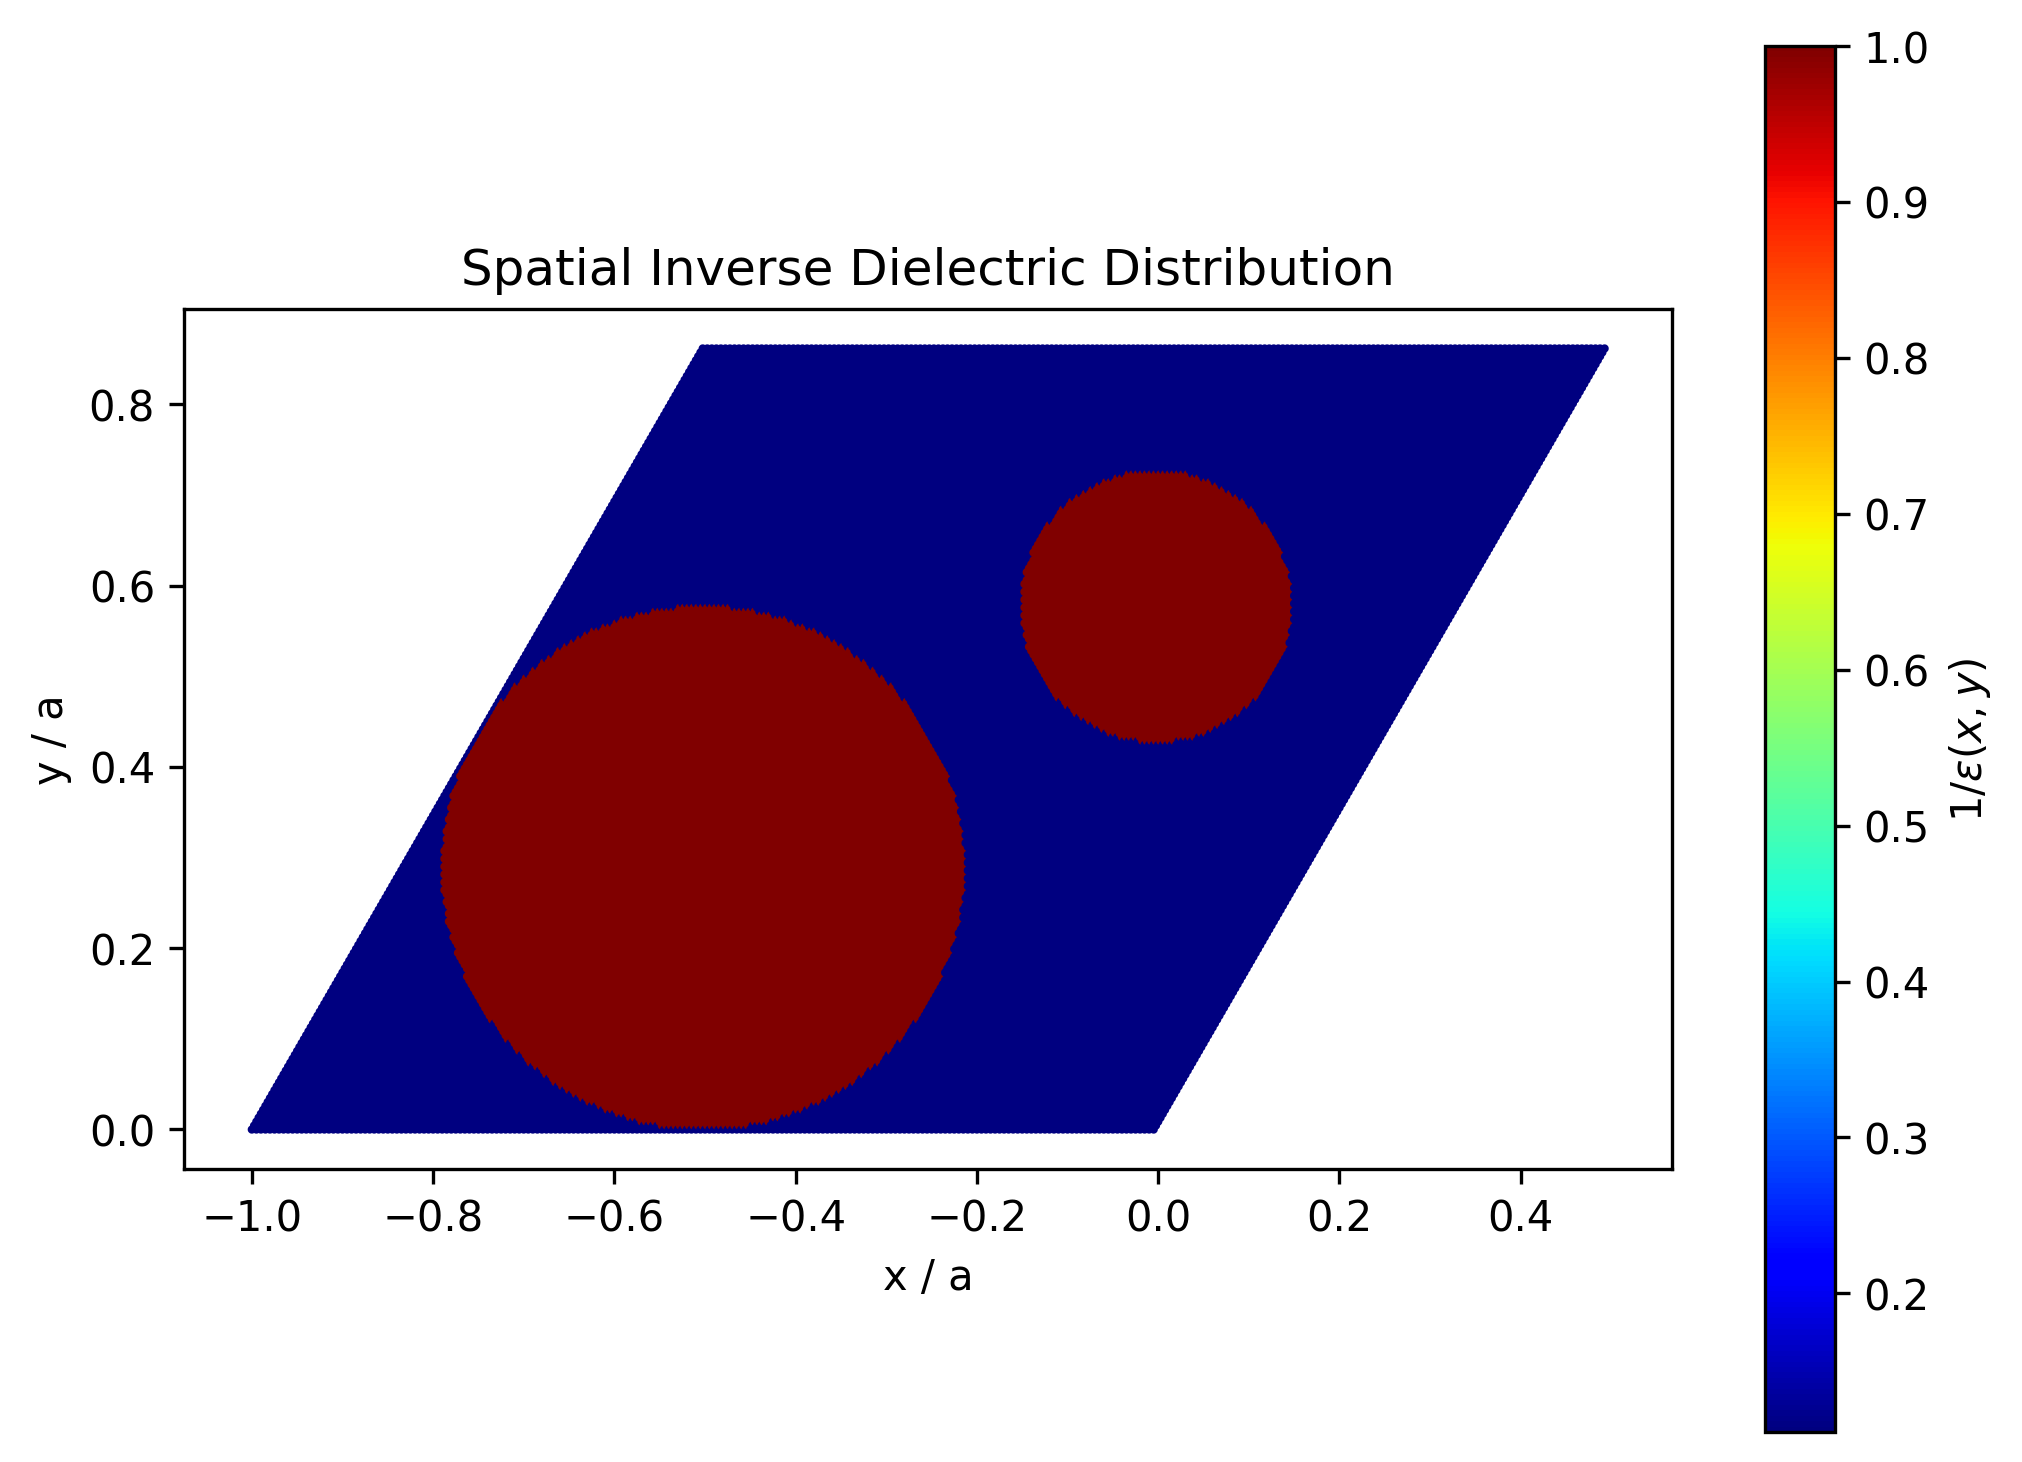

(40000, 1)
float64
K point Band 1:  363.04036020787976  GHz
K point Band 2:  443.0025131893289  GHz


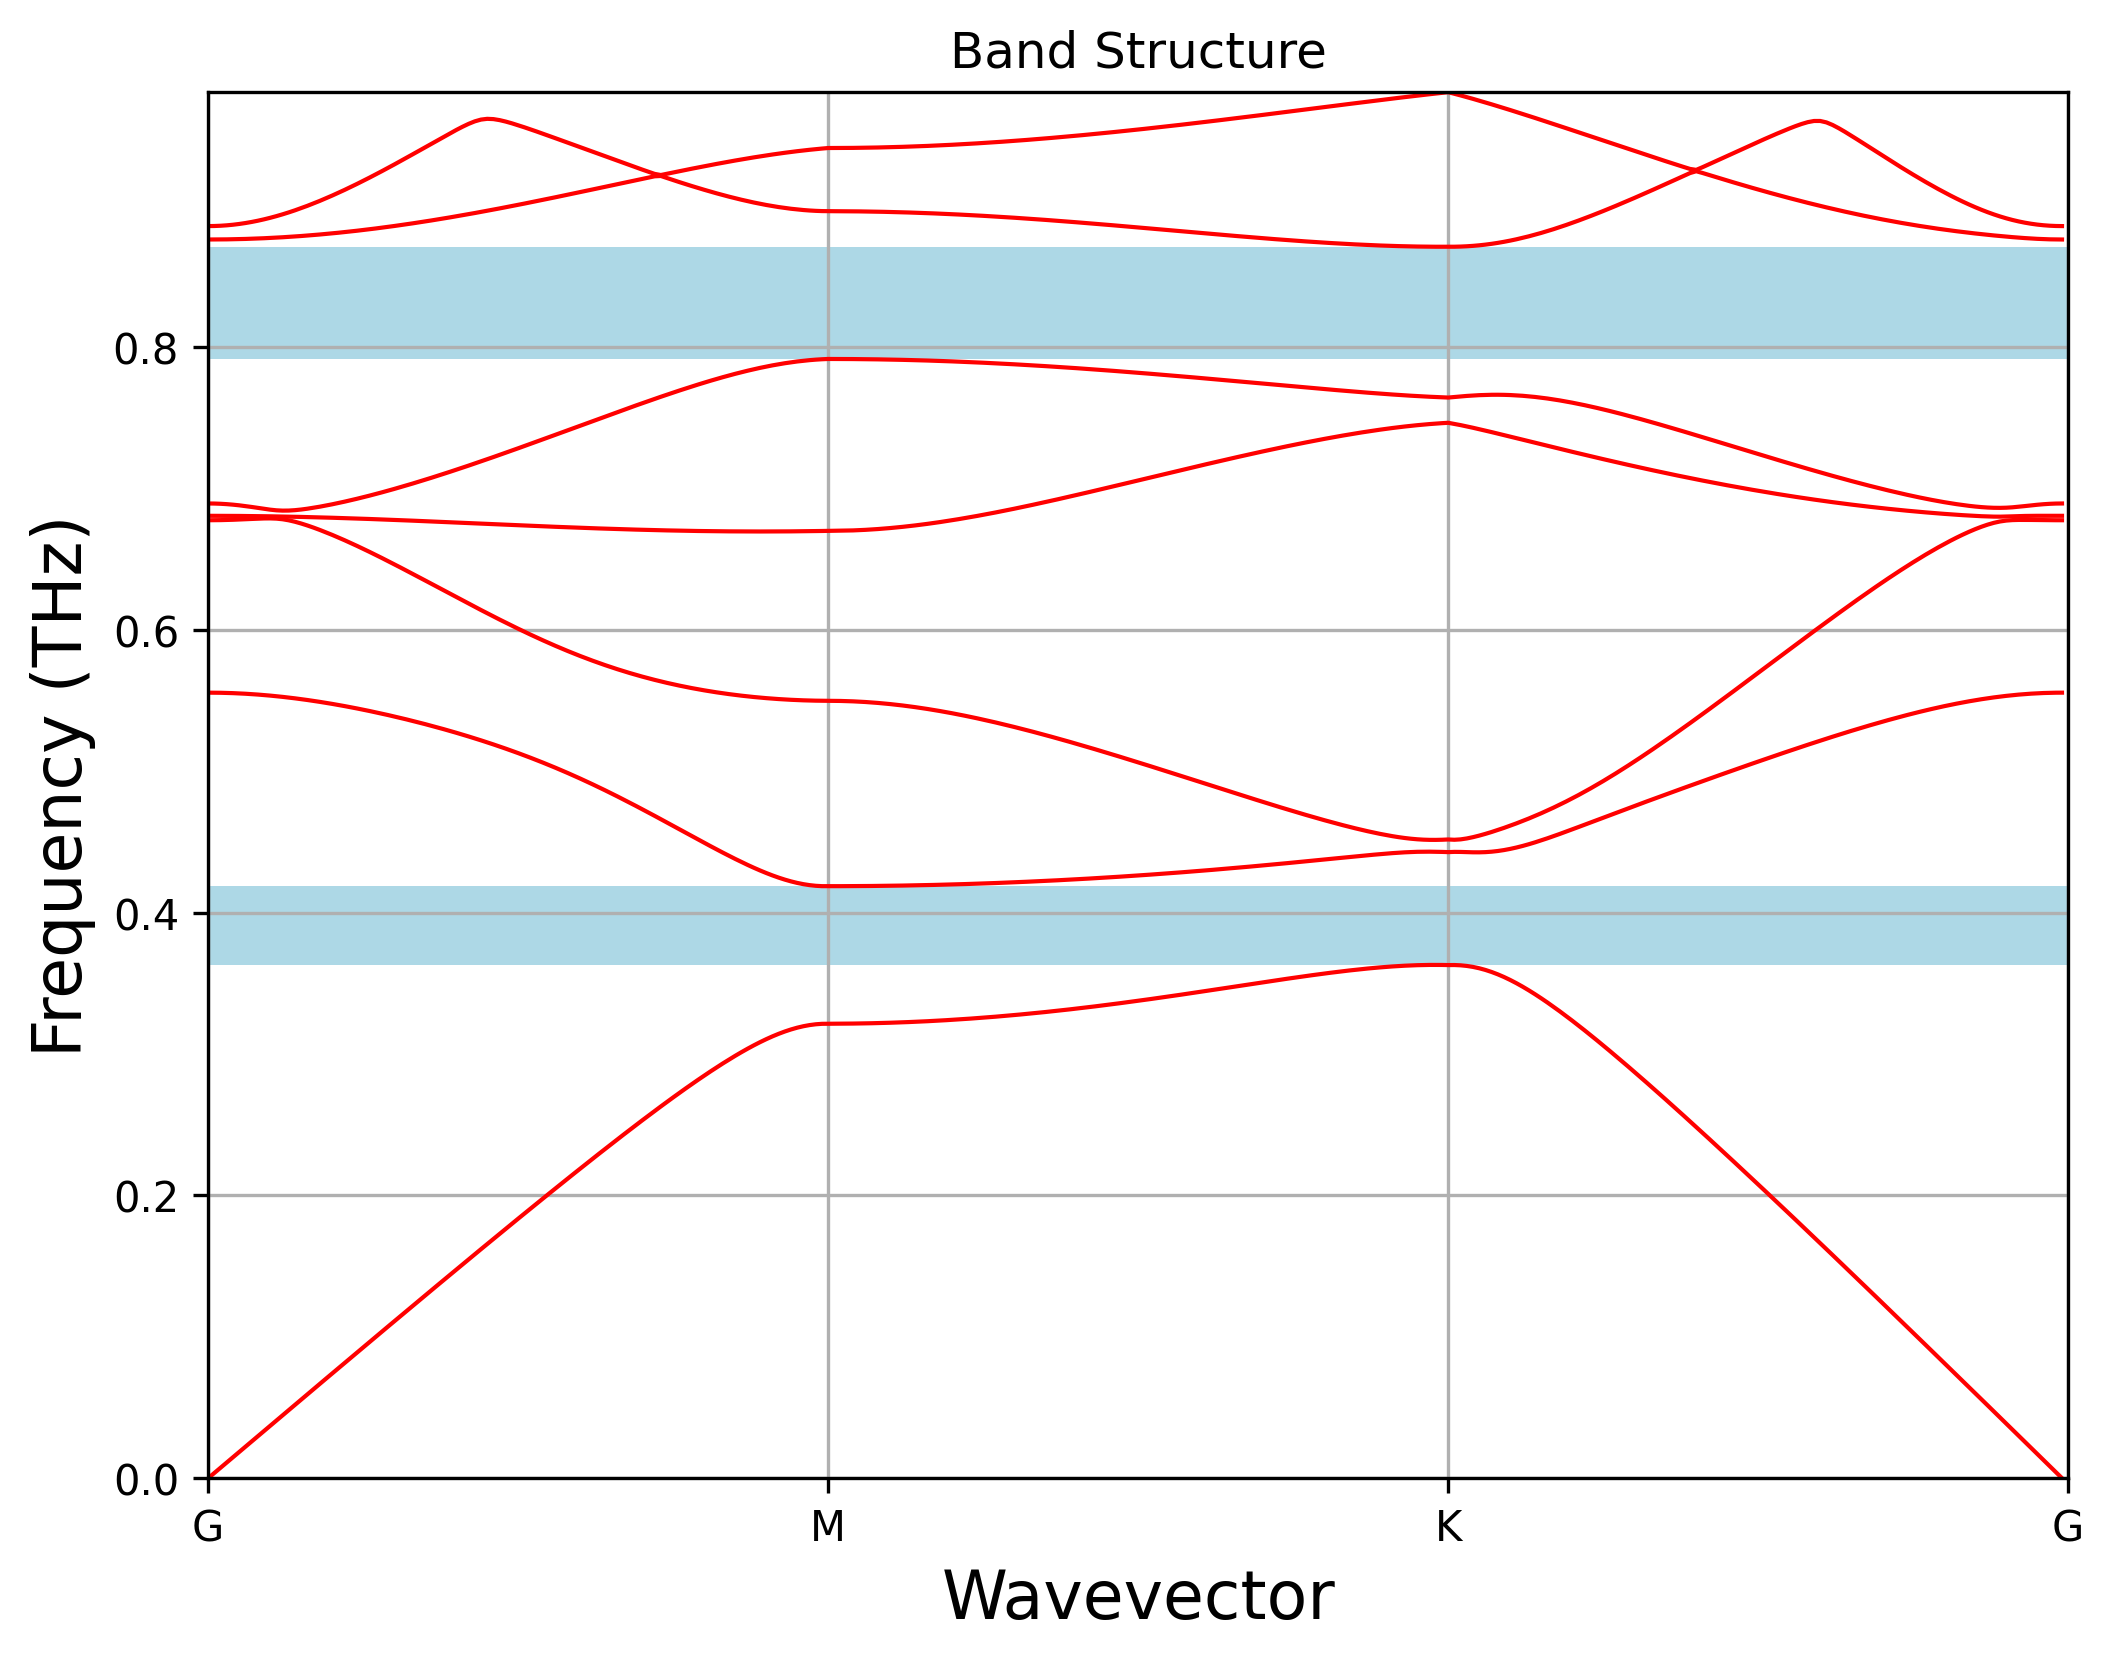

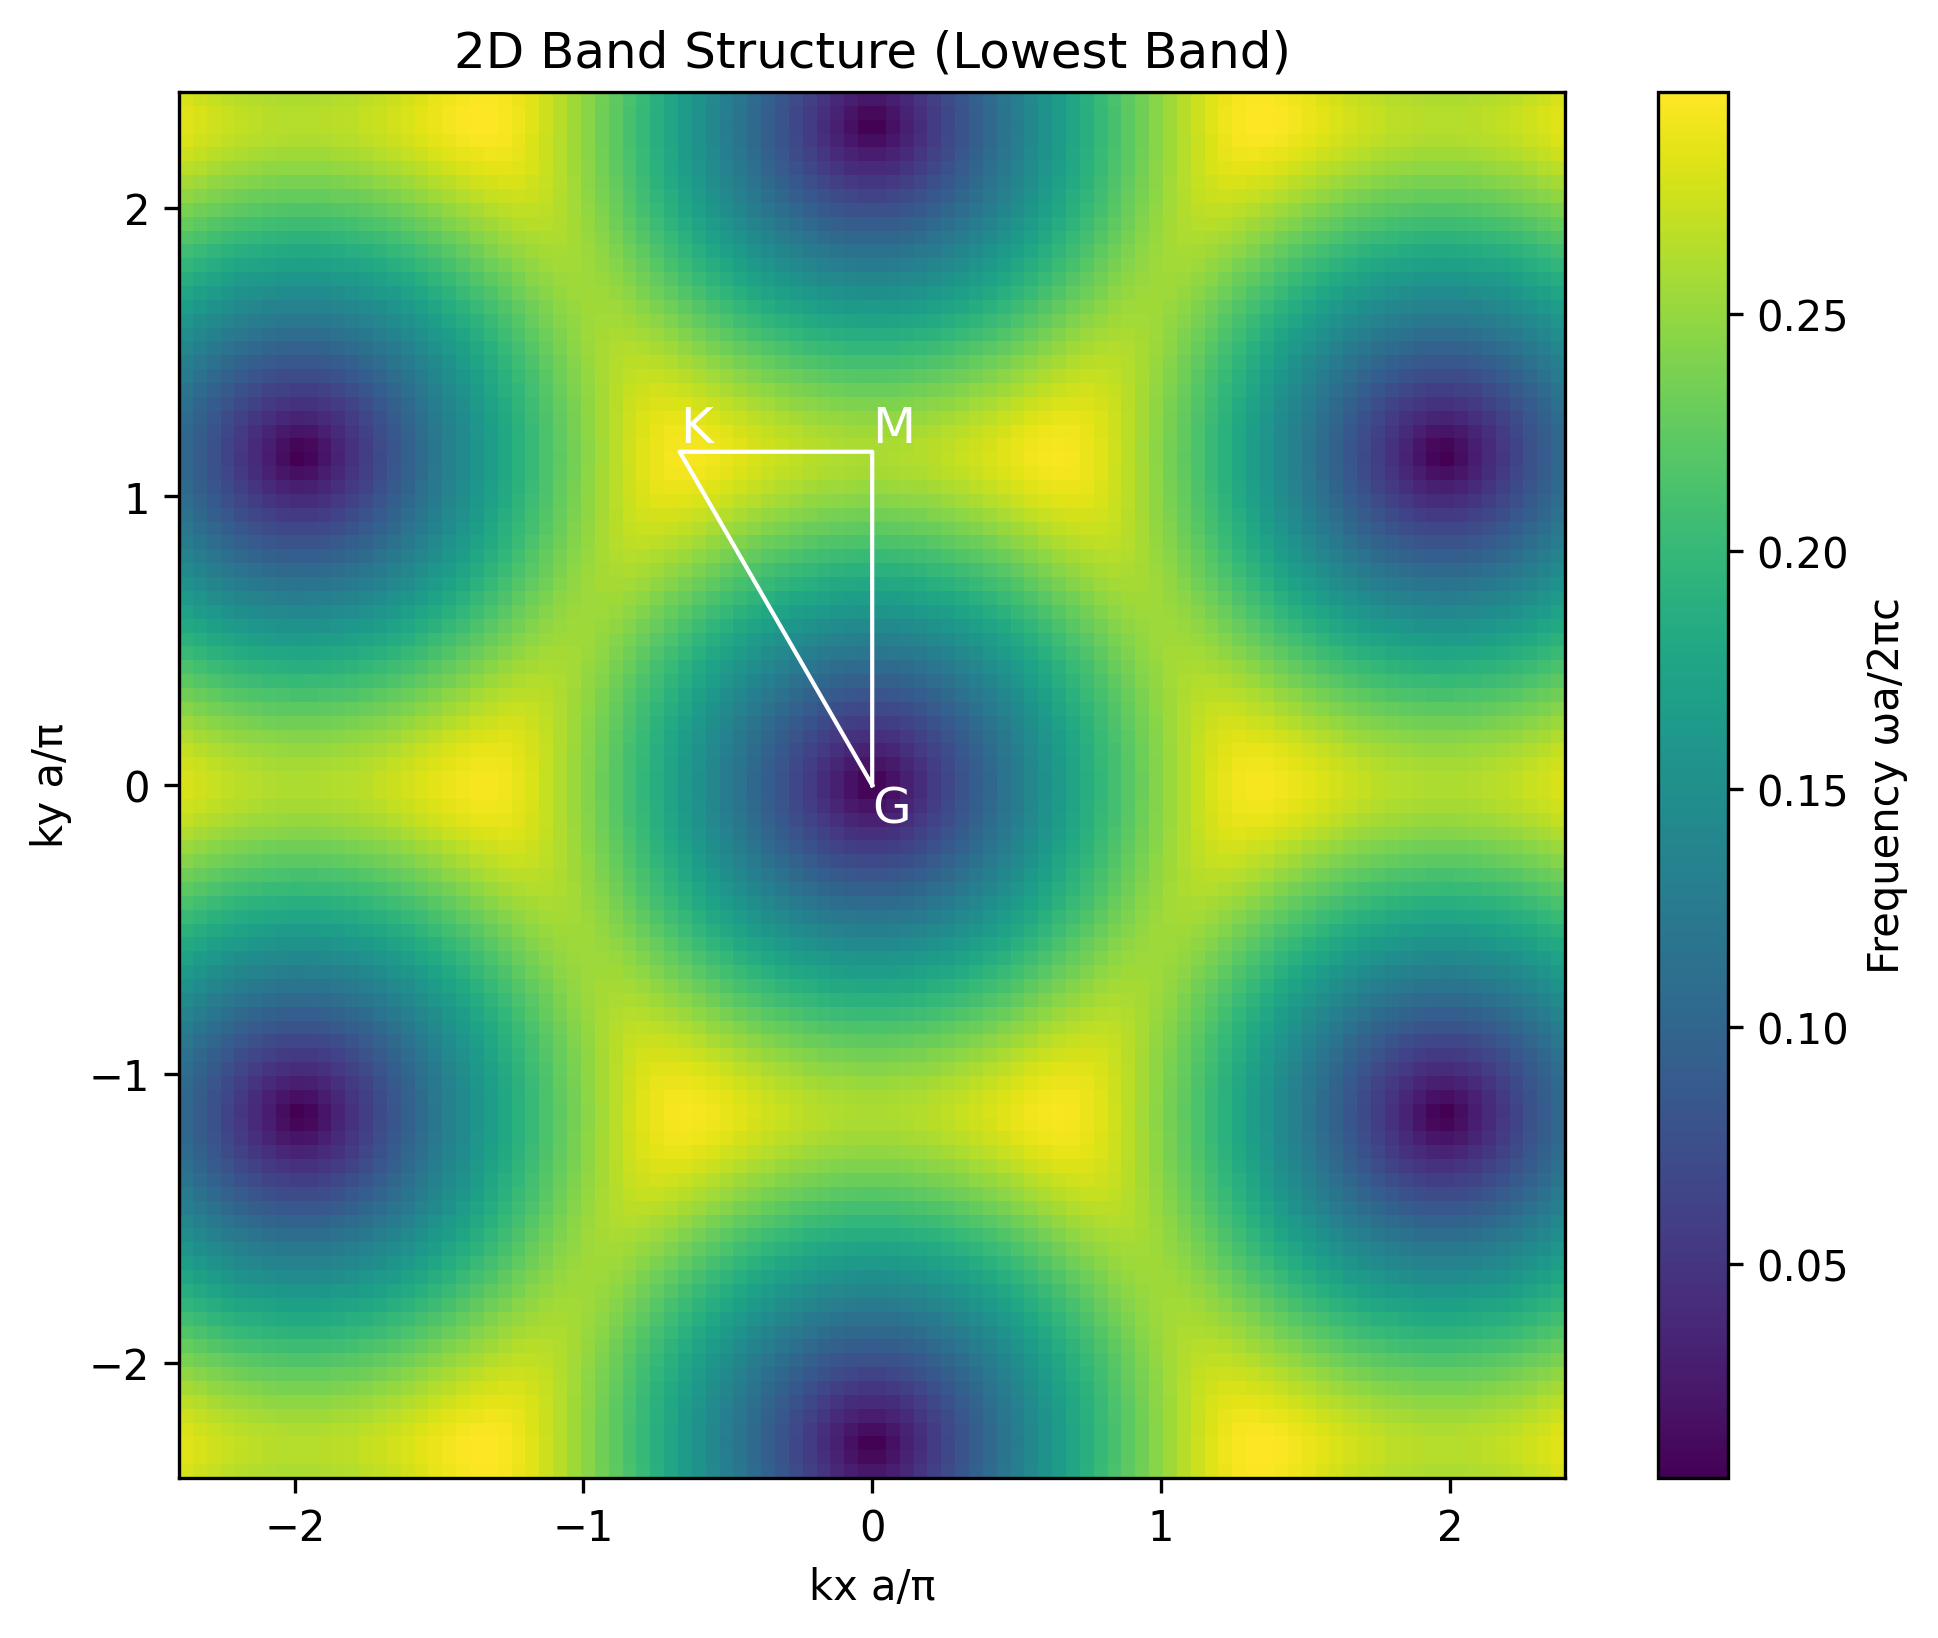

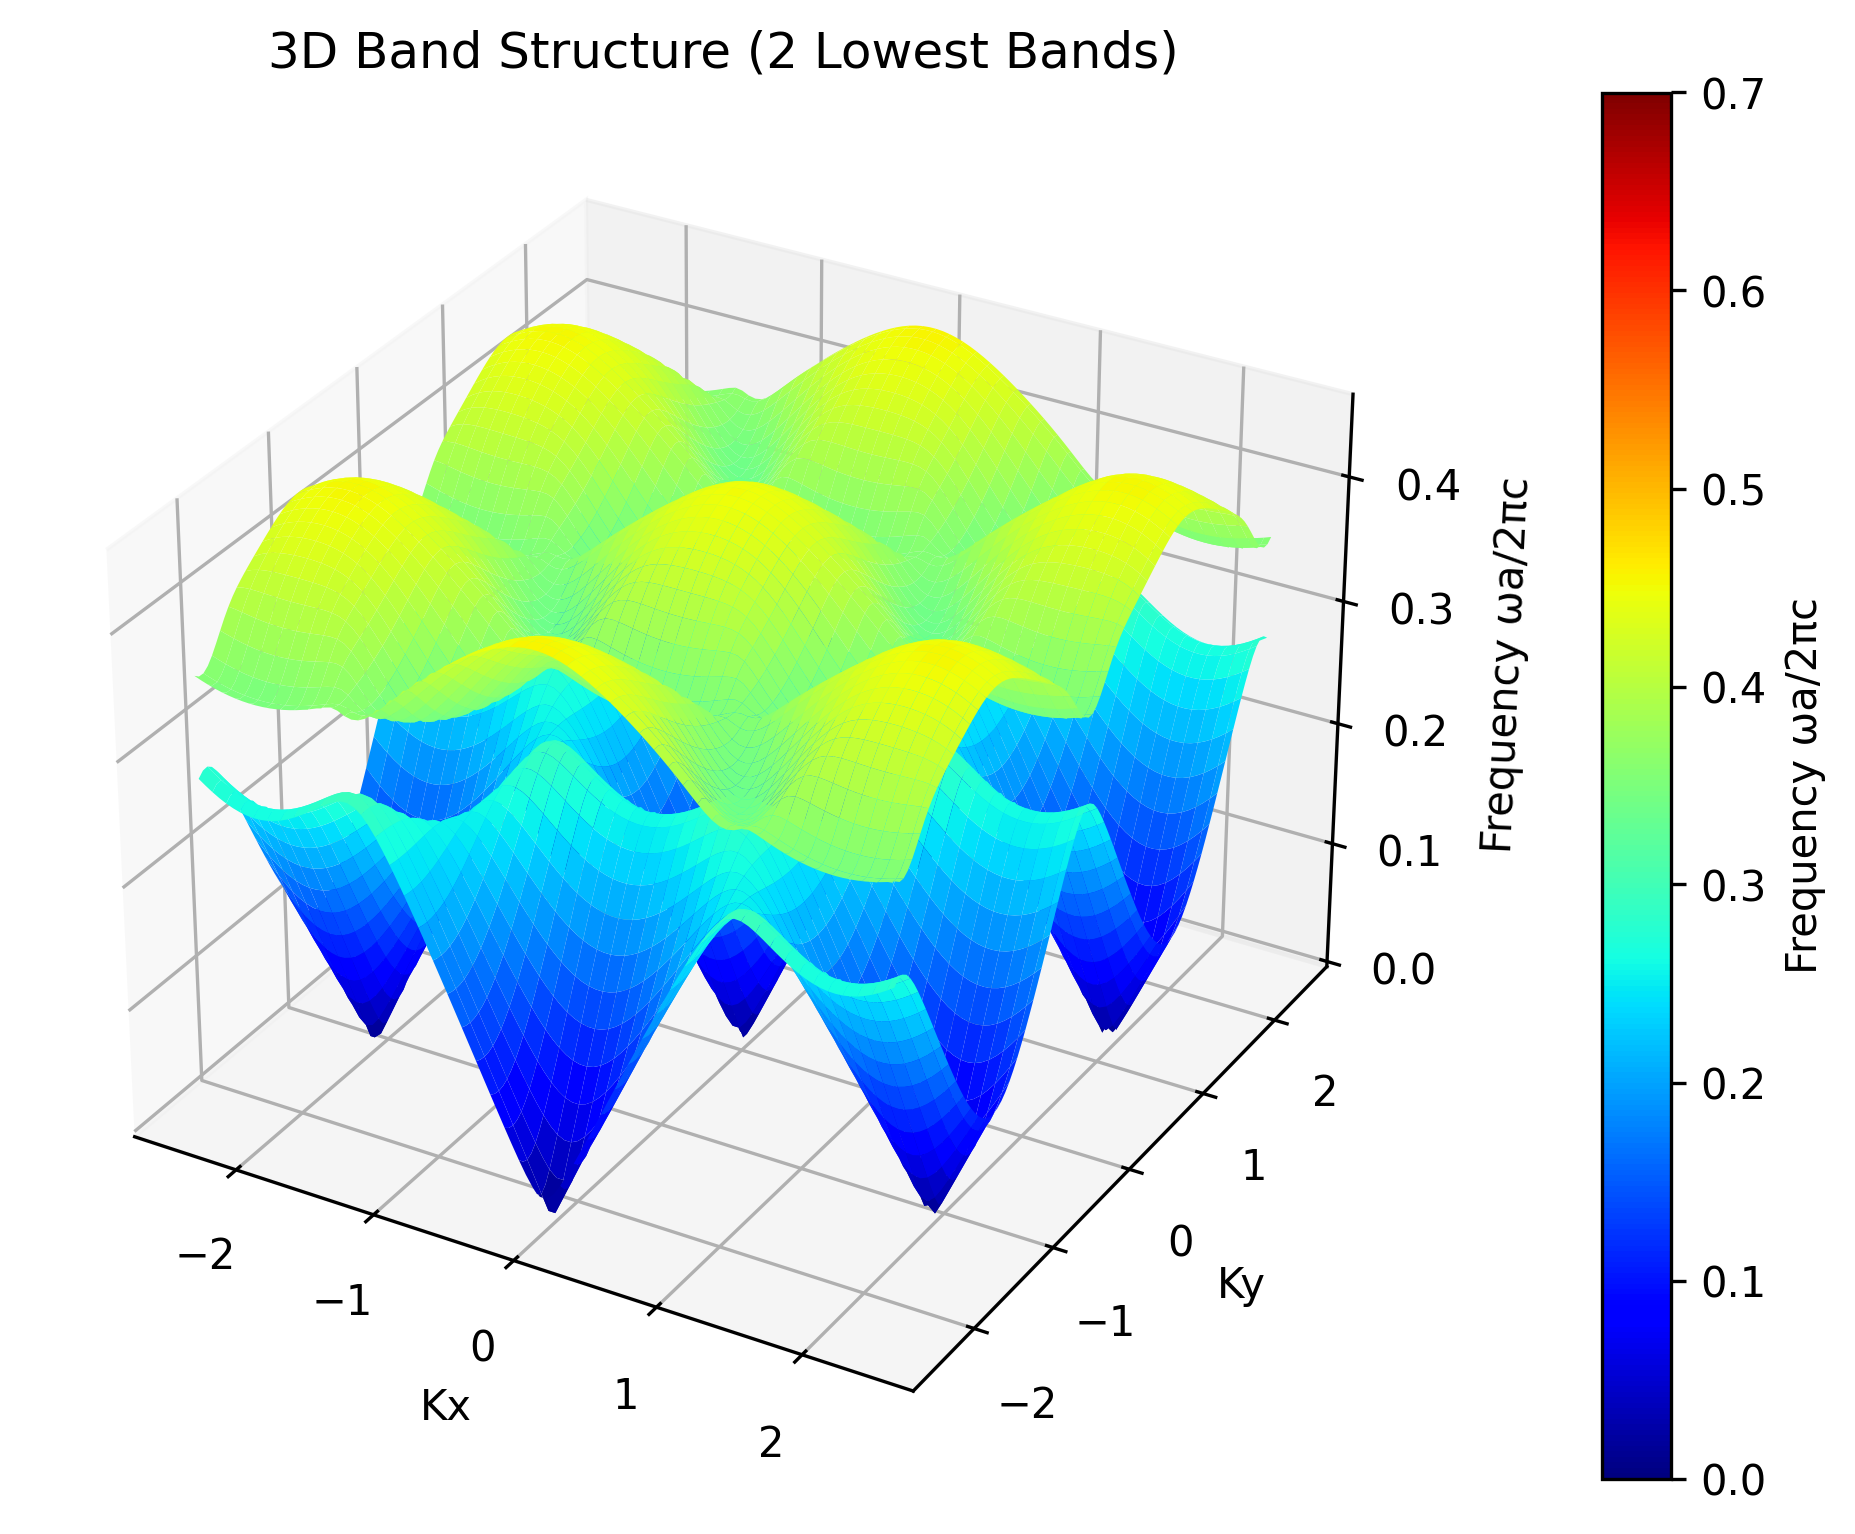

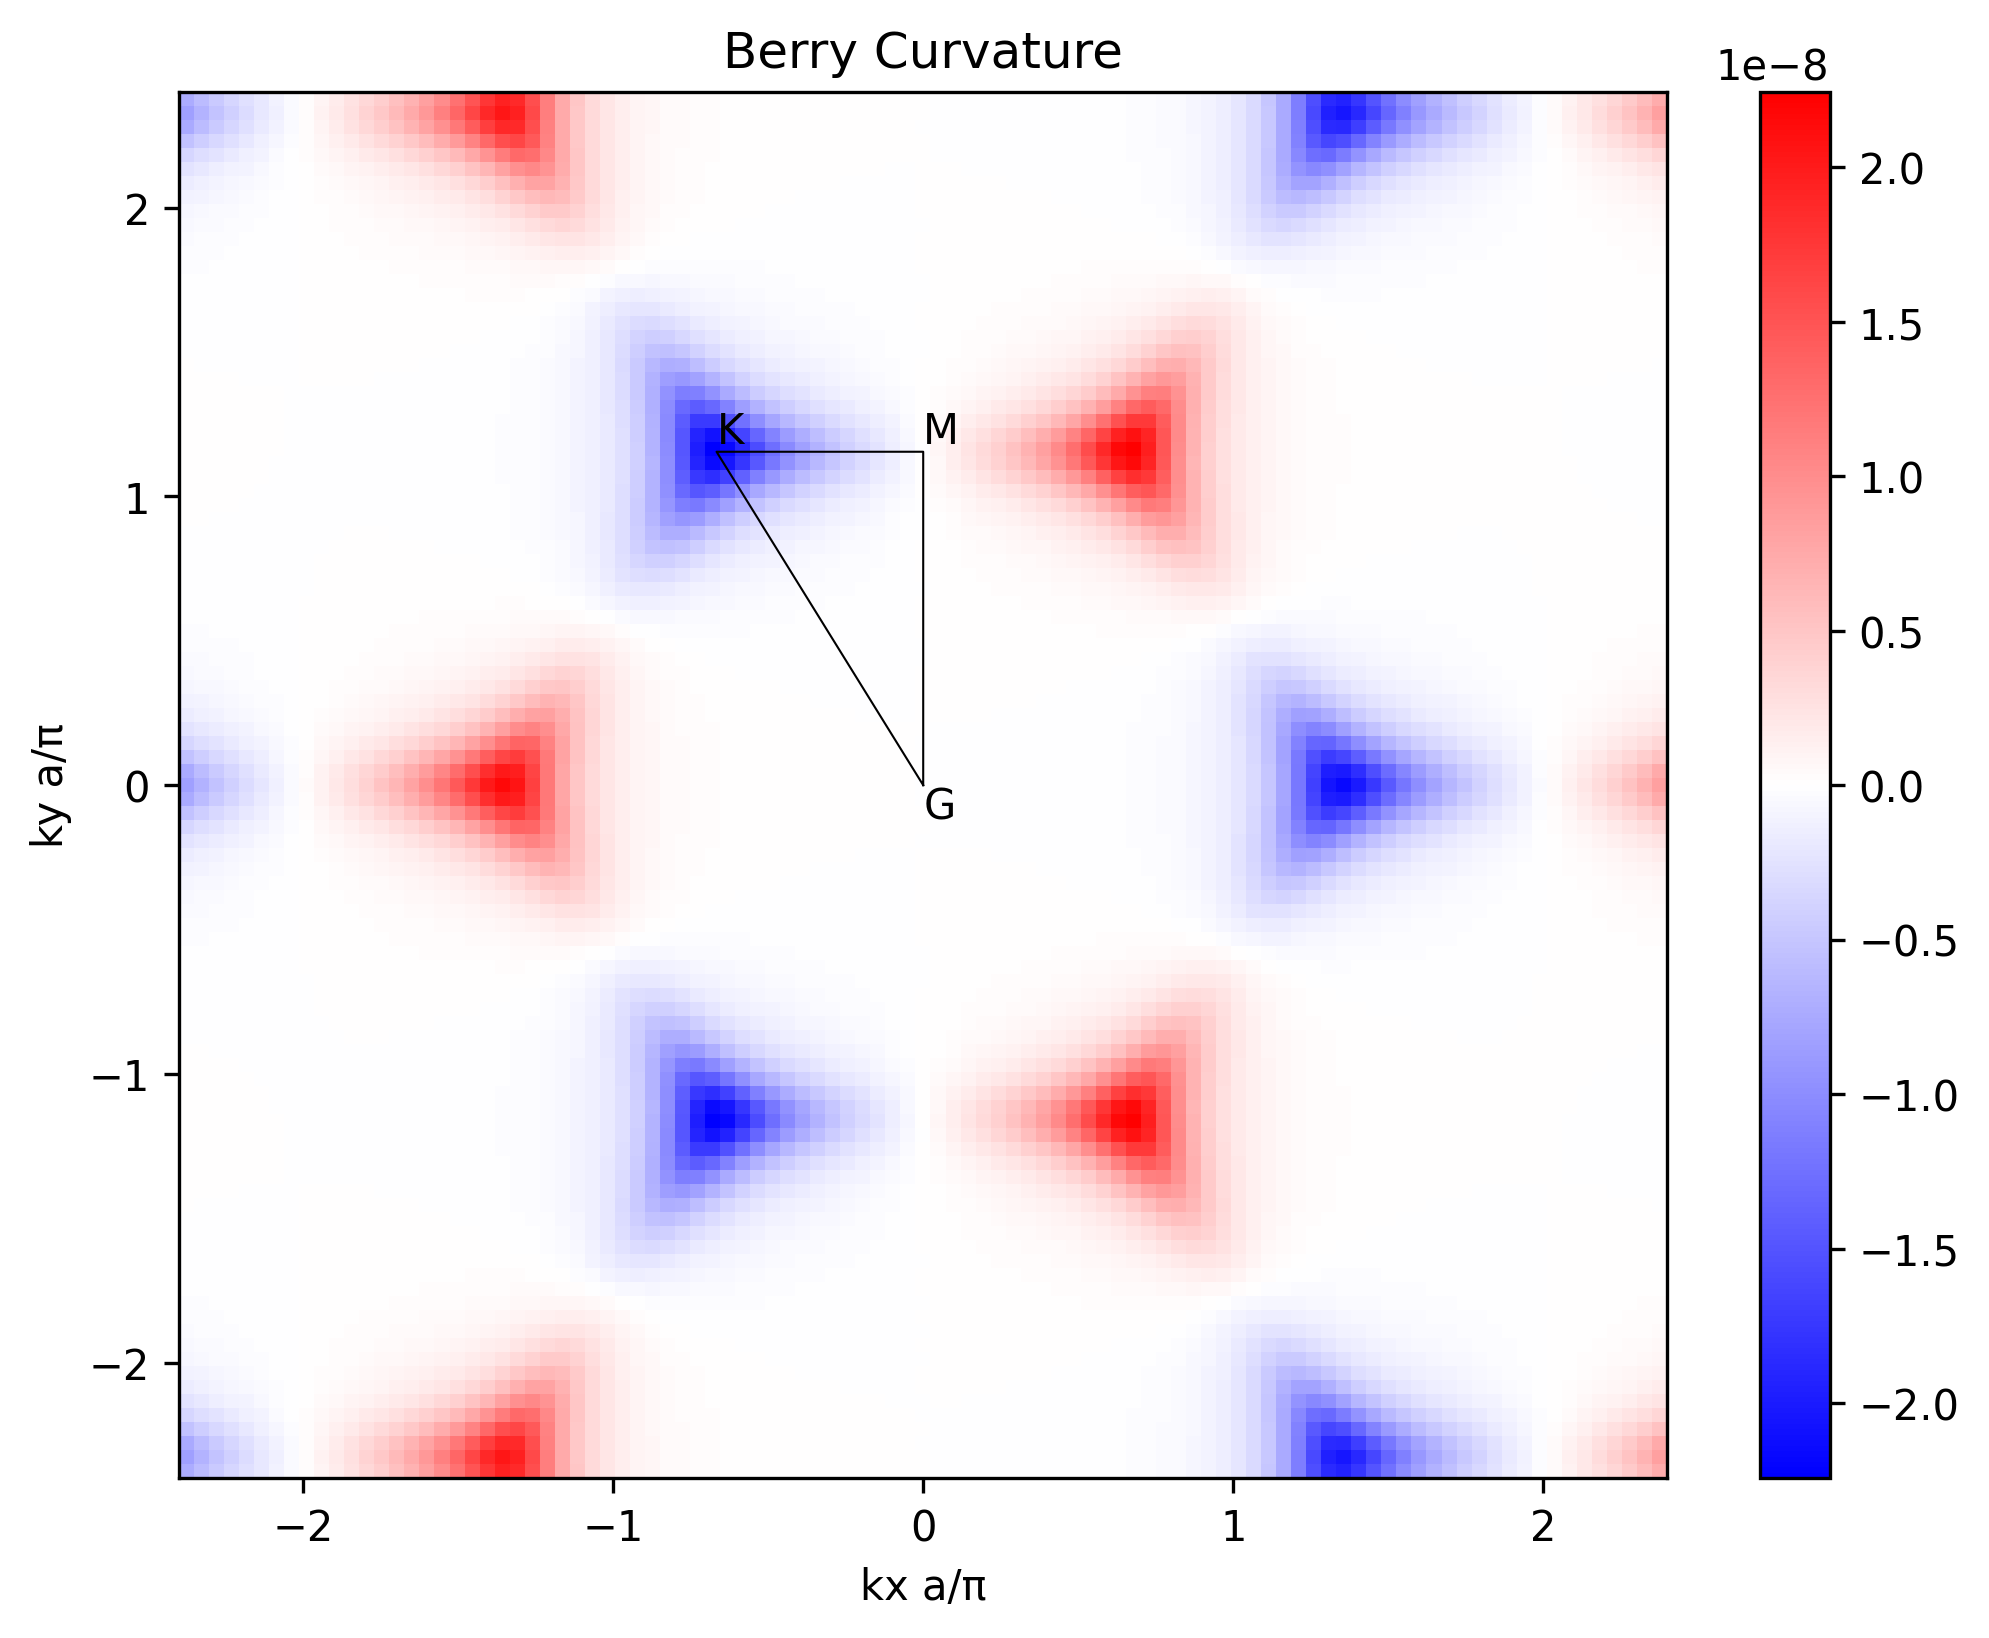

Band Gap:  55.685493333441684  GHz
Chern number at K: 0.11961480344916829, Chern number at K': -0.11437249693888321, Band Gap: 349.88227353572756, Relative Band Gap: 0.14244884636822308


In [4]:
from scipy.constants import epsilon_0
a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5 * 10**(-6), ng=3)
# seperation = 0 * a
# # rotation_angle = np.pi / 10
# rotation_angle = 0
# num_sides = 10
# delta_l = 0.2808870244105839
# symmetry_separation = -3.1434869966218934e-05
# rotation_angle = -0.6283185307179586
# num_sides = 3
# l_central = 0.5
# symmetry_separation = 0.0 * a
# rotation_angle = 0
# l1_ratio = 0.25
# l2_ratio = 0.35

l1_ratio = 0.5/np.sqrt(3)
l2_ratio = 0.15

# l1_ratio = 0.65
# l2_ratio = 0.0

symmetry_separation = 0.0 * a
rotation_angle_1 = 0
rotation_angle_2 = 0
l1, l2 = initialize_hole_parameters(a, l1_ratio = l1_ratio, l2_ratio = l2_ratio)

unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=300, number_of_sides_2=300, 
                                                polygon_with_radius=True, is_ellipse_1=False, is_ellipse_2=False,
                                                symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
# unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=3, number_of_sides_2=3, 
#                                                 polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
#                                                 symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)


# xi, yi, X, Y, inv_exy = specify_dielectric_function_hexagon(a, unit, N_sp=150)
xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=100)

print(inv_exy.shape)
print(inv_exy.dtype)
# xi, yi, X, Y, inv_exy = specify_dielectric_function_rectangle(a, unit)
khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
# inv_exy = reconstruct_inverse_dielectric_function(a, ng, xi, yi, B1, B2, khiG, M_lin, N_lin)
N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=50, band_index=1)
n = band_index
F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
dispe_reshaped = dispe.reshape((numG, 2 * N_BZ, 2 * N_BZ), order='C')
Gamma, M, K, vertices = high_symmetry_points()
plot_band_structure(dispe_reshaped, KX, KY, a, Gamma, M, K, vertices, band_index=1)
plot_3D_Band_Structure(dispe_reshaped, KX, KY, a)
plot_berry_curvature(F, KX, KY, a, Gamma, M, K, vertices)

n = 3
radius = 2 * np.pi / a * (2 / 3)
# Define the region of interest around the K point
kx_center_K = 2 * np.pi / a * (1 / 3)
ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))

vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
vertices_1 = np.array(vertices_1)
vertices_1 = np.vstack((vertices_1, vertices_1[0]))

n = 3

# Define the region of interest around the K point
kx_center_K_prime = 2 * np.pi / a * (2 / 3)
ky_center_K_prime = 0
# ky_center_K_prime = 2 * np.pi / a * (1 / np.sqrt(3))
vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
vertices_2 = np.array(vertices_2)
vertices_2 = np.vstack((vertices_2, vertices_2[0]))
chern_K, chern_K_prime = chern_number_calculation_polygon_area(F, KX, KY, a, del_S, vertices_1, vertices_2, kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

# topological_criterion = np.abs(chern_K) * relative_band_gap
print("Band Gap: ", band_gap * 1e-9 * (1/(2*np.pi)), " GHz")
# print(f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, Band Gap: {band_gap * 1e-9}, Relative Band Gap: {relative_band_gap},Topological Criterion: {topological_criterion}")
print(f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, Band Gap: {band_gap * 1e-9}, Relative Band Gap: {relative_band_gap}")

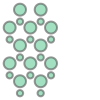

In [5]:
unit

In [6]:
# from scipy.constants import epsilon_0
# a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5 * 10**(-6), ng=3)
# # seperation = 0 * a
# # # rotation_angle = np.pi / 10
# # rotation_angle = 0
# # num_sides = 10
# # delta_l = 0.2808870244105839
# # symmetry_separation = -3.1434869966218934e-05
# # rotation_angle = -0.6283185307179586
# # num_sides = 3
# # l_central = 0.5
# # symmetry_separation = 0.0 * a
# # rotation_angle = 0
# # l1_ratio = 0.25
# # l2_ratio = 0.35

# l1_ratio = 0.67
# l2_ratio = 0.33

# # l1_ratio = 0.23
# # l2_ratio = 0.00

# symmetry_separation = 0.0 * a
# rotation_angle_1 = 0
# rotation_angle_2 = 0
# l1, l2 = initialize_hole_parameters(a, l1_ratio = l1_ratio, l2_ratio = l2_ratio)

# # unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=300, number_of_sides_2=300, 
# #                                                 polygon_with_radius=True, is_ellipse_1=False, is_ellipse_2=False,
# #                                                 symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
# unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=3, number_of_sides_2=3, 
#                                                 polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
#                                                 symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)


# xi, yi, X, Y, inv_exy = specify_dielectric_function_hexagon(a, unit, N_sp=150)
# # xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=100)
# # xi, yi, X, Y, inv_exy = specify_dielectric_function_rectangle(a, unit)
# khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
# khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
# inv_exy = reconstruct_inverse_dielectric_function(a, ng, xi, yi, B1, B2, khiG, M_lin, N_lin)
# N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
# N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=50, band_index=1)
# n = band_index
# F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
# dispe_reshaped = dispe.reshape((numG, 2 * N_BZ, 2 * N_BZ), order='C')
# Gamma, M, K, vertices = high_symmetry_points()
# plot_band_structure(dispe_reshaped, KX, KY, a, Gamma, M, K, vertices, band_index=1)
# plot_3D_Band_Structure(dispe_reshaped, KX, KY, a)
# plot_berry_curvature(F, KX, KY, a, Gamma, M, K, vertices)

# n = 3
# radius = 2 * np.pi / a * (2 / 3)
# # Define the region of interest around the K point
# kx_center_K = 2 * np.pi / a * (1 / 3)
# ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))

# vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
# vertices_1 = np.array(vertices_1)
# vertices_1 = np.vstack((vertices_1, vertices_1[0]))

# n = 3

# # Define the region of interest around the K point
# kx_center_K_prime = 2 * np.pi / a * (2 / 3)
# ky_center_K_prime = 0
# # ky_center_K_prime = 2 * np.pi / a * (1 / np.sqrt(3))
# vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
# vertices_2 = np.array(vertices_2)
# vertices_2 = np.vstack((vertices_2, vertices_2[0]))
# chern_K, chern_K_prime = chern_number_calculation_polygon_area(F, KX, KY, a, del_S, vertices_1, vertices_2, kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

# # topological_criterion = np.abs(chern_K) * relative_band_gap
# print("Band Gap: ", band_gap * 1e-9 * (1/(2*np.pi)), " GHz")
# # print(f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, Band Gap: {band_gap * 1e-9}, Relative Band Gap: {relative_band_gap},Topological Criterion: {topological_criterion}")


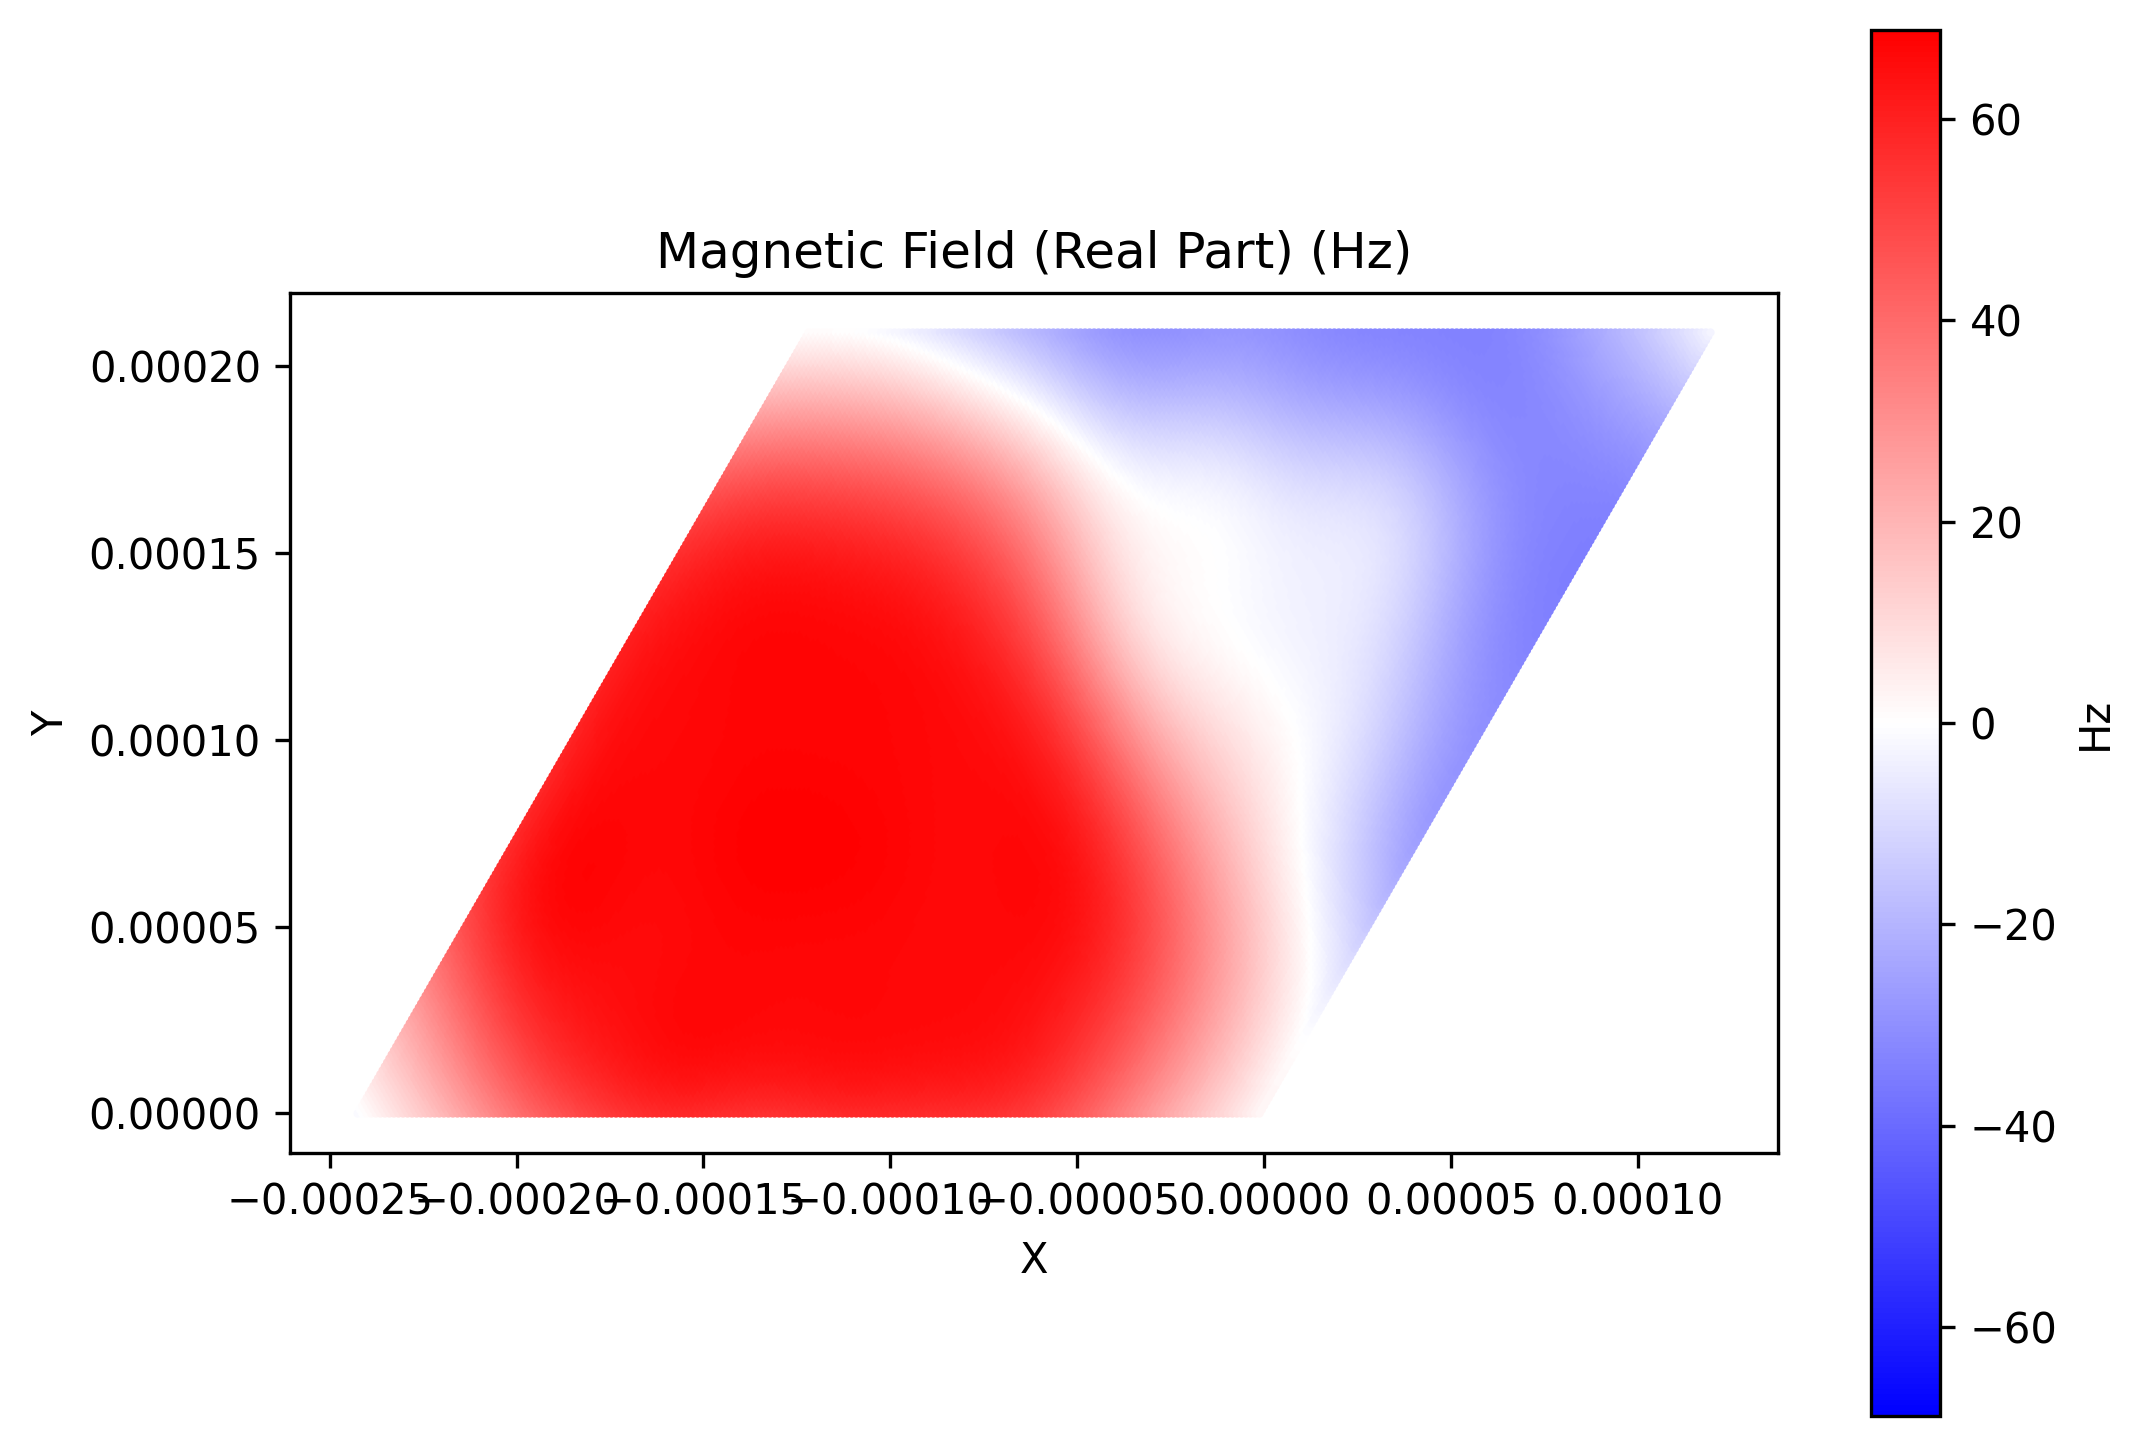

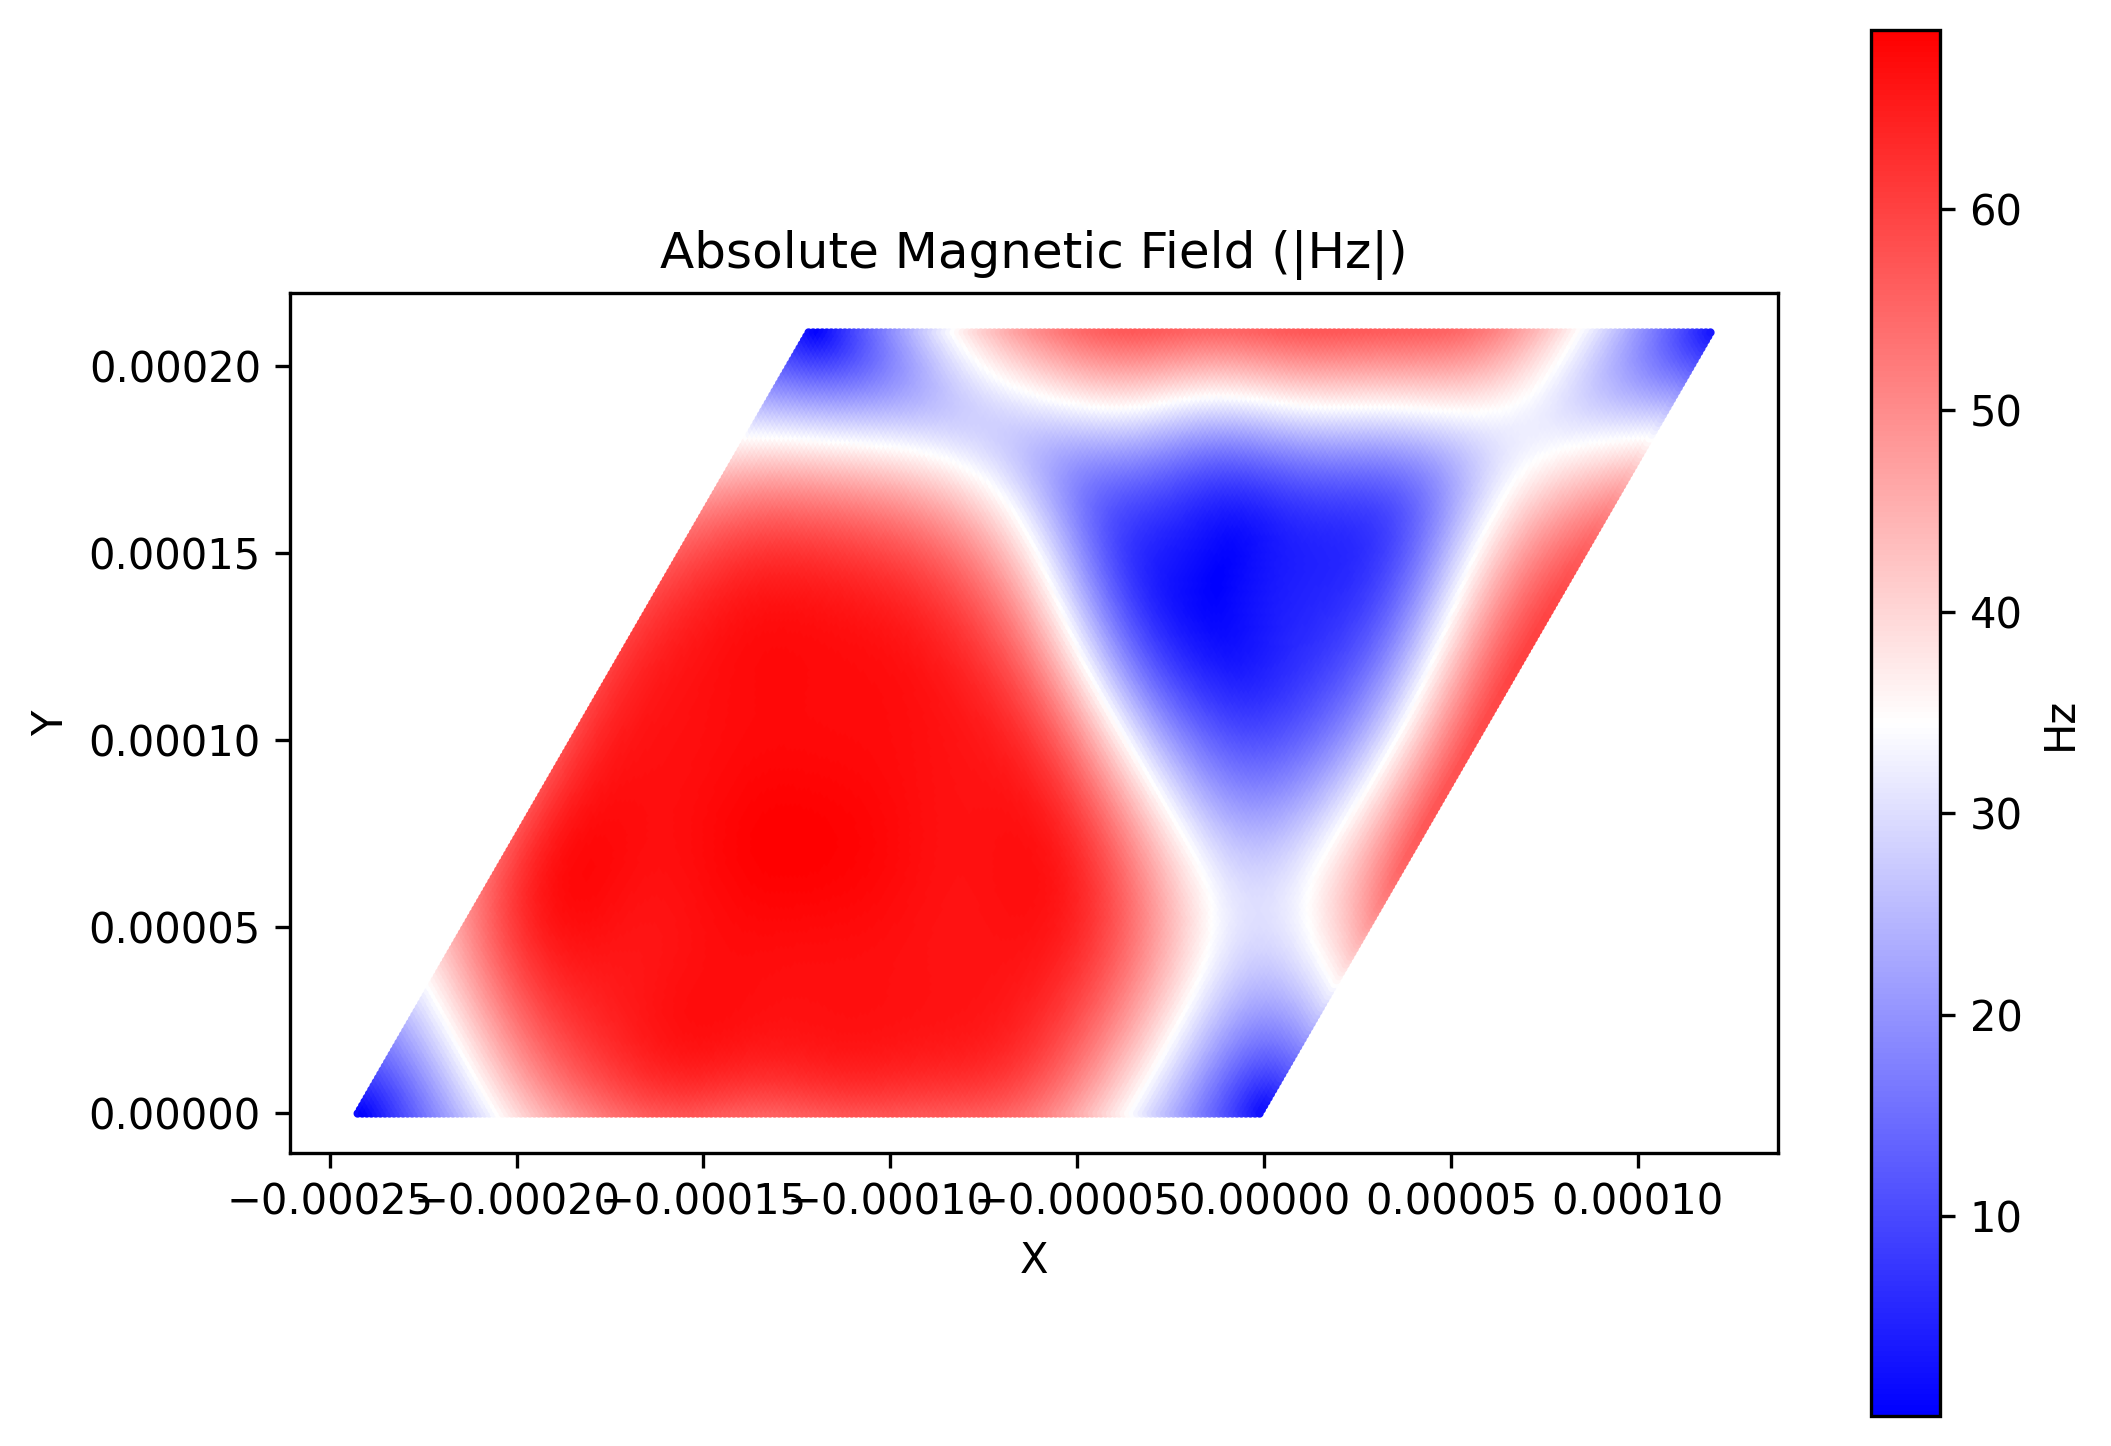

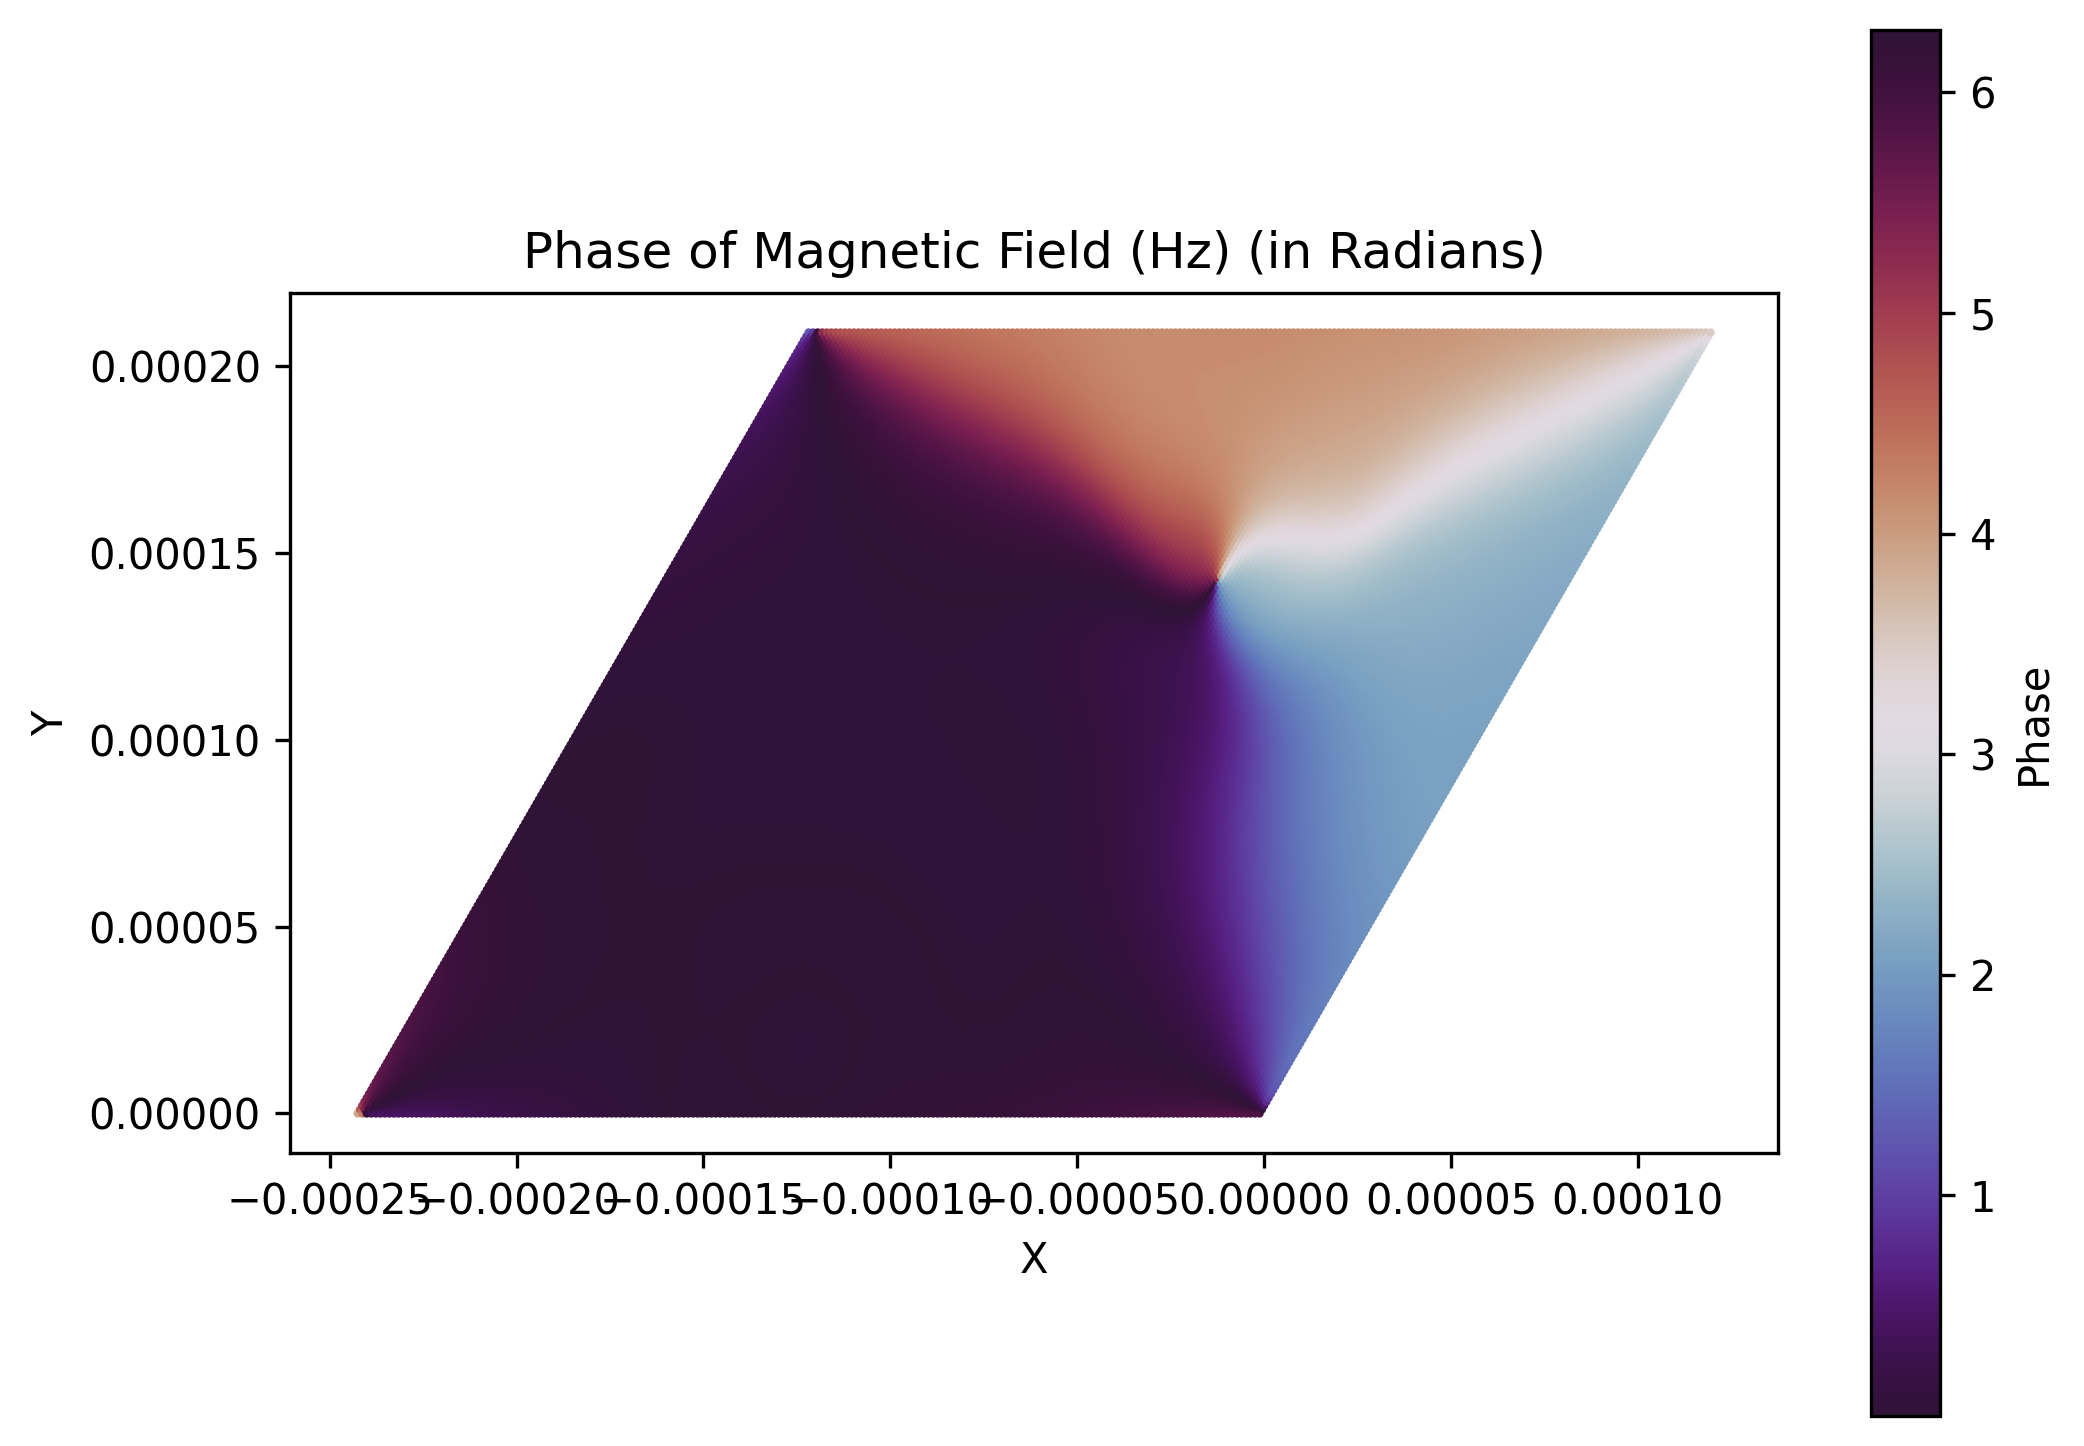

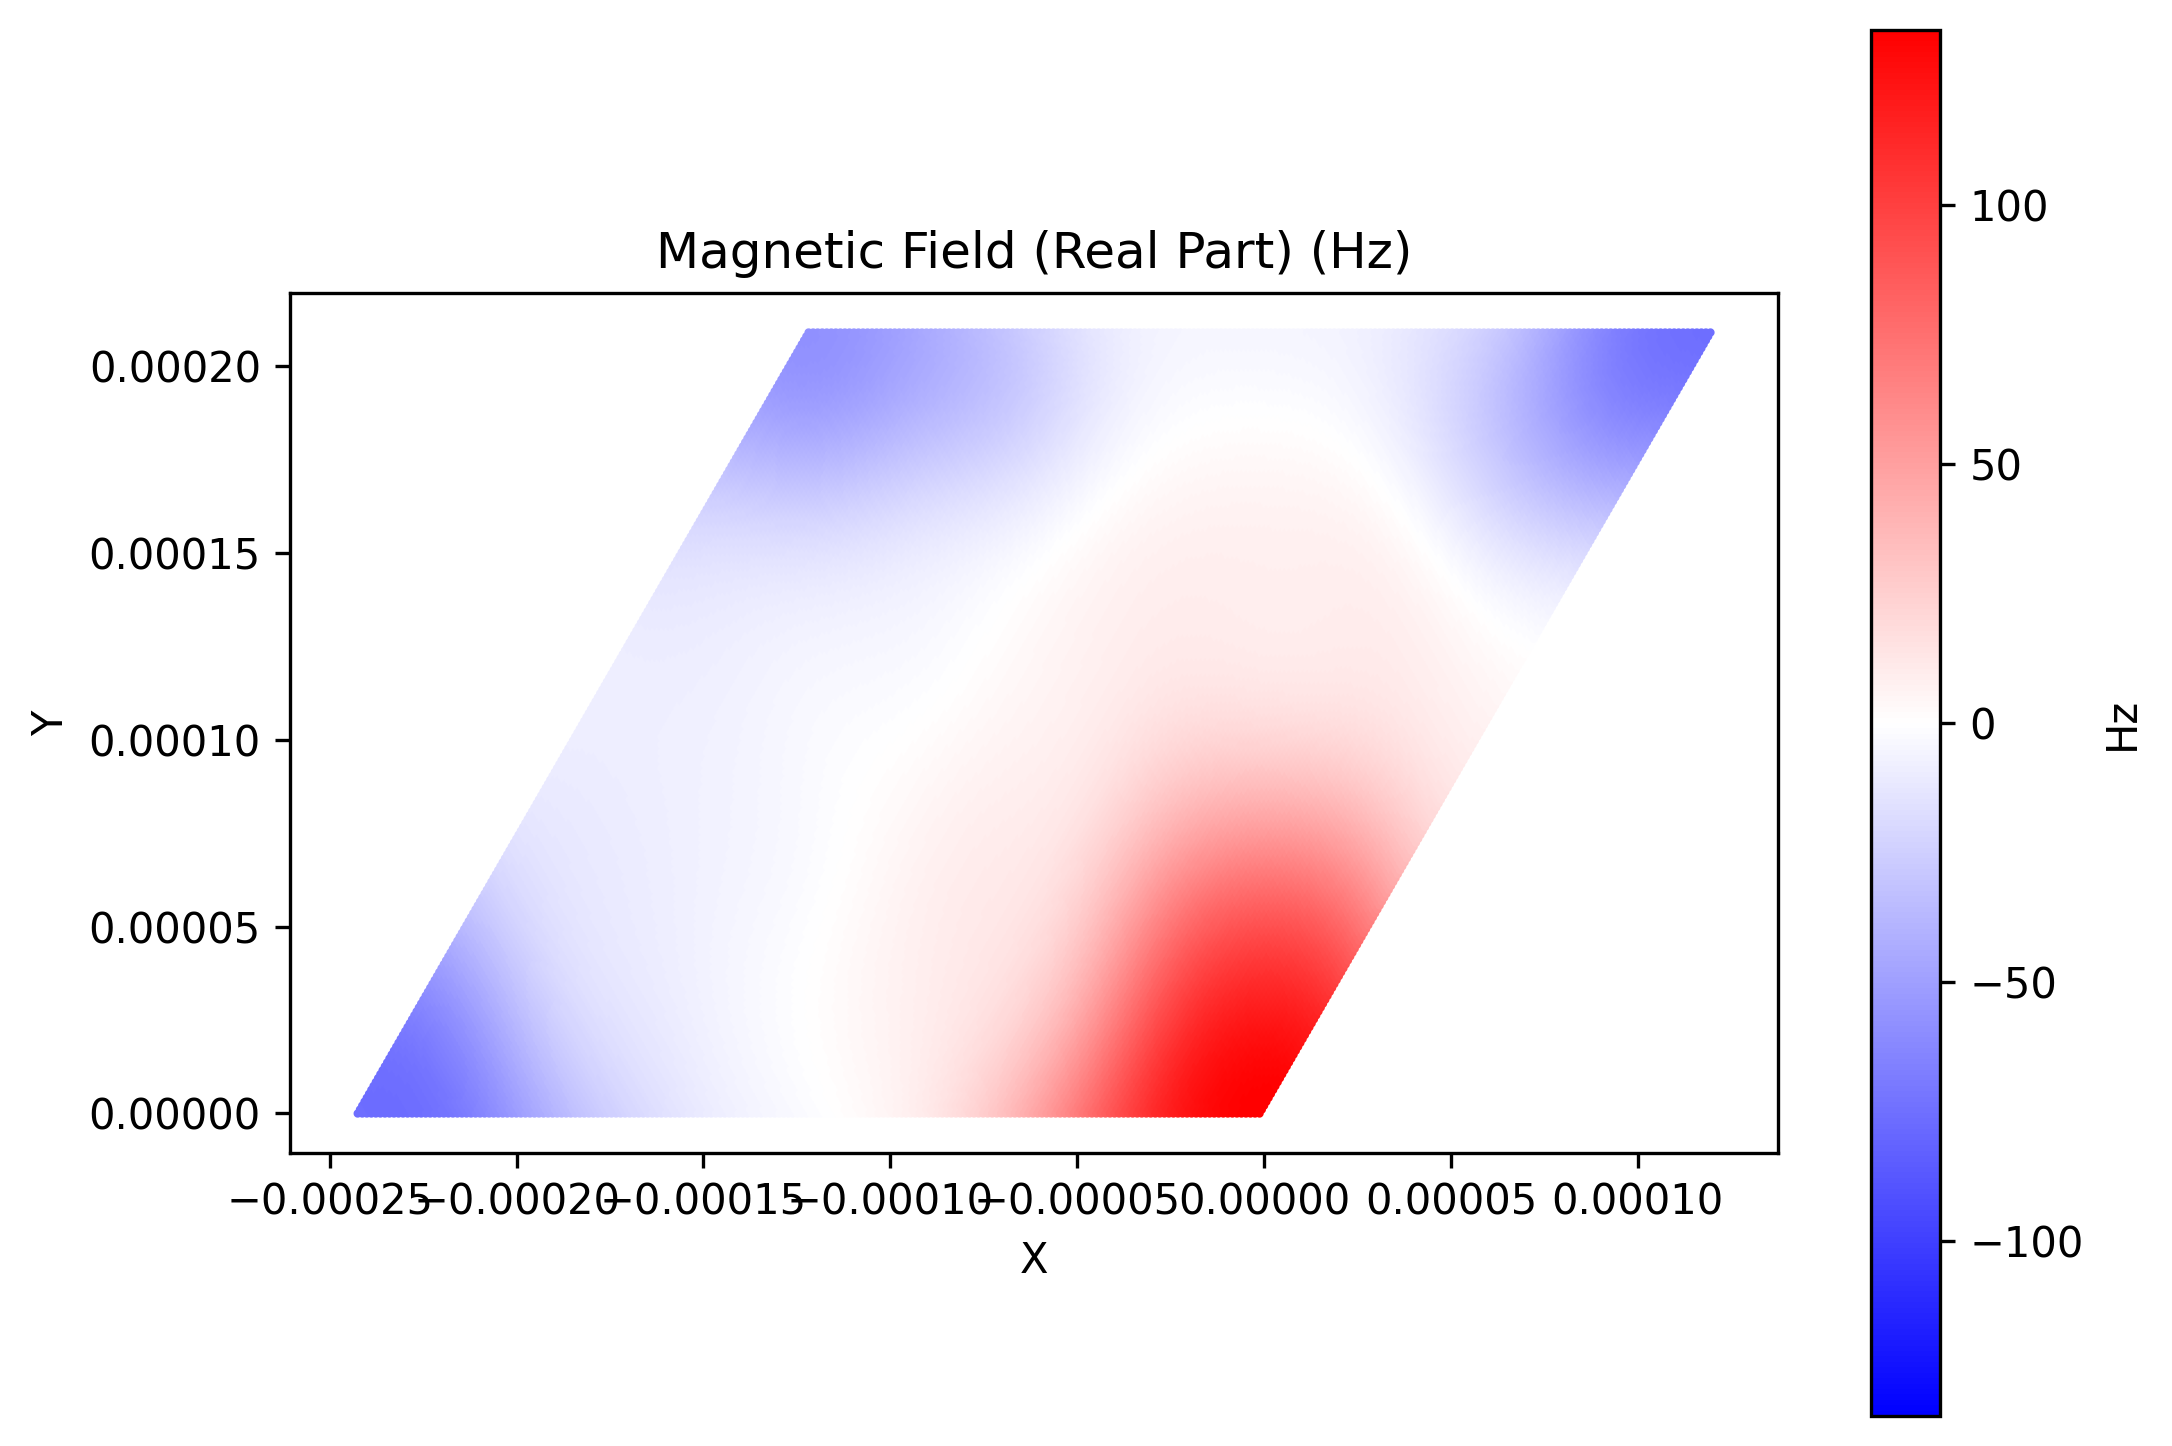

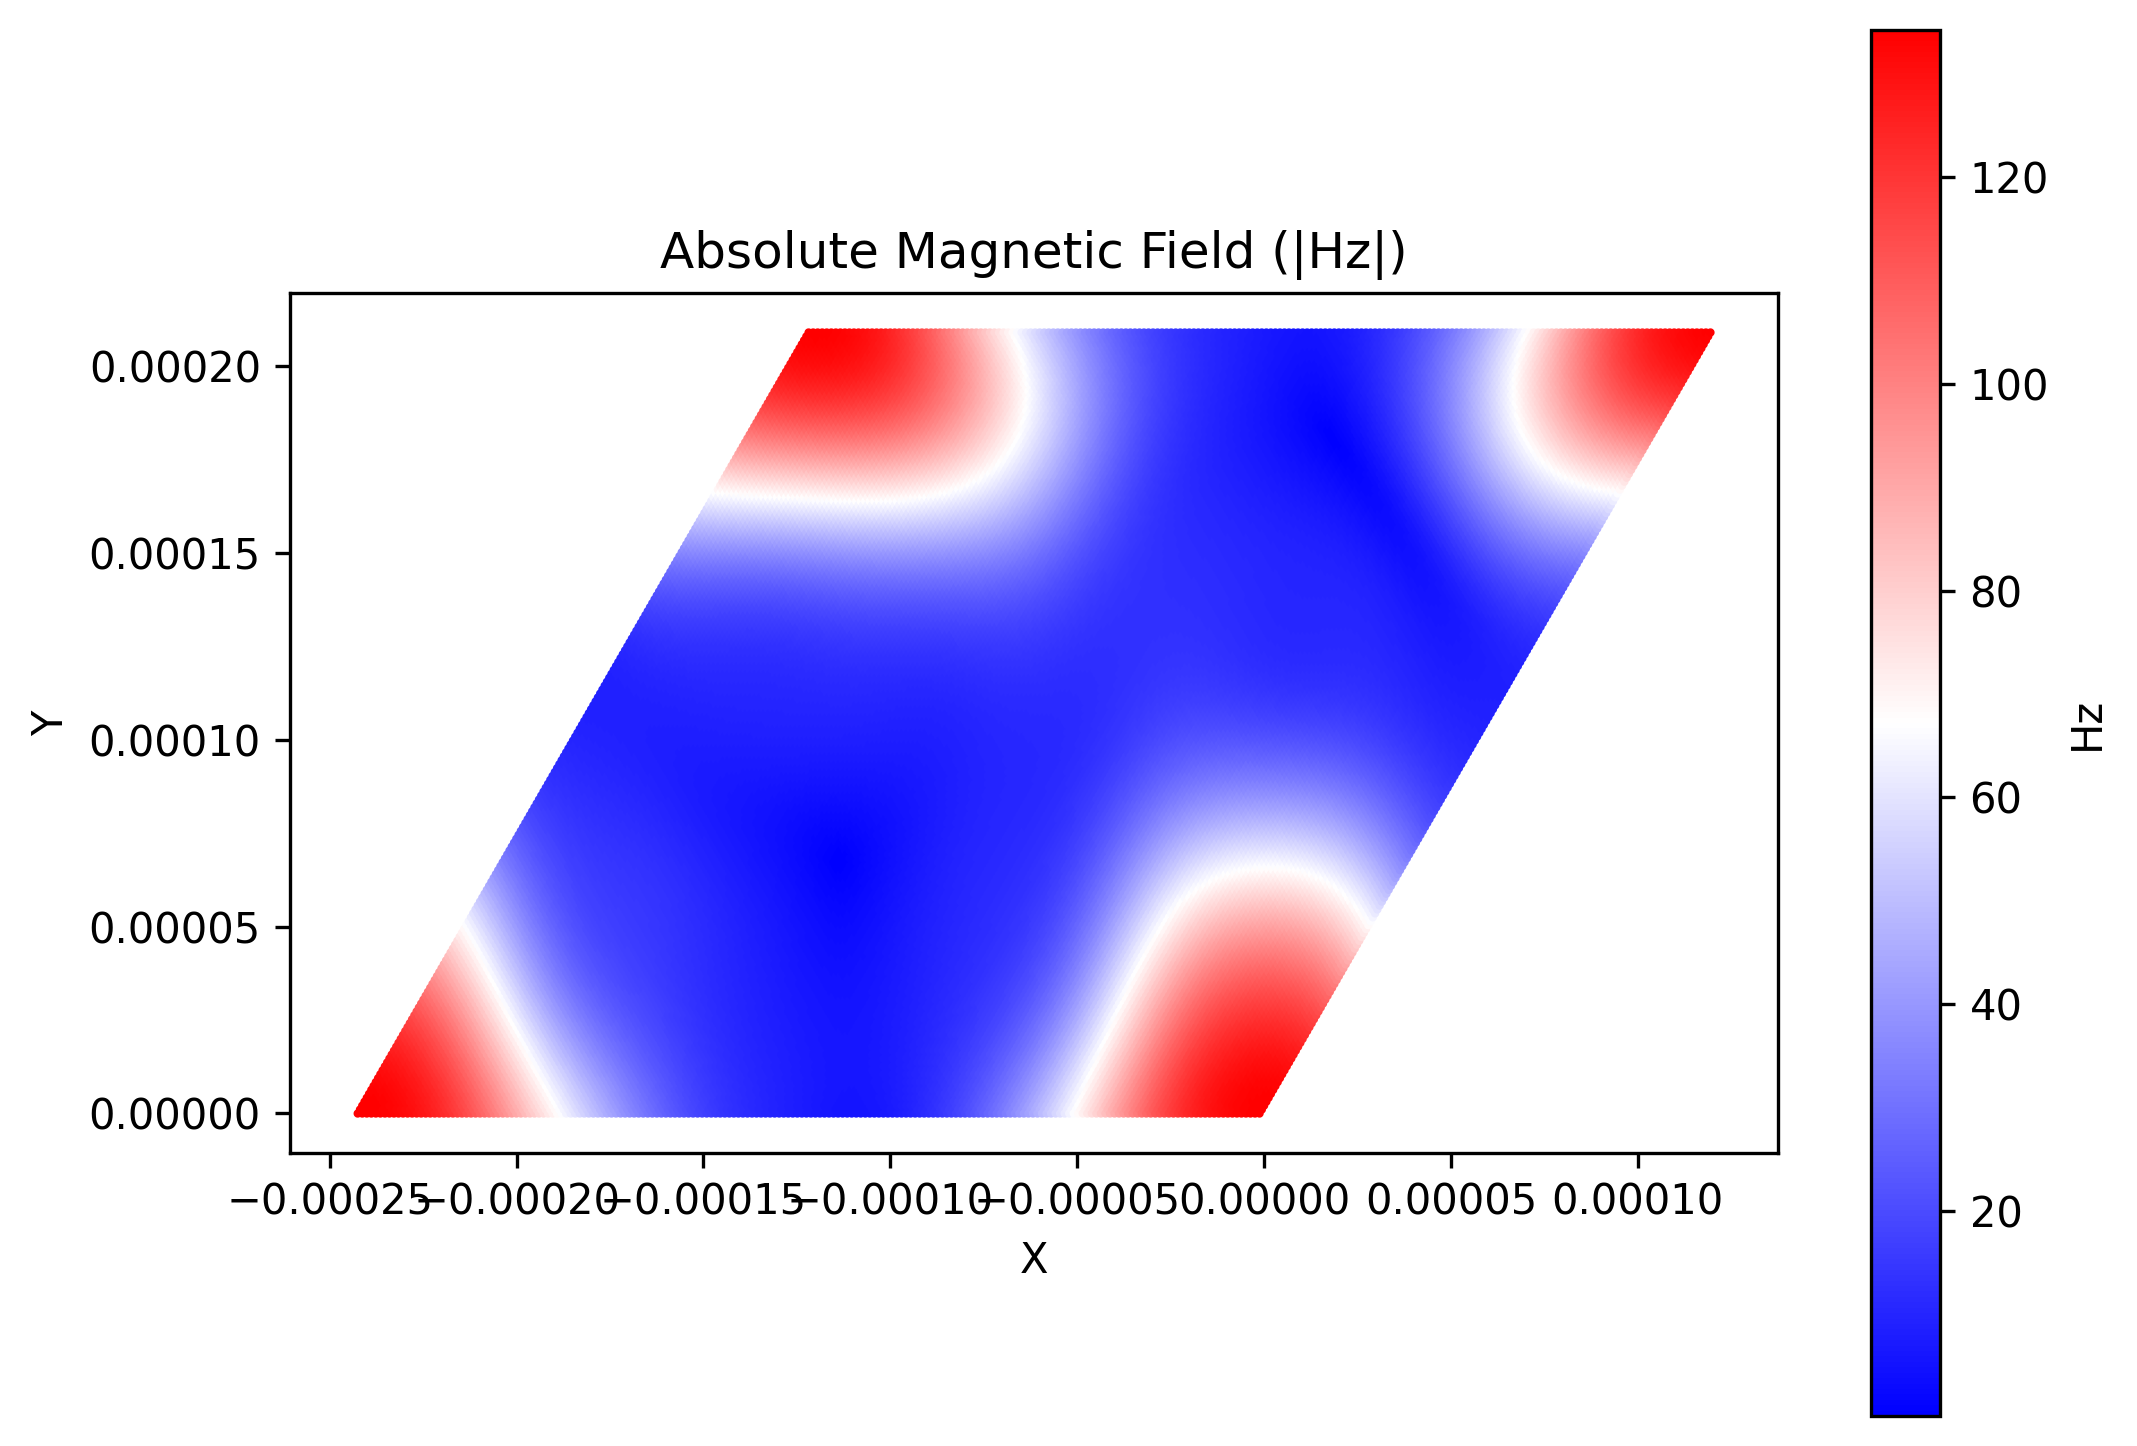

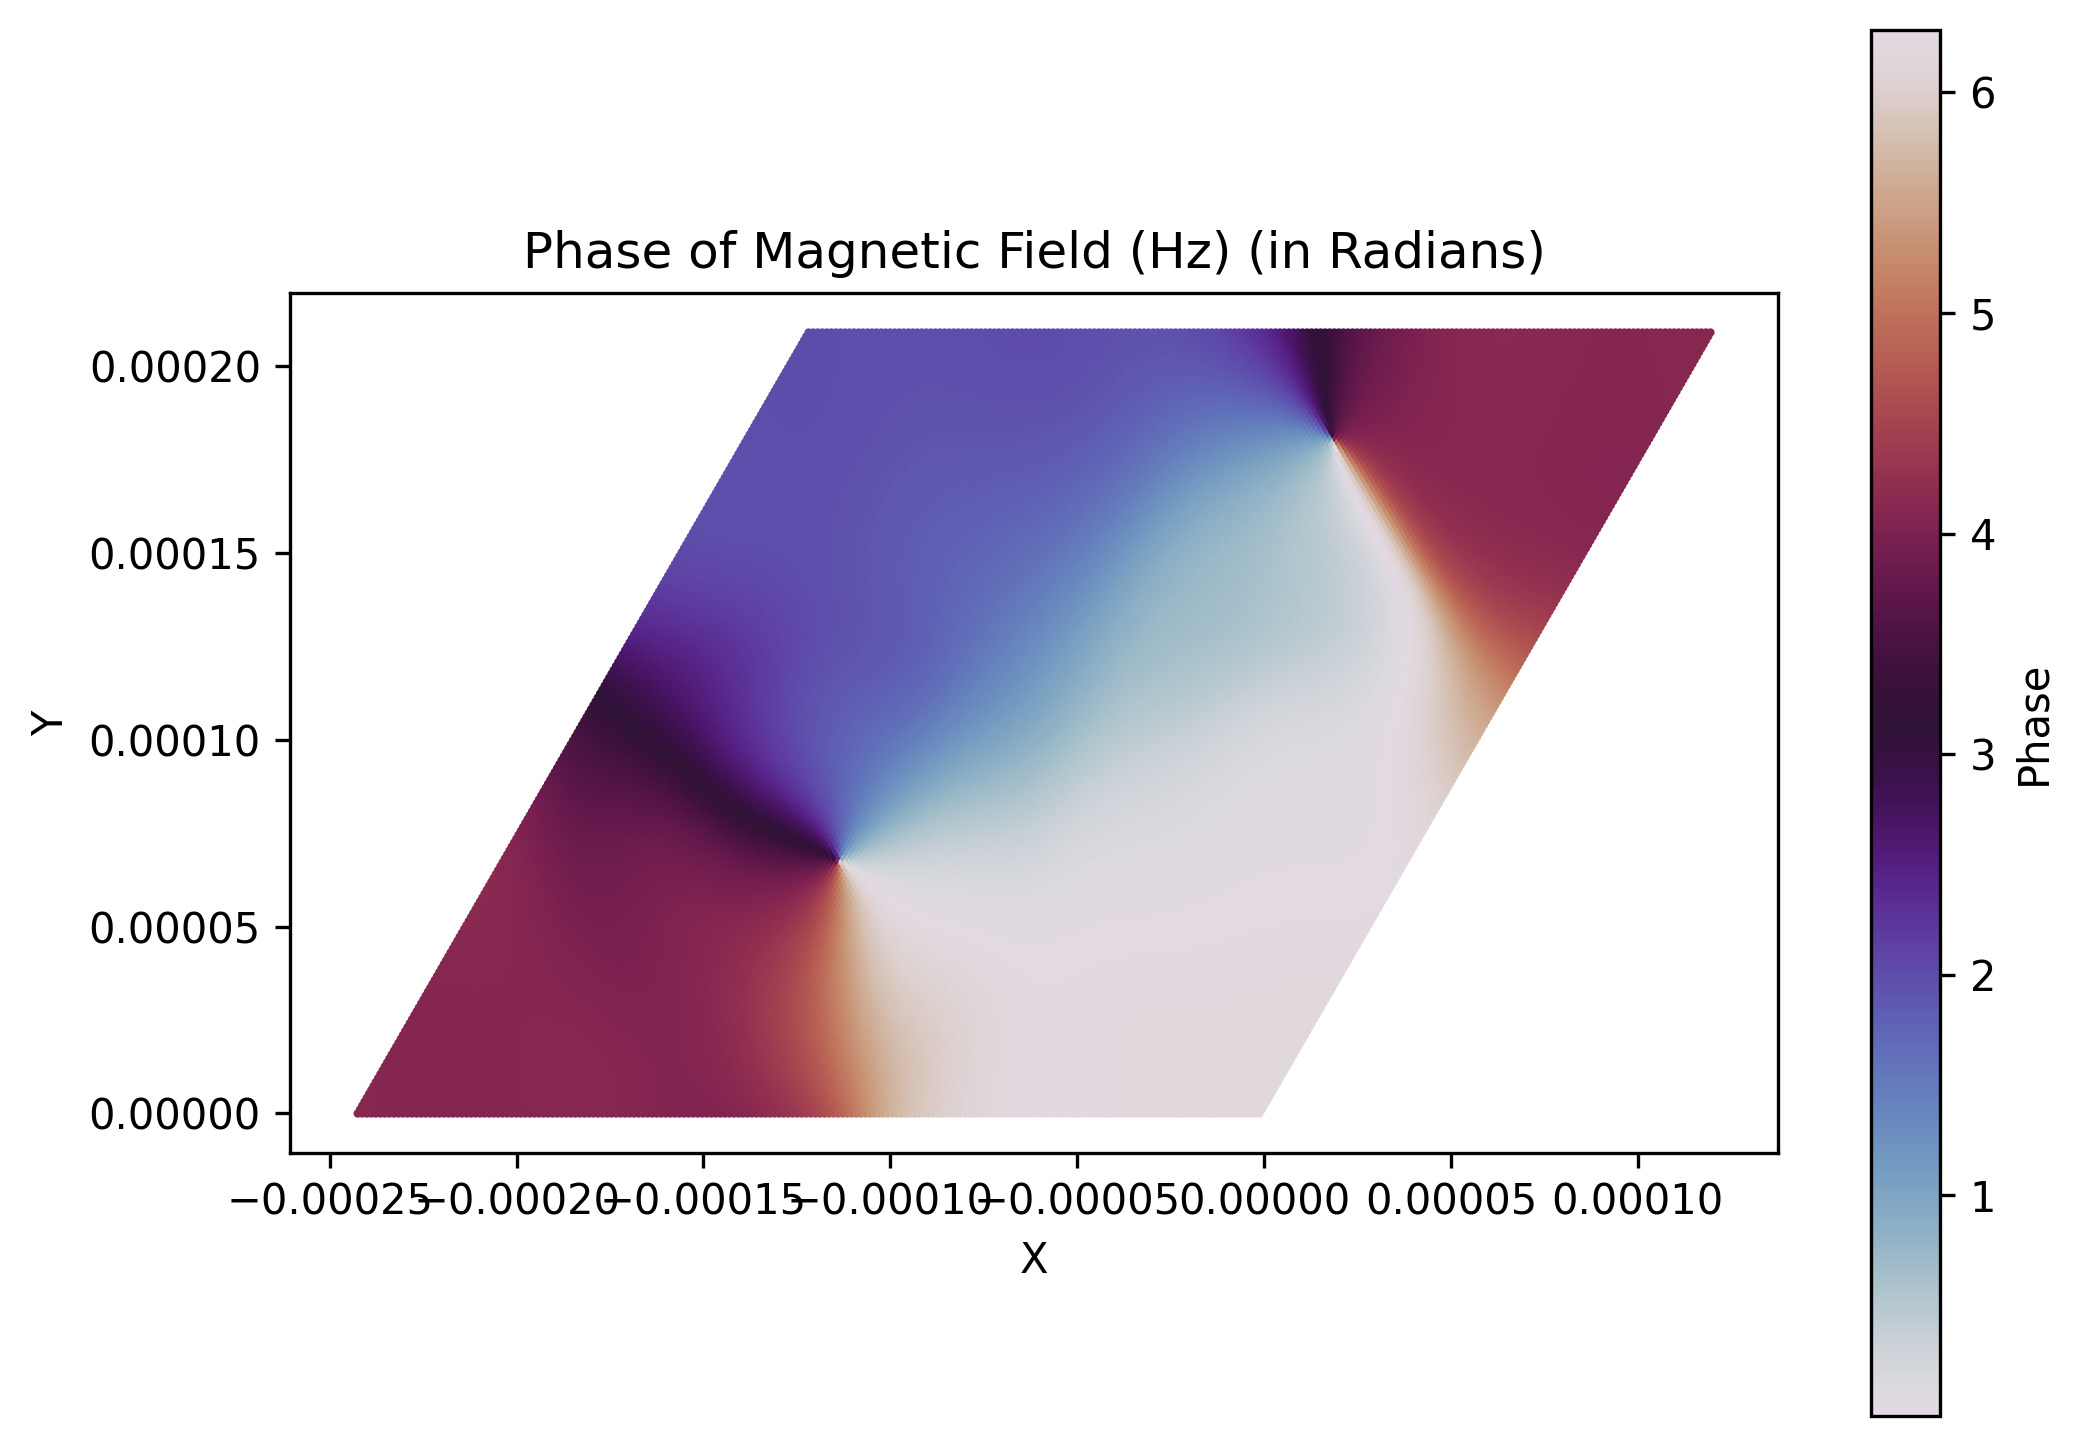

In [7]:
Hz_k1, Hz_k2, Hz_k1_2, xi, yi, E_parellel_k1, E_parellel_k1_2, Sx_k1, Sy_k1, Sx_k1_2, Sy_k1_2 = calculate_magnetic_field_and_plot(a, ng, B1, B2, KX_lin, KY_lin, H, H_2, G, Gx, Gy, X, Y, xi, yi, Mp_lin, Np_lin, dispe, inv_exy)

# Working (Delta_l, Symmetry Seperation, Rotation Angle)

In [ ]:
# from gpytorch.mlls import ExactMarginalLogLikelihood
# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from matplotlib.patches import Polygon as pltPolygon
# from ax import ParameterType, RangeParameter, SearchSpace, Experiment, OptimizationLoop
# from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
# from ax.modelbridge.registry import Models
# from ax.service.utils.report_utils import exp_to_df
# import torch
# import gc
# from datetime import datetime

# current_datetime = datetime.now()
# datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
# pathname = f'Images_Folder/{datetime_string}'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# a = 242.5e-6

# def create_search_space():
#     l_central = 0.25
#     max_delta = min(2*l_central, 2*(1/np.sqrt(3) - l_central))
#     return SearchSpace(
#         parameters=[
#             RangeParameter(
#                 name='delta_l',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=0,
#                 upper=max_delta
#             ),
#             RangeParameter(
#                 name='symmetry_separation',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=-0.2 * a,
#                 upper=0.2 * a
#             ),
#             RangeParameter(
#                 name='rotation_angle',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=-np.pi/3,
#                 upper=np.pi/3
#             )
#         ]
#     )

# def objective_evaluation(parameterization, fixed_sides):
#     l_central = 0.25
#     delta_l = parameterization.get('delta_l')
#     symmetry_separation = parameterization.get('symmetry_separation')
#     rotation_angle = parameterization.get('rotation_angle')
    
#     # Calculate l1 and l2 from delta_l
#     l1_ratio = l_central - (delta_l/2)
#     l2_ratio = l_central + (delta_l/2)
    
#     # Use fixed_sides instead of parameterization.get('number_of_sides')
#     number_of_sides = fixed_sides
    
#     a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5e-6, ng=3)
#     n = 3
#     radius = 2 * np.pi / a * (2 / 3)
#     kx_center_K = 2 * np.pi / a * (1 / 3)
#     ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))
#     vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
#     vertices_1 = np.array(vertices_1)
#     vertices_1 = np.vstack((vertices_1, vertices_1[0]))

#     kx_center_K_prime = 2 * np.pi / a * (2 / 3)
#     ky_center_K_prime = 0
#     vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
#     vertices_2 = np.array(vertices_2)
#     vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
#     l1, l2 = initialize_hole_parameters(a, l1_ratio, l2_ratio)
#     unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
#         a, l1, l2, number_of_sides=number_of_sides, polygon_with_radius=True,
#         symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle, rotation_angle_2=-rotation_angle
#     )
    
#     xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit)
    
#     khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
    
#     khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)

#     N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, central_frequency, gap_at_K_point = eigenvalue_calculation_and_plotting(
#         a, ng, B1, B2, khi_G_Gp
#     )

#     N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(
#         a, numG, N_BZ=25, band_index=1
#     )

#     if relative_band_gap == 0:
#         return {"objective": 1e6}

#     F, H, dispe = compute_berry_curvature(
#         band_index, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, N_BZ,
#         Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG
#     )
#     chern_K, chern_K_prime = chern_number_calculation_polygon_area(
#         F, KX, KY, a, del_S, vertices_1, vertices_2, kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime
#     )

#     topological_criterion = (100 * relative_band_gap) * np.abs(chern_K)
#     # Set up directories
#     path_structure = pathname + f'/Structure_Images/structure_{number_of_sides}sides'
#     path_band = pathname + f'/Band_Gap_Images/band_gap_{number_of_sides}sides'
#     path_chern = pathname + f'/Chern_Number_Images/chern_number_{number_of_sides}sides'
#     path_variables = f'Variables_folder/{datetime_string}' + f'/variables_{number_of_sides}sides'
#     os.makedirs(path_structure, exist_ok=True)
#     os.makedirs(path_band, exist_ok=True)
#     os.makedirs(path_chern, exist_ok=True)
#     os.makedirs(path_variables, exist_ok=True)
#     iteration = len(os.listdir(path_structure))
#     iteration = iteration + 1
    
#     plt.figure(figsize=(8, 6), dpi=300)
#     plt.axes().set_aspect(1)
#     plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
#     plt.xlabel('x / a')
#     plt.ylabel('y / a')
#     plt.colorbar(label=r'$1 / \epsilon(x, y)$')
#     plt.title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
#     plt.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
#     if iteration < 10:
#         plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
#     else: 
#         plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
#     plt.close()
    
#     dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
#     # Plotting the band structure
#     plt.figure(figsize=(8, 6), dpi=300)
#     ax1 = plt.gca()
#     for u in range(7):
#         plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
#         if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
#             rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
#             rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
#             ax1.add_patch(rect)
            
#     # Labeling the axes+
#     plt.title(f'Band Structure for Structure {iteration}')
#     plt.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
#     plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
#     plt.ylabel('Frequency (THz)', fontsize=16)
#     plt.xlabel('Wavevector', fontsize=16)
#     plt.ylim([0, 0.7])
#     plt.xlim([0, N1+N2+N3])
#     plt.grid(True)
#     if iteration < 10:
#         plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
#     else:
#         plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
#     plt.close()

#     plt.figure(figsize=(8, 6), dpi=300)
#     plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
#                                    KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
#                cmap='bwr', aspect='auto')
    
#     # Create a polygon patch for the region
#     polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
#     plt.gca().add_patch(polygon_patch_1)
#     plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
#     # Create a polygon patch for the region
#     polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
#     plt.gca().add_patch(polygon_patch_2)
#     plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
#     plt.xlabel('kx a/2π')
#     plt.ylabel('ky a/2π')
#     plt.colorbar()
#     plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
#     plt.title(f'Chern Number at Iteration {iteration}')
#     plt.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
#     if iteration < 10:
#         plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
#     else:
#         plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
#     plt.close()
    
#     variables = {
#         'l1_ratio': float(l1_ratio),
#         'l2_ratio': float(l2_ratio),
#         'delta_l': float(delta_l), 
#         'symmetry_separation': float(symmetry_separation),
#         'rotation_angle': float(rotation_angle),
#         'topological_criterion': float(topological_criterion),
#         'chern_K': float(chern_K),
#         'relative_band_gap': float(relative_band_gap),
#         'band_gap': float(band_gap),
#         'central_frequency': float(central_frequency)
#     }

#     if iteration < 10:
#         with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
#             json.dump(variables, f)
#     else:
#         with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
#             json.dump(variables, f)
#     print(f"l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, number_of_sides: {number_of_sides}, symmetry_separation: {symmetry_separation}, rotation_angle: {rotation_angle}")
#     print(f"Topological Criterion: {topological_criterion}, Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, Relative Band Gap: {relative_band_gap}")

#     # Return the objective value (minimize by returning a negative of the criterion)
#     return {"objective": -topological_criterion if topological_criterion > 0.1 else 1e6}

# def run_optimization():
#     polygon_sides = [3, 120]
#     all_results = {}
#     for sides in polygon_sides:
#         print(f"\nOptimizing for {sides}-sided polygon")
        
#         experiment = Experiment(
#             name=f'topological_optimization_{sides}_sides',
#             search_space=create_search_space()
#         )
        
#         generation_strategy = GenerationStrategy([
#             GenerationStep(model=Models.SOBOL, num_trials=150, max_parallelism=5),
#             GenerationStep(model=Models.GPEI, num_trials=350, max_parallelism=5)
#         ])
#         l_central = 0.25
#         max_delta = min(2*l_central, 2*(1/np.sqrt(3) - l_central))
        
#         optimization_loop = OptimizationLoop.with_evaluation_function(
#             experiment_name=f'topological_optimization_{sides}_sides',
#             parameters=[
#                 {
#                     "name": "delta_l",
#                     "type": "range",
#                     "bounds": [0, max_delta],
#                     "value_type": "float"
#                 },
#                 {
#                     "name": "symmetry_separation",
#                     "type": "range",
#                     "bounds": [-0.2 * a, 0.2 * a],
#                     "value_type": "float"
#                 },
#                 {
#                     "name": "rotation_angle",
#                     "type": "range",
#                     "bounds": [-np.pi/3, np.pi/3],
#                     "value_type": "float"
#                 }
#             ],
#             evaluation_function=lambda p: objective_evaluation(p, sides),
#             minimize=True,
#             objective_name='objective',
#             generation_strategy=generation_strategy,
#             total_trials=500,
#             random_seed=17
#         )
        
#         results = optimization_loop.full_run()
#         all_results[sides] = results
        
#         # Save results for this polygon
#         # with open(f'Results/optimization_results_{sides}sides_{datetime_string}.json', 'w') as f:
#         #     json.dump(results.__dict__, f)  # Convert results to string for JSON serialization
            
#     return all_results

# results = run_optimization()

# Working (3 sides, L1, L2, Rotation_1, Rotation_2)

In [ ]:
# from gpytorch.mlls import ExactMarginalLogLikelihood
# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle, Polygon as pltPolygon
# from ax import ParameterType, RangeParameter, SearchSpace, Experiment, OptimizationLoop
# from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
# from ax.modelbridge.registry import Models
# import torch
# from datetime import datetime
# import shapely

# current_datetime = datetime.now()
# datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
# pathname = f'Images_Folder/{datetime_string}'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# a = 242.5e-6

# def create_search_space():
#     return SearchSpace(
#         parameters=[
#             RangeParameter(
#                 name='l1',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=0.05,
#                 upper=0.95
#             ),
#             RangeParameter(
#                 name='l2',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=0.05,
#                 upper=0.95
#             ),
#             RangeParameter(
#                 name='rotation_angle_1',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=-np.pi/3,
#                 upper=np.pi/3
#             ),
#             RangeParameter(
#                 name='rotation_angle_2',
#                 parameter_type=ParameterType.FLOAT,
#                 lower=-np.pi/3,
#                 upper=np.pi/3
#             )
#         ]
#     )

# def objective_evaluation(parameterization, fixed_sides):
#     l1_ratio = parameterization.get('l1')
#     l2_ratio = parameterization.get('l2')
#     rotation_angle_1 = parameterization.get('rotation_angle_1')
#     rotation_angle_2 = parameterization.get('rotation_angle_2')
    
#     number_of_sides = fixed_sides
#     number_of_sides_1 = fixed_sides
#     number_of_sides_2 = fixed_sides
#     symmetry_separation = 0.0
    
#     a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5e-6, ng=3)
#     n = 3
#     radius = 2 * np.pi / a * (2 / 3)
#     kx_center_K = 2 * np.pi / a * (1 / 3)
#     ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))
#     vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
#     vertices_1 = np.array(vertices_1)
#     vertices_1 = np.vstack((vertices_1, vertices_1[0]))

#     kx_center_K_prime = 2 * np.pi / a * (2 / 3)
#     ky_center_K_prime = 0
#     vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
#     vertices_2 = np.array(vertices_2)
#     vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
#     l1, l2 = initialize_hole_parameters(a, l1_ratio = l1_ratio, l2_ratio = l2_ratio)

#     try:
#         # unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=300, number_of_sides_2=300, 
#         #                                                 polygon_with_radius=True, is_ellipse_1=False, is_ellipse_2=False,
#         #                                                 symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
        
#         unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(a, l1, l2, number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2, 
#                                                         polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
#                                                         symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
#     except shapely.errors.GEOSException:
#         print("Error in creating geometry - Moving on to next iteration")
#         return {"objective": 1e6}

#     xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=50)
#     khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
#     khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
#     # inv_exy = reconstruct_inverse_dielectric_function(a, ng, xi, yi, B1, B2, khiG, M_lin, N_lin)
#     N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
#     N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=25, band_index=1)
#     n = band_index

#     if relative_band_gap == 0:
#         return {"objective": 1e6}

#     F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
    
#     chern_K, chern_K_prime = chern_number_calculation_polygon_area(
#         F, KX, KY, a, del_S, vertices_1, vertices_2, kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

#     F_k1, F_k2 = berry_curvature(a, F, KX, KY, KX_lin, KY_lin)
    
#     topological_criterion = (relative_band_gap) * np.abs(F_k1)
#     # Set up directories
#     path_structure = pathname + f'/Structure_Images/structure_{number_of_sides}sides'
#     path_band = pathname + f'/Band_Gap_Images/band_gap_{number_of_sides}sides'
#     path_chern = pathname + f'/Chern_Number_Images/chern_number_{number_of_sides}sides'
#     path_variables = f'Variables_folder/{datetime_string}' + f'/variables_{number_of_sides}sides'
#     os.makedirs(path_structure, exist_ok=True)
#     os.makedirs(path_band, exist_ok=True)
#     os.makedirs(path_chern, exist_ok=True)
#     os.makedirs(path_variables, exist_ok=True)
#     iteration = len(os.listdir(path_structure))
#     iteration = iteration + 1
    
#     plt.figure(figsize=(8, 6), dpi=300)
#     plt.axes().set_aspect(1)
#     plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
#     plt.xlabel('x / a')
#     plt.ylabel('y / a')
#     plt.colorbar(label=r'$1 / \epsilon(x, y)$')
#     plt.title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
#     plt.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
#     if iteration < 10:
#         plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
#     else: 
#         plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
#     plt.close()
    
#     dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
#     # Plotting the band structure
#     plt.figure(figsize=(8, 6), dpi=300)
#     ax1 = plt.gca()
#     for u in range(7):
#         plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
#         if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
#             rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
#             rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
#             ax1.add_patch(rect)
            
#     # Labeling the axes+
#     plt.title(f'Band Structure for Structure {iteration}')
#     plt.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
#     plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
#     plt.ylabel('Frequency (THz)', fontsize=16)
#     plt.xlabel('Wavevector', fontsize=16)
#     plt.ylim([0, 0.7])
#     plt.xlim([0, N1+N2+N3])
#     plt.grid(True)
#     if iteration < 10:
#         plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
#     else:
#         plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
#     plt.close()

#     plt.figure(figsize=(8, 6), dpi=300)
#     plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
#                                    KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
#                cmap='bwr', aspect='auto')
    
#     # Create a polygon patch for the region
#     polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
#     plt.gca().add_patch(polygon_patch_1)
#     plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
#     # Create a polygon patch for the region
#     polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
#     plt.gca().add_patch(polygon_patch_2)
#     plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
#     plt.xlabel('kx a/2π')
#     plt.ylabel('ky a/2π')
#     plt.colorbar()
#     plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
#     plt.title(f'Chern Number at Iteration {iteration}')
#     plt.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
#     if iteration < 10:
#         plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
#     else:
#         plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
#     plt.close()
    
#     variables = {
#         'l1_ratio': float(l1_ratio),
#         'l2_ratio': float(l2_ratio),
#         'rotation_angle_1': float(rotation_angle_1),
#         'rotation_angle_2': float(rotation_angle_2),
#         'topological_criterion': float(topological_criterion),
#         'chern_K': float(chern_K),
#         'berry_curvature_K': float(F_k1),
#         'relative_band_gap': float(relative_band_gap),
#         'band_gap': float(band_gap),
#         'central_frequency': float(dirac_freq)
#     }

#     if iteration < 10:
#         with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
#             json.dump(variables, f)
#     else:
#         with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
#             json.dump(variables, f)
#     print(f"l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, number_of_sides: {number_of_sides}, rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
#     print(f"Berry Curvature at K: {F_k1}, Berry Curvature at K': {F_k2}, Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, Relative Band Gap: {relative_band_gap}")
#     print(f"Topological Criterion: {topological_criterion}")

#     # Return the objective value (minimize by returning a negative of the criterion)
#     return {"objective": -topological_criterion if topological_criterion > 0.1 else 1e6}

# def run_optimization():
#     polygon_sides = [3]  # Keeping it fixed to 3 sides for now
#     all_results = {}
#     for sides in polygon_sides:
#         print(f"\nOptimizing for {sides}-sided polygon")
        
#         experiment = Experiment(
#             name=f'topological_optimization_{sides}_sides',
#             search_space=create_search_space()
#         )
        
#         generation_strategy = GenerationStrategy([
#             GenerationStep(model=Models.SOBOL, num_trials=150, max_parallelism=5),
#             GenerationStep(model=Models.GPEI, num_trials=150, max_parallelism=5)
#         ])
        
#         optimization_loop = OptimizationLoop.with_evaluation_function(
#             experiment_name=f'topological_optimization_{sides}_sides',
#             parameters=[
#                 {
#                     "name": "l1",
#                     "type": "range",
#                     "bounds": [0.05, 0.95],
#                     "value_type": "float"
#                 },
#                 {
#                     "name": "l2",
#                     "type": "range",
#                     "bounds": [0.05, 0.95],
#                     "value_type": "float"
#                 },
#                 {
#                     "name": "rotation_angle_1",
#                     "type": "range",
#                     "bounds": [-np.pi/3, np.pi/3],
#                     "value_type": "float"
#                 },
#                 {
#                     "name": "rotation_angle_2",
#                     "type": "range",
#                     "bounds": [-np.pi/3, np.pi/3],
#                     "value_type": "float"
#                 }
#             ],
#             evaluation_function=lambda p: objective_evaluation(p, sides),
#             minimize=True,
#             objective_name='objective',
#             generation_strategy=generation_strategy,
#             total_trials=300,
#         )
        
#         results = optimization_loop.full_run()
#         all_results[sides] = results
        
#     return all_results

# results = run_optimization()


# Particle Swarm Optimization - 3 Sides, l1, l2, Rotation1, Rotation2

## Decreasing w, Adaptive c1,c2

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as pltPolygon
from ax import ParameterType, RangeParameter, SearchSpace, Experiment, OptimizationLoop
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
import torch
from datetime import datetime
import shapely

# Get current datetime and set paths for saving images and variables
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
pathname = f'Images_Folder/{datetime_string}'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = 242.5e-6

def create_search_space():
    return SearchSpace(
        parameters=[
            RangeParameter(
                name='l1',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='l2',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='rotation_angle_1',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            ),
            RangeParameter(
                name='rotation_angle_2',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            )
        ]
    )

def objective_evaluation(parameterization, fixed_sides):
    # Extract parameters from dictionary
    l1_ratio = parameterization.get('l1')
    l2_ratio = parameterization.get('l2')
    rotation_angle_1 = parameterization.get('rotation_angle_1')
    rotation_angle_2 = parameterization.get('rotation_angle_2')
    
    number_of_sides = fixed_sides
    number_of_sides_1 = fixed_sides
    number_of_sides_2 = fixed_sides
    symmetry_separation = 0.0
    
    # Initialize lattice and polygon parameters (assumed defined elsewhere)
    a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5e-6, ng=3)
    n = 3
    radius = 2 * np.pi / a * (2 / 3)
    kx_center_K = 2 * np.pi / a * (1 / 3)
    ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))
    vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
    vertices_1 = np.array(vertices_1)
    vertices_1 = np.vstack((vertices_1, vertices_1[0]))

    kx_center_K_prime = 2 * np.pi / a * (2 / 3)
    ky_center_K_prime = 0
    vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
    vertices_2 = np.array(vertices_2)
    vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
    l1, l2 = initialize_hole_parameters(a, l1_ratio=l1_ratio, l2_ratio=l2_ratio)

    try:
        unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
            a, l1, l2, number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2, 
            polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
            symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
    except shapely.errors.GEOSException:
        print("Error in creating geometry - Moving on to next iteration")
        return {"objective": 1e6}

    xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=50)
    khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
    khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
    N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
    N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=25, band_index=1)
    n = band_index

    if relative_band_gap == 0:
        return {"objective": 1e6}

    F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, 
                                                  N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
    
    chern_K, chern_K_prime = chern_number_calculation_polygon_area(
        F, KX, KY, a, del_S, vertices_1, vertices_2, 
        kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

    F_k1, F_k2 = berry_curvature(a, F, KX, KY, KX_lin, KY_lin)
    
    # topological_criterion = (relative_band_gap**2) * np.abs(F_k1) * 1e9
    topological_criterion = (relative_band_gap**2) * np.abs(chern_K) * 1e2
    
    # Set up directories for saving images and variables
    path_structure = pathname + f'/Structure_Images/structure_{number_of_sides}sides'
    path_band = pathname + f'/Band_Gap_Images/band_gap_{number_of_sides}sides'
    path_chern = pathname + f'/Chern_Number_Images/chern_number_{number_of_sides}sides'
    path_variables = f'Variables_folder/{datetime_string}' + f'/variables_{number_of_sides}sides'
    os.makedirs(path_structure, exist_ok=True)
    os.makedirs(path_band, exist_ok=True)
    os.makedirs(path_chern, exist_ok=True)
    os.makedirs(path_variables, exist_ok=True)
    iteration = len(os.listdir(path_structure))
    iteration = iteration + 1
    
    # Plot spatial dielectric function
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
    plt.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
    if iteration < 10:
        plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    else: 
        plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot band structure
    dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    plt.figure(figsize=(8, 6), dpi=300)
    ax1 = plt.gca()
    for u in range(7):
        plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
            ax1.add_patch(rect)
    plt.title(f'Band Structure for Structure {iteration}')
    plt.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
    plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
    plt.ylabel('Frequency (THz)', fontsize=16)
    plt.xlabel('Wavevector', fontsize=16)
    plt.ylim([0, 0.7])
    plt.xlim([0, N1+N2+N3])
    plt.grid(True)
    if iteration < 10:
        plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot Berry curvature and Chern number
    plt.figure(figsize=(8, 6), dpi=300)
    plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
                                   KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
               cmap='bwr', aspect='auto')
    polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
    plt.gca().add_patch(polygon_patch_1)
    plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
    plt.gca().add_patch(polygon_patch_2)
    plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
    plt.xlabel('kx a/2π')
    plt.ylabel('ky a/2π')
    plt.colorbar()
    plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    plt.title(f'Chern Number at Iteration {iteration}')
    plt.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
    if iteration < 10:
        plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    plt.close()
    
    # Save variables
    variables = {
        'l1_ratio': float(l1_ratio),
        'l2_ratio': float(l2_ratio),
        'rotation_angle_1': float(rotation_angle_1),
        'rotation_angle_2': float(rotation_angle_2),
        'topological_criterion': float(topological_criterion),
        'chern_K': float(chern_K),
        'berry_curvature_K': float(F_k1),
        'relative_band_gap': float(relative_band_gap),
        'band_gap': float(band_gap),
        'central_frequency': float(dirac_freq)
    }
    if iteration < 10:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    else:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
            
    print(f"l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, number_of_sides: {number_of_sides}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
    print(f"Berry Curvature at K: {F_k1}, Berry Curvature at K': {F_k2}, "
          f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, "
          f"Relative Band Gap: {relative_band_gap}")
    print(f"Topological Criterion: {topological_criterion}")

    # Return the objective value (minimize by returning a negative of the criterion)
    return {"objective": -topological_criterion if topological_criterion > 0.0 else 1e6}

# Wrapper for PSO: converts a vector x into the dictionary required by objective_evaluation.
def objective_function(x, fixed_sides):
    parameterization = {
        'l1': float(x[0]),
        'l2': float(x[1]),
        'rotation_angle_1': float(x[2]),
        'rotation_angle_2': float(x[3])
    }
    result = objective_evaluation(parameterization, fixed_sides)
    return result["objective"]

# Particle Swarm Optimization with adaptive parameters based on relative improvement
# and real-time visualization of the best objective over iterations.
def particle_swarm_optimization(func, bounds, fixed_sides, num_particles=20, max_iter=300):
    dim = bounds.shape[0]
    # Initialize particles randomly within the bounds.
    particles = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    # Evaluate initial positions.
    pbest = np.copy(particles)
    pbest_obj = np.array([func(particles[i], fixed_sides) for i in range(num_particles)])
    gbest_index = np.argmin(pbest_obj)
    gbest = pbest[gbest_index].copy()
    gbest_obj = pbest_obj[gbest_index]
    
    # Set initial PSO parameters.
    w_max = 0.9
    w_min = 0.4
    c1_max = 4.0
    c1_min = 1.0
    c2_max = 4.0
    c2_min = 1.0
    
    
    prev_gbest_obj = 0  # Initialize for adaptive parameter update.
    
    # Set up interactive plot for real-time visualization.
    plt.ion()
    fig, ax = plt.subplots()
    best_obj_history = []
    line, = ax.plot([], [], 'b-', marker='o')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Best Objective')
    ax.set_title('Real-Time PSO Objective Improvement')

    for iter in range(max_iter):
        # Compute relative improvement. We use an epsilon to avoid division by zero.
        eps = 1e-8
        relative_improvement = (prev_gbest_obj - gbest_obj) / (abs(prev_gbest_obj) + eps)
        # Ensure the improvement is between 0 and 1.
        relative_improvement = max(0, min(relative_improvement, 1))
        # Adapt PSO parameters based on the relative improvement.
        w = w_max - (w_max - w_min) * (iter/max_iter)
        # c1 = c1_max - (c1_max - c1_min)*relative_improvement
        # c2 = c2_min + (c2_max - c2_min)*relative_improvement
        c1 = 2.0
        c2 = 2.0
        
        prev_gbest_obj = gbest_obj  # Update for next iteration

        print(f"--- Iteration {iter+1}/{max_iter} ---")
        print(f"Adaptive parameters: w={w:.4f}, c1={c1:.4f}, c2={c2:.4f}, Relative Improvement={relative_improvement:.4f}")

        # Update each particle.
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest[i] - particles[i]) +
                             c2 * r2 * (gbest - particles[i]))
            particles[i] = particles[i] + velocities[i]
            # Enforce the bounds.
            for d in range(dim):
                if particles[i, d] < bounds[d, 0]:
                    particles[i, d] = bounds[d, 0]
                    velocities[i, d] = 0
                if particles[i, d] > bounds[d, 1]:
                    particles[i, d] = bounds[d, 1]
                    velocities[i, d] = 0
            obj_val = func(particles[i], fixed_sides)
            # Print progress for each particle.
            print(f"Iteration {iter+1}/{max_iter}, Particle {i+1}/{num_particles}, Position: {particles[i]}, Objective: {obj_val:.4f}")
            if obj_val < pbest_obj[i]:
                pbest[i] = particles[i].copy()
                pbest_obj[i] = obj_val
                if obj_val < gbest_obj:
                    gbest = particles[i].copy()
                    gbest_obj = obj_val

        print(f"Best Objective after iteration {iter+1}: {gbest_obj:.4f}\n")
        # prev_gbest_obj = gbest_obj  # Update for next iteration

        # Update real-time plot.
        best_obj_history.append(gbest_obj)
        line.set_data(np.arange(len(best_obj_history)), best_obj_history)
        ax.relim()
        ax.autoscale_view()
        plt.draw()
        plt.pause(0.1)
        
    plt.ioff()
    plt.show()

    return gbest, gbest_obj

def run_pso_optimization():
    # We keep the polygon side fixed to 3, as in the original code.
    polygon_sides = [3]
    all_results = {}
    for sides in polygon_sides:
        print(f"\nOptimizing for {sides}-sided polygon using Particle Swarm Optimization")
        bounds = np.array([
            [0.05, 0.95],           # l1
            [0.05, 0.95],           # l2
            [-np.pi/3, np.pi/3],     # rotation_angle_1
            [-np.pi/3, np.pi/3]      # rotation_angle_2
        ])
        best_params, best_obj = particle_swarm_optimization(
            objective_function, bounds, fixed_sides=sides, num_particles=20, max_iter=50)
        all_results[sides] = {"best_parameters": best_params.tolist(), "best_objective": float(best_obj)}
    return all_results

results = run_pso_optimization()


## Decreasing w, Adaptive c1,c2 (Parallel - Didn't work Well)

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as pltPolygon
from ax import ParameterType, RangeParameter, SearchSpace, Experiment, OptimizationLoop
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
import torch
from datetime import datetime
import shapely

# For parallelization
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed

# Global usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Get current datetime and set paths for saving images and variables
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
pathname = f'Images_Folder/{datetime_string}'
a = 242.5e-6

def create_search_space():
    return SearchSpace(
        parameters=[
            RangeParameter(
                name='l1',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='l2',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='rotation_angle_1',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            ),
            RangeParameter(
                name='rotation_angle_2',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            )
        ]
    )

def objective_evaluation(parameterization, fixed_sides):
    # Extract parameters from dictionary
    l1_ratio = parameterization.get('l1')
    l2_ratio = parameterization.get('l2')
    rotation_angle_1 = parameterization.get('rotation_angle_1')
    rotation_angle_2 = parameterization.get('rotation_angle_2')
    
    number_of_sides = fixed_sides
    number_of_sides_1 = fixed_sides
    number_of_sides_2 = fixed_sides
    symmetry_separation = 0.0
    
    # Initialize lattice and polygon parameters (assumed defined elsewhere)
    a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5e-6, ng=3)
    n = 3
    radius = 2 * np.pi / a * (2 / 3)
    kx_center_K = 2 * np.pi / a * (1 / 3)
    ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))
    vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
    vertices_1 = np.array(vertices_1)
    vertices_1 = np.vstack((vertices_1, vertices_1[0]))

    kx_center_K_prime = 2 * np.pi / a * (2 / 3)
    ky_center_K_prime = 0
    vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
    vertices_2 = np.array(vertices_2)
    vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
    l1, l2 = initialize_hole_parameters(a, l1_ratio=l1_ratio, l2_ratio=l2_ratio)

    try:
        unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
            a, l1, l2, number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2, 
            polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
            symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
    except shapely.errors.GEOSException:
        print("Error in creating geometry - Moving on to next iteration")
        return {"objective": 1e6}

    xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=50)
    khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
    khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
    N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
    N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=25, band_index=1)
    n = band_index

    if relative_band_gap == 0:
        return {"objective": 1e6}

    F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, 
                                                  N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
    
    chern_K, chern_K_prime = chern_number_calculation_polygon_area(
        F, KX, KY, a, del_S, vertices_1, vertices_2, 
        kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

    F_k1, F_k2 = berry_curvature(a, F, KX, KY, KX_lin, KY_lin)
    
    # topological_criterion = (relative_band_gap**2) * np.abs(F_k1) * 1e9
    topological_criterion = (relative_band_gap**2) * np.abs(chern_K) * 1e2
    
    # Set up directories for saving images and variables
    path_structure = pathname + f'/Structure_Images/structure_{number_of_sides}sides'
    path_band = pathname + f'/Band_Gap_Images/band_gap_{number_of_sides}sides'
    path_chern = pathname + f'/Chern_Number_Images/chern_number_{number_of_sides}sides'
    path_variables = f'Variables_folder/{datetime_string}' + f'/variables_{number_of_sides}sides'
    os.makedirs(path_structure, exist_ok=True)
    os.makedirs(path_band, exist_ok=True)
    os.makedirs(path_chern, exist_ok=True)
    os.makedirs(path_variables, exist_ok=True)
    iteration = len(os.listdir(path_structure))
    iteration = iteration + 1
    
    # # Plot spatial dielectric function
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.axes().set_aspect(1)
    # plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    # plt.xlabel('x / a')
    # plt.ylabel('y / a')
    # plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    # plt.title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
    # plt.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
    # if iteration < 10:
    #     plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    # else: 
    #     plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    # plt.close()
    
    # # Plot band structure
    # dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    # plt.figure(figsize=(8, 6), dpi=300)
    # ax1 = plt.gca()
    # for u in range(7):
    #     plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
    #     if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
    #         rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
    #         rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
    #         ax1.add_patch(rect)
    # plt.title(f'Band Structure for Structure {iteration}')
    # plt.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
    # plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
    # plt.ylabel('Frequency (THz)', fontsize=16)
    # plt.xlabel('Wavevector', fontsize=16)
    # plt.ylim([0, 0.7])
    # plt.xlim([0, N1+N2+N3])
    # plt.grid(True)
    # if iteration < 10:
    #     plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    # else:
    #     plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    # plt.close()
    
    # # Plot Berry curvature and Chern number
    # plt.figure(figsize=(8, 6), dpi=300)
    # plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
    #                                KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
    #            cmap='bwr', aspect='auto')
    # polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
    # plt.gca().add_patch(polygon_patch_1)
    # plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    # polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
    # plt.gca().add_patch(polygon_patch_2)
    # plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
    # plt.xlabel('kx a/2π')
    # plt.ylabel('ky a/2π')
    # plt.colorbar()
    # plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    # plt.title(f'Chern Number at Iteration {iteration}')
    # plt.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
    # if iteration < 10:
    #     plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    # else:
    #     plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    # plt.close()
    # -------------------------------
    # Plot spatial dielectric function
    # -------------------------------
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.set_aspect(1)
    scatter_obj = ax.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    ax.set_xlabel('x / a')
    ax.set_ylabel('y / a')
    fig.colorbar(scatter_obj, ax=ax, label=r'$1 / \epsilon(x, y)$')
    ax.set_title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
    fig.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
    if iteration < 10:
        fig.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    else:
        fig.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    plt.close(fig)

    # -------------------------------
    # Plot band structure
    # -------------------------------
    dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for u in range(7):
        ax.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height,
                            facecolor='lightblue')
            ax.add_patch(rect)
    ax.set_title(f'Band Structure for Structure {iteration}')
    fig.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
    ax.set_xticks([0, N1, N1 + N2, N1 + N2 + N3])
    ax.set_xticklabels(['G', 'M', 'K', 'G'])
    ax.set_ylabel('Frequency (THz)', fontsize=16)
    ax.set_xlabel('Wavevector', fontsize=16)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([0, N1+N2+N3])
    ax.grid(True)
    if iteration < 10:
        fig.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    else:
        fig.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    plt.close(fig)

    # -------------------------------
    # Plot Berry curvature and Chern number
    # -------------------------------
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    im = ax.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
                                        KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
                cmap='bwr', aspect='auto')
    # Add the first polygon patch and label 'K'
    ax.add_patch(pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, 
                            edgecolor='red', linewidth=1))
    ax.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05,
            'K', color='red', fontsize=12)
    # Add the second polygon patch and label "K'"
    ax.add_patch(pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, 
                            edgecolor='blue', linewidth=1))
    ax.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05,
            "K'", color='blue', fontsize=12)
    ax.set_xlabel('kx a/2π')
    ax.set_ylabel('ky a/2π')
    fig.colorbar(im, ax=ax)
    im.set_clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    ax.set_title(f'Chern Number at Iteration {iteration}')
    fig.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
    if iteration < 10:
        fig.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    else:
        fig.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    plt.close(fig)
    
    # Save variables
    variables = {
        'l1_ratio': float(l1_ratio),
        'l2_ratio': float(l2_ratio),
        'rotation_angle_1': float(rotation_angle_1),
        'rotation_angle_2': float(rotation_angle_2),
        'topological_criterion': float(topological_criterion),
        'chern_K': float(chern_K),
        'berry_curvature_K': float(F_k1),
        'relative_band_gap': float(relative_band_gap),
        'band_gap': float(band_gap),
        'central_frequency': float(dirac_freq)
    }
    if iteration < 10:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    else:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
            
    print(f"l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, number_of_sides: {number_of_sides}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
    print(f"Berry Curvature at K: {F_k1}, Berry Curvature at K': {F_k2}, "
          f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, "
          f"Relative Band Gap: {relative_band_gap}")
    print(f"Topological Criterion: {topological_criterion}")

    # Return the objective value (minimize by returning a negative of the criterion)
    return {"objective": -topological_criterion if topological_criterion > 0.0 else 1e6}

# -----------------------------------------------------------------------------
# 3) Wrapper for PSO: converts a vector x -> dictionary, calls objective_evaluation
# -----------------------------------------------------------------------------
def objective_function(x, fixed_sides):
    """
    x is a numpy array of shape (4,), e.g. [l1, l2, rotation_angle_1, rotation_angle_2].
    fixed_sides is the number of polygon sides (like 3 in your example).
    """
    parameterization = {
        'l1': float(x[0]),
        'l2': float(x[1]),
        'rotation_angle_1': float(x[2]),
        'rotation_angle_2': float(x[3])
    }
    result = objective_evaluation(parameterization, fixed_sides)
    return result["objective"]


# -----------------------------------------------------------------------------
# 4) Parallel function evaluator
# -----------------------------------------------------------------------------
def pso_func_eval(func, particle, fixed_sides):
    """Helper to call the objective function with a single particle."""
    return func(particle, fixed_sides)

def parallel_eval(func, particles, fixed_sides):
    """
    Evaluate a list of particle positions in parallel using
    a thread pool (or you can use ProcessPoolExecutor).
    """
    num_particles = len(particles)
    num_cpus = multiprocessing.cpu_count()

    results = [None]*num_particles
    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        future_to_index = {
            executor.submit(pso_func_eval, func, particles[i], fixed_sides): i
            for i in range(num_particles)
        }
        for future in as_completed(future_to_index):
            i = future_to_index[future]
            results[i] = future.result()
    return np.array(results)


# -----------------------------------------------------------------------------
# 5) Particle Swarm Optimization with:
#    - Live 2D scatter of swarm (showing first two dimensions).
#    - Parallel evaluation of objective function each iteration.
# -----------------------------------------------------------------------------
def particle_swarm_optimization(func, bounds, fixed_sides,
                                num_particles=20, max_iter=300):
    """
    Particle Swarm Optimizer that:
      - Minimizes the objective function 'func'.
      - Does a live scatter plot of particles in 2D (dimensions 0 & 1).
      - Uses parallel evaluations each iteration to speed up expensive calls.
    """
    dim = bounds.shape[0]

    # Initialize particles randomly within the bounds.
    particles = np.random.uniform(low=bounds[:, 0],
                                  high=bounds[:, 1],
                                  size=(num_particles, dim))
    velocities = np.zeros((num_particles, dim))

    # Evaluate initial positions in parallel
    pbest = np.copy(particles)
    pbest_obj = parallel_eval(func, particles, fixed_sides)
    gbest_index = np.argmin(pbest_obj)  # Minimization
    gbest = pbest[gbest_index].copy()
    gbest_obj = pbest_obj[gbest_index]

    # Set initial PSO parameters
    w_max = 0.9
    w_min = 0.4
    c1_max = 2.0
    c1_min = 1.49445
    c2_max = 2.0
    c2_min = 1.49445

    prev_gbest_obj = 0.0

    # For real-time plots
    plt.ion()
    fig, (ax_swarm, ax_obj) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Real-Time PSO Progress", fontsize=16)

    # We store a scatter plot for the swarm, and a line for best_obj over iterations
    scatter = ax_swarm.scatter([], [], c=[], cmap='viridis')
    ax_swarm.set_title("Swarm in 2D (dims 0 & 1)", fontsize=12)
    ax_swarm.set_xlabel("Param 0")
    ax_swarm.set_ylabel("Param 1")
    cb = plt.colorbar(scatter, ax=ax_swarm)
    cb.set_label("Objective Value")

    line_obj, = ax_obj.plot([], [], 'b-o')
    ax_obj.set_title("Best Objective vs Iteration", fontsize=12)
    ax_obj.set_xlabel("Iteration")
    ax_obj.set_ylabel("Best Objective")

    best_obj_history = []

    for iteration in range(max_iter):
        # Compute relative improvement
        eps = 1e-8
        relative_improvement = (prev_gbest_obj - gbest_obj) / (abs(prev_gbest_obj) + eps)
        relative_improvement = max(0, min(relative_improvement, 1))
        w = w_max - (w_max - w_min)*(iteration / max_iter)
        c1 = c1_max - (c1_max - c1_min)*relative_improvement
        c2 = c2_min + (c2_max - c2_min)*relative_improvement

        prev_gbest_obj = gbest_obj

        # Update velocities and positions
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest[i] - particles[i]) +
                             c2 * r2 * (gbest - particles[i]))
            particles[i] += velocities[i]

            # Enforce bounds
            for d in range(dim):
                if particles[i, d] < bounds[d, 0]:
                    particles[i, d] = bounds[d, 0]
                    velocities[i, d] = 0
                if particles[i, d] > bounds[d, 1]:
                    particles[i, d] = bounds[d, 1]
                    velocities[i, d] = 0

        # Evaluate all updated positions in parallel
        current_obj_vals = parallel_eval(func, particles, fixed_sides)

        # Update personal best, global best
        for i in range(num_particles):
            if current_obj_vals[i] < pbest_obj[i]:
                pbest[i] = particles[i].copy()
                pbest_obj[i] = current_obj_vals[i]
                if current_obj_vals[i] < gbest_obj:
                    gbest = particles[i].copy()
                    gbest_obj = current_obj_vals[i]

        best_obj_history.append(gbest_obj)

        # --- Live Plot Updates ---
        # 1) Scatter of first two dims
        x_vals = particles[:, 0]
        y_vals = particles[:, 1]
        scatter.set_offsets(np.c_[x_vals, y_vals])
        scatter.set_array(current_obj_vals)
        ax_swarm.set_xlim(bounds[0, 0], bounds[0, 1])
        # If second dimension is [0,1] we use that
        ax_swarm.set_ylim(bounds[1, 0], bounds[1, 1])
        scatter.autoscale()
        scatter.set_clim(vmin=np.min(current_obj_vals),
                         vmax=np.max(current_obj_vals))

        # 2) Best objective
        line_obj.set_xdata(range(len(best_obj_history)))
        line_obj.set_ydata(best_obj_history)
        ax_obj.relim()
        ax_obj.autoscale_view()

        plt.pause(0.05)

        print(f"--- Iteration {iteration+1}/{max_iter} ---")
        print(f"w={w:.3f}, c1={c1:.3f}, c2={c2:.3f}, best_obj={gbest_obj:.4f}\n")

    plt.ioff()
    plt.show()

    return gbest, gbest_obj


# -----------------------------------------------------------------------------
# 6) A driver function that calls the above for your 3-sided polygon
# -----------------------------------------------------------------------------
def run_pso_optimization():
    """
    Example driver that calls the above methods for a single fixed_sides = 3,
    searching 4 continuous parameters (l1, l2, rotation_angle_1, rotation_angle_2).
    """
    polygon_sides = [3]
    all_results = {}
    for sides in polygon_sides:
        print(f"\nOptimizing for {sides}-sided polygon using Particle Swarm Optimization")
        bounds = np.array([
            [0.05, 0.95],        # l1
            [0.05, 0.95],        # l2
            [-np.pi/3, np.pi/3], # rotation_angle_1
            [-np.pi/3, np.pi/3]  # rotation_angle_2
        ])
        best_params, best_obj = particle_swarm_optimization(
            objective_function, bounds, fixed_sides=sides,
            num_particles=20, max_iter=50
        )
        all_results[sides] = {
            "best_parameters": best_params.tolist(),
            "best_objective": float(best_obj)
        }
    return all_results

# -----------------------------------------------------------------------------
# 7) Run the entire pipeline
# -----------------------------------------------------------------------------

final_results = run_pso_optimization()

## Decreasing Inertia, Randomized c1,c2

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as pltPolygon
from ax import ParameterType, RangeParameter, SearchSpace, Experiment, OptimizationLoop
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
import torch
from datetime import datetime
import shapely

# Get current datetime and set paths for saving images and variables
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
pathname = f'Images_Folder/{datetime_string}'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = 242.5e-6

def create_search_space():
    return SearchSpace(
        parameters=[
            RangeParameter(
                name='l1',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='l2',
                parameter_type=ParameterType.FLOAT,
                lower=0.05,
                upper=0.95
            ),
            RangeParameter(
                name='rotation_angle_1',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            ),
            RangeParameter(
                name='rotation_angle_2',
                parameter_type=ParameterType.FLOAT,
                lower=-np.pi/3,
                upper=np.pi/3
            )
        ]
    )

def objective_evaluation(parameterization, fixed_sides):
    # Extract parameters from dictionary
    l1_ratio = parameterization.get('l1')
    l2_ratio = parameterization.get('l2')
    rotation_angle_1 = parameterization.get('rotation_angle_1')
    rotation_angle_2 = parameterization.get('rotation_angle_2')
    
    number_of_sides = fixed_sides
    number_of_sides_1 = fixed_sides
    number_of_sides_2 = fixed_sides
    symmetry_separation = 0.0
    
    # Initialize lattice and polygon parameters (assumed defined elsewhere)
    a, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=242.5e-6, ng=3)
    n = 3
    radius = 2 * np.pi / a * (2 / 3)
    kx_center_K = 2 * np.pi / a * (1 / 3)
    ky_center_K = 2 * np.pi / a * (1 / np.sqrt(3))
    vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K, y_center=ky_center_K, rotation_angle=-np.pi/2)
    vertices_1 = np.array(vertices_1)
    vertices_1 = np.vstack((vertices_1, vertices_1[0]))

    kx_center_K_prime = 2 * np.pi / a * (2 / 3)
    ky_center_K_prime = 0
    vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K_prime, y_center=ky_center_K_prime, rotation_angle=np.pi/2)
    vertices_2 = np.array(vertices_2)
    vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
    l1, l2 = initialize_hole_parameters(a, l1_ratio=l1_ratio, l2_ratio=l2_ratio)

    try:
        unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
            a, l1, l2, number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2, 
            polygon_with_radius=False, is_ellipse_1=False, is_ellipse_2=False,
            symmetry_seperation=symmetry_separation, rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
    except shapely.errors.GEOSException:
        print("Error in creating geometry - Moving on to next iteration")
        return {"objective": 1e6}

    xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a, unit, N_sp=50)
    khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a, ng, B1, B2, xi, yi, inv_exy)
    khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
    N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG, band_gap, relative_band_gap, dirac_freq, gap_at_K = eigenvalue_calculation_and_plotting(a, ng, B1, B2, khi_G_Gp)
    N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky, band_index, del_S = initialize_BZ_parameters(a, numG, N_BZ=25, band_index=1)
    n = band_index

    if relative_band_gap == 0:
        return {"objective": 1e6}

    F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, 
                                                  N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a, numG)
    
    chern_K, chern_K_prime = chern_number_calculation_polygon_area(
        F, KX, KY, a, del_S, vertices_1, vertices_2, 
        kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)

    F_k1, F_k2 = berry_curvature(a, F, KX, KY, KX_lin, KY_lin)
    
    # topological_criterion = (relative_band_gap**2) * np.abs(F_k1) * 1e9
    topological_criterion = (relative_band_gap**2) * np.abs(chern_K) * 1e2
    
    # Set up directories for saving images and variables
    path_structure = pathname + f'/Structure_Images/structure_{number_of_sides}sides'
    path_band = pathname + f'/Band_Gap_Images/band_gap_{number_of_sides}sides'
    path_chern = pathname + f'/Chern_Number_Images/chern_number_{number_of_sides}sides'
    path_variables = f'Variables_folder/{datetime_string}' + f'/variables_{number_of_sides}sides'
    os.makedirs(path_structure, exist_ok=True)
    os.makedirs(path_band, exist_ok=True)
    os.makedirs(path_chern, exist_ok=True)
    os.makedirs(path_variables, exist_ok=True)
    iteration = len(os.listdir(path_structure))
    iteration = iteration + 1
    
    # Plot spatial dielectric function
    plt.figure(figsize=(8, 6), dpi=300)
    plt.axes().set_aspect(1)
    plt.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    plt.xlabel('x / a')
    plt.ylabel('y / a')
    plt.colorbar(label=r'$1 / \epsilon(x, y)$')
    plt.title(f'Spatial Inverse Dielectric Distribution for Structure {iteration}')
    plt.suptitle(f'Topological Criterion: {topological_criterion:.2f}')
    if iteration < 10:
        plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    else: 
        plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot band structure
    dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    plt.figure(figsize=(8, 6), dpi=300)
    ax1 = plt.gca()
    for u in range(7):
        plt.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
            ax1.add_patch(rect)
    plt.title(f'Band Structure for Structure {iteration}')
    plt.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}')
    plt.xticks([0, N1, N1 + N2, N1 + N2 + N3], ['G', 'M', 'K', 'G'])
    plt.ylabel('Frequency (THz)', fontsize=16)
    plt.xlabel('Wavevector', fontsize=16)
    plt.ylim([0, 0.7])
    plt.xlim([0, N1+N2+N3])
    plt.grid(True)
    if iteration < 10:
        plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot Berry curvature and Chern number
    plt.figure(figsize=(8, 6), dpi=300)
    plt.imshow(np.real(F), extent=(KX[0, 0] * a / (2 * np.pi), KX[0, -1] * a / (2 * np.pi),
                                   KY[0, 0] * a / (2 * np.pi), KY[-1, 0] * a / (2 * np.pi)),
               cmap='bwr', aspect='auto')
    polygon_patch_1 = pltPolygon(vertices_1 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1)
    plt.gca().add_patch(polygon_patch_1)
    plt.text(kx_center_K * a / (2 * np.pi), ky_center_K * a / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    polygon_patch_2 = pltPolygon(vertices_2 * (a / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1)
    plt.gca().add_patch(polygon_patch_2)
    plt.text(kx_center_K_prime * a / (2 * np.pi), ky_center_K_prime * a / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
    plt.xlabel('kx a/2π')
    plt.ylabel('ky a/2π')
    plt.colorbar()
    plt.clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    plt.title(f'Chern Number at Iteration {iteration}')
    plt.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}')
    if iteration < 10:
        plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    plt.close()
    
    # Save variables
    variables = {
        'l1_ratio': float(l1_ratio),
        'l2_ratio': float(l2_ratio),
        'rotation_angle_1': float(rotation_angle_1),
        'rotation_angle_2': float(rotation_angle_2),
        'topological_criterion': float(topological_criterion),
        'chern_K': float(chern_K),
        'berry_curvature_K': float(F_k1),
        'relative_band_gap': float(relative_band_gap),
        'band_gap': float(band_gap),
        'central_frequency': float(dirac_freq)
    }
    if iteration < 10:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    else:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
            
    print(f"l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, number_of_sides: {number_of_sides}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
    print(f"Berry Curvature at K: {F_k1}, Berry Curvature at K': {F_k2}, "
          f"Chern number at K: {chern_K}, Chern number at K': {chern_K_prime}, "
          f"Relative Band Gap: {relative_band_gap}")
    print(f"Topological Criterion: {topological_criterion}")

    # Return the objective value (minimize by returning a negative of the criterion)
    return {"objective": -topological_criterion if topological_criterion > 0.0 else 1e6}

# Wrapper for PSO: converts a vector x into the dictionary required by objective_evaluation.
def objective_function(x, fixed_sides):
    parameterization = {
        'l1': float(x[0]),
        'l2': float(x[1]),
        'rotation_angle_1': float(x[2]),
        'rotation_angle_2': float(x[3])
    }
    result = objective_evaluation(parameterization, fixed_sides)
    return result["objective"]

# Particle Swarm Optimization with adaptive parameters based on relative improvement
# and real-time visualization of the best objective over iterations.
def particle_swarm_optimization(func, bounds, fixed_sides, num_particles=20, max_iter=300):
    dim = bounds.shape[0]
    # Initialize particles randomly within the bounds.
    particles = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    # Evaluate initial positions.
    pbest = np.copy(particles)
    pbest_obj = np.array([func(particles[i], fixed_sides) for i in range(num_particles)])
    gbest_index = np.argmin(pbest_obj)
    gbest = pbest[gbest_index].copy()
    gbest_obj = pbest_obj[gbest_index]
    
    # Set initial PSO parameters.
    w_max = 0.9
    w_min = 0.4
    c1_max = 4.0
    c1_min = 1.0
    c2_max = 4.0
    c2_min = 1.0
    
    
    prev_gbest_obj = 0  # Initialize for adaptive parameter update.
    
    # Set up interactive plot for real-time visualization.
    plt.ion()
    fig, ax = plt.subplots()
    best_obj_history = []
    line, = ax.plot([], [], 'b-', marker='o')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Best Objective')
    ax.set_title('Real-Time PSO Objective Improvement')

    for iter in range(max_iter):
        # Compute relative improvement. We use an epsilon to avoid division by zero.
        eps = 1e-8
        relative_improvement = (prev_gbest_obj - gbest_obj) / (abs(prev_gbest_obj) + eps)
        # Ensure the improvement is between 0 and 1.
        relative_improvement = max(0, min(relative_improvement, 1))
        # Adapt PSO parameters based on the relative improvement.
        w = w_max - (w_max - w_min) * (iter/max_iter)
        
        # Pick random values for c1 and c2 within the bounds (Uniform distribution).
        c1 = np.random.uniform(c1_min, c1_max)
        c2 = np.random.uniform(c2_min, c2_max)
        
        # Pick random values for c1 and c2 within the bounds (Normal distribution).
        c1 = np.random.normal((c1_max + c1_min) / 2, (c1_max - c1_min) / 4)
        c2 = np.random.normal((c2_max + c2_min) / 2, (c2_max - c2_min) / 4)
        
        
        
        prev_gbest_obj = gbest_obj  # Update for next iteration

        print(f"--- Iteration {iter+1}/{max_iter} ---")
        print(f"Adaptive parameters: w={w:.4f}, c1={c1:.4f}, c2={c2:.4f}, Relative Improvement={relative_improvement:.4f}")

        # Update each particle.
        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest[i] - particles[i]) +
                             c2 * r2 * (gbest - particles[i]))
            particles[i] = particles[i] + velocities[i]
            # Enforce the bounds.
            for d in range(dim):
                if particles[i, d] < bounds[d, 0]:
                    particles[i, d] = bounds[d, 0]
                    velocities[i, d] = 0
                if particles[i, d] > bounds[d, 1]:
                    particles[i, d] = bounds[d, 1]
                    velocities[i, d] = 0
            obj_val = func(particles[i], fixed_sides)
            # Print progress for each particle.
            print(f"Iteration {iter+1}/{max_iter}, Particle {i+1}/{num_particles}, Position: {particles[i]}, Objective: {obj_val:.4f}")
            if obj_val < pbest_obj[i]:
                pbest[i] = particles[i].copy()
                pbest_obj[i] = obj_val
                if obj_val < gbest_obj:
                    gbest = particles[i].copy()
                    gbest_obj = obj_val

        print(f"Best Objective after iteration {iter+1}: {gbest_obj:.4f}\n")
        # prev_gbest_obj = gbest_obj  # Update for next iteration

        # Update real-time plot.
        best_obj_history.append(gbest_obj)
        line.set_data(np.arange(len(best_obj_history)), best_obj_history)
        ax.relim()
        ax.autoscale_view()
        plt.draw()
        plt.pause(0.1)
        
    plt.ioff()
    plt.show()

    return gbest, gbest_obj

def run_pso_optimization():
    # We keep the polygon side fixed to 3, as in the original code.
    polygon_sides = [3]
    all_results = {}
    for sides in polygon_sides:
        print(f"\nOptimizing for {sides}-sided polygon using Particle Swarm Optimization")
        bounds = np.array([
            [0.05, 0.95],           # l1
            [0.05, 0.95],           # l2
            [-np.pi/3, np.pi/3],     # rotation_angle_1
            [-np.pi/3, np.pi/3]      # rotation_angle_2
        ])
        best_params, best_obj = particle_swarm_optimization(
            objective_function, bounds, fixed_sides=sides, num_particles=20, max_iter=50)
        all_results[sides] = {"best_parameters": best_params.tolist(), "best_objective": float(best_obj)}
    return all_results

results = run_pso_optimization()


# PSO - sides_1, sides_2, l1, l2, rotation_1, rotation_2

## Continuous to Discrete (Mapping [0, 5] to [3, 6, 9, 12, 360])

In [ ]:
#!/usr/bin/env python3
"""
Modified PSO code with embedded discrete variables.

The two discrete variables (sides_1 and sides_2) are represented continuously in [0, 5]:
    0-1   => 3 sides
    1-2   => 6 sides
    2-3   => 9 sides
    3-4   => 12 sides
    4-5   => 360 sides (circular approximation)

The rotation parameters are always searched over the range [-pi, pi]. However, before
calling the evaluation function, the rotation angles are divided by the number of sides
(e.g. effective_rotation = rotation_angle / sides) to reflect symmetry.

This version uses sequential (nonparallel) objective evaluations.
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as pltPolygon
import torch
from datetime import datetime
import shapely

# Get current datetime and set paths for saving images and variables
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
pathname = f'Images_Folder/{datetime_string}'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = 242.5e-6

# Define the continuous-to-discrete mapping for the "sides" variables.
def map_to_sides(val):
    if 0 <= val < 1:
        return 3
    elif 1 <= val < 2:
        return 6
    elif 2 <= val < 3:
        return 9
    elif 3 <= val < 4:
        return 12
    elif 4 <= val <= 5:
        return 360
# -----------------------------------------------------------------------------
# 1) Define search space bounds for all 6 parameters.
#    - l1 and l2 in [0.05, 0.95]
#    - rotation angles in [-pi, pi]
#    - the continuous embedding for sides in [0, 5]
# -----------------------------------------------------------------------------
CONT_BOUNDS = np.array([
    [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],        # l1
    [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],        # l2
    [-np.pi, np.pi],                               # rotation_angle_1
    [-np.pi, np.pi],                               # rotation_angle_2
    [0.0, 5.0],                                    # continuous embedding for sides_1
    [0.0, 5.0]                                     # continuous embedding for sides_2
])

# -----------------------------------------------------------------------------
# 2) The objective evaluation function remains the same.
#    It expects a dictionary with keys: l1, l2, rotation_angle_1, rotation_angle_2, sides_1, sides_2.
#    The rotation angles here are already scaled (i.e. divided by the number of sides).
# -----------------------------------------------------------------------------
def objective_evaluation(parameterization, unused_fixed=None):
    """
    Evaluate the objective (here, the topological criterion) based on the design parameters.
    The discrete variables sides_1 and sides_2 (now integers) determine the polygon geometry.
    """
    # Extract continuous parameters
    l1_ratio = parameterization.get('l1')
    l2_ratio = parameterization.get('l2')
    rotation_angle_1 = parameterization.get('rotation_angle_1')
    rotation_angle_2 = parameterization.get('rotation_angle_2')
    # Extract discrete parameters (already mapped)
    sides_1 = int(parameterization.get('sides_1'))
    sides_2 = int(parameterization.get('sides_2'))
    
    number_of_sides_1 = sides_1
    number_of_sides_2 = sides_2
    symmetry_separation = 0.0

    # Initialize lattice and polygon parameters (assumed defined elsewhere)
    try:
        a_val, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=a, ng=3)
    except Exception as e:
        print("Error in initialize_rhombus_lattice_parameters:", e)
        return {"objective": 1e6}
    
    n = 3
    radius = 2 * np.pi / a_val * (2 / 3)
    kx_center_K = 2 * np.pi / a_val * (1 / 3)
    ky_center_K = 2 * np.pi / a_val * (1 / np.sqrt(3))
    vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K, y_center=ky_center_K, 
                                                    rotation_angle=-np.pi/2)
    vertices_1 = np.array(vertices_1)
    vertices_1 = np.vstack((vertices_1, vertices_1[0]))

    kx_center_K_prime = 2 * np.pi / a_val * (2 / 3)
    ky_center_K_prime = 0
    vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K_prime, y_center=ky_center_K_prime, 
                                                    rotation_angle=np.pi/2)
    vertices_2 = np.array(vertices_2)
    vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
    l1, l2 = initialize_hole_parameters(a_val, l1_ratio=l1_ratio, l2_ratio=l2_ratio)

    try:
        unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
            a_val, l1, l2, 
            number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2,
            polygon_with_radius=True, is_ellipse_1=False, is_ellipse_2=False,
            symmetry_seperation=symmetry_separation,
            rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
    except shapely.errors.GEOSException:
        print("Error in creating geometry - Moving on to next iteration")
        return {"objective": 1e6}

    xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a_val, unit, N_sp=50)
    khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a_val, ng, B1, B2, xi, yi, inv_exy)
    khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
    (N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG,
     band_gap, relative_band_gap, dirac_freq, gap_at_K) = eigenvalue_calculation_and_plotting(a_val, ng, B1, B2, khi_G_Gp)
    (N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky,
     band_index, del_S) = initialize_BZ_parameters(a_val, numG, N_BZ=25, band_index=1)
    n = band_index

    if relative_band_gap == 0:
        return {"objective": 1e6}

    F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, 
                                                  N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a_val, numG)
    
    chern_K, chern_K_prime = chern_number_calculation_polygon_area(
        F, KX, KY, a_val, del_S, vertices_1, vertices_2, 
        kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)
    
    F_k1, F_k2 = berry_curvature(a_val, F, KX, KY, KX_lin, KY_lin)
    
    topological_criterion = (relative_band_gap**2) * np.abs(chern_K) * 1e2
    
    
    # Set up directories for saving images and variables
    path_structure = pathname + f'/Structure_Images'
    path_band = pathname + f'/Band_Gap_Images'
    path_chern = pathname + f'/Chern_Number_Images'
    path_variables = f'Variables_folder/{datetime_string}'
    os.makedirs(path_structure, exist_ok=True)
    os.makedirs(path_band, exist_ok=True)
    os.makedirs(path_chern, exist_ok=True)
    os.makedirs(path_variables, exist_ok=True)
    iteration = len(os.listdir(path_structure))
    iteration = iteration + 1
    
    # Save structure image
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.set_aspect(1)
    scatter_obj = ax.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    ax.set_xlabel('x / a')
    ax.set_ylabel('y / a')
    fig.colorbar(scatter_obj, ax=ax, label=r'$1 / \epsilon(x, y)$')
    ax.set_title(f'Spatial Inverse Dielectric Distribution (Iteration {iteration})')
    fig.suptitle(f'Topological Criterion: {topological_criterion:.2f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    if iteration < 10:
        plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    else: 
        plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot band structure
    dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for u in range(7):
        ax.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
            ax.add_patch(rect)
    ax.set_title(f'Band Structure (iter {iteration})')
    fig.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    ax.set_xticks([0, N1, N1 + N2, N1 + N2 + N3])
    ax.set_xticklabels(['G', 'M', 'K', 'G'])
    ax.set_ylabel('Frequency (THz)', fontsize=16)
    ax.set_xlabel('Wavevector', fontsize=16)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([0, N1+N2+N3])
    ax.grid(True)
    if iteration < 10:
        plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot Berry curvature and Chern number
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    im = ax.imshow(np.real(F), extent=(KX[0, 0] * a_val / (2 * np.pi), KX[0, -1] * a_val / (2 * np.pi),
                                       KY[0, 0] * a_val / (2 * np.pi), KY[-1, 0] * a_val / (2 * np.pi)),
                   cmap='bwr', aspect='auto')
    ax.add_patch(pltPolygon(vertices_1 * (a_val / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1))
    ax.text(kx_center_K * a_val / (2 * np.pi), ky_center_K * a_val / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    ax.add_patch(pltPolygon(vertices_2 * (a_val / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1))
    ax.text(kx_center_K_prime * a_val / (2 * np.pi), ky_center_K_prime * a_val / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
    ax.set_xlabel('kx a/2π')
    ax.set_ylabel('ky a/2π')
    fig.colorbar(im, ax=ax)
    im.set_clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    ax.set_title(f'Chern Number (iter {iteration})')
    fig.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    if iteration < 10:
        plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    plt.close()
    
    # Save variables in a single folder (with filename encoding discrete parameters)
    variables = {
        'l1_ratio': float(l1_ratio),
        'l2_ratio': float(l2_ratio),
        'rotation_angle_1': float(rotation_angle_1),
        'rotation_angle_2': float(rotation_angle_2),
        'sides_1': sides_1,
        'sides_2': sides_2,
        'topological_criterion': float(topological_criterion),
        'chern_K': float(chern_K),
        'berry_curvature_K': float(F_k1),
        'relative_band_gap': float(relative_band_gap),
        'band_gap': float(band_gap),
        'central_frequency': float(dirac_freq)
    }
    if iteration < 10:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    else:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
        
    print(f"sides_1: {sides_1}, sides_2: {sides_2}, l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
    print(f"Berry Curvature at K: {F_k1}, Chern number at K: {chern_K}, Relative Band Gap: {relative_band_gap}")
    print(f"Topological Criterion: {topological_criterion}")
    
    return {"objective": -topological_criterion if topological_criterion > 0.0 else 1e6}

# -----------------------------------------------------------------------------
# 3) Modified objective_function wrapper.
#    Now x is a 6-dimensional vector.
#    The discrete variables (indices 4 and 5) are continuous in [0,5] and will be
#    mapped to the actual number of sides. The rotation angles (indices 2 and 3) remain in [-pi, pi]
#    but are passed to the evaluation function as (rotation / number_of_sides).
# -----------------------------------------------------------------------------
def objective_function(x, unused_fixed=None):
    l1 = float(x[0])
    l2 = float(x[1])
    rotation_angle_1 = float(x[2])   # in [-pi, pi]
    rotation_angle_2 = float(x[3])   # in [-pi, pi]
    # The continuous representation for discrete variables in [0,5]:
    sides1_cont = float(x[4])
    sides2_cont = float(x[5])
    # Map the continuous values to discrete sides:
    sides1 = map_to_sides(sides1_cont)
    sides2 = map_to_sides(sides2_cont)
    # Pass the rotation angles scaled by the symmetry (i.e. divided by the number of sides)
    effective_rotation_angle_1 = rotation_angle_1 / sides1
    effective_rotation_angle_2 = rotation_angle_2 / sides2

    parameterization = {
        'l1': l1,
        'l2': l2,
        'rotation_angle_1': effective_rotation_angle_1,
        'rotation_angle_2': effective_rotation_angle_2,
        'sides_1': sides1,
        'sides_2': sides2
    }
    result = objective_evaluation(parameterization, None)
    return result["objective"]

# -----------------------------------------------------------------------------
# 5) Modified Particle Swarm Optimization function (particle dimension is now 6)
#    All dimensions are updated continuously.
#    Bounds are:
#       l1, l2 in [0.05, 0.95],
#       rotation angles in [-pi, pi],
#       discrete embeddings in [0, 5].
# -----------------------------------------------------------------------------
def particle_swarm_optimization(func, num_particles=20, max_iter=50):
    dim = 6
    # Use CONT_BOUNDS defined above.
    particles = np.random.uniform(low=CONT_BOUNDS[:, 0], high=CONT_BOUNDS[:, 1], size=(num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    
    # Evaluate initial positions sequentially
    pbest = np.copy(particles)
    pbest_obj = np.array([func(particles[i], None) for i in range(num_particles)])
    gbest_index = np.argmin(pbest_obj)
    gbest = pbest[gbest_index].copy()
    gbest_obj = pbest_obj[gbest_index]
    
    # PSO parameters:
    w_max = 0.9; w_min = 0.4
    c1_max = 2.0; c1_min = 1.49445
    c2_max = 2.0; c2_min = 1.49445
    
    prev_gbest_obj = 0.0
    # # For mutation of the discrete continuous embeddings, these parameters now serve as base values.
    # base_mutation = 0.1
    # max_mutation = 0.3
    
    # Real-time objective plot setup
    plt.ion()
    fig, (ax_swarm, ax_obj) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Real-Time Mixed-Integer PSO Progress", fontsize=16)
    
    # Scatter plot (l1 vs l2)
    scatter = ax_swarm.scatter([], [], c=[], cmap='viridis')
    ax_swarm.set_title("Swarm (l1 vs l2)", fontsize=12)
    ax_swarm.set_xlabel("l1")
    ax_swarm.set_ylabel("l2")
    cb = plt.colorbar(scatter, ax=ax_swarm)
    cb.set_label("Objective Value")
    
    line_obj, = ax_obj.plot([], [], 'b-o')
    ax_obj.set_title("Best Objective vs Iteration", fontsize=12)
    ax_obj.set_xlabel("Iteration")
    ax_obj.set_ylabel("Best Objective")
    
    best_obj_history = []
    
    for iteration in range(max_iter):
        eps = 1e-8
        relative_improvement = (prev_gbest_obj - gbest_obj) / (abs(prev_gbest_obj) + eps)
        relative_improvement = max(0, min(relative_improvement, 1))
        w = w_max - (w_max - w_min) * (iteration / max_iter)
        c1 = c1_max - (c1_max - c1_min) * relative_improvement
        c2 = c2_min + (c2_max - c2_min) * relative_improvement
        prev_gbest_obj = gbest_obj
        
        # # Dynamically update mutation probability based on relative improvement.
        # mutation_prob = base_mutation + (max_mutation - base_mutation) * (1 - relative_improvement)
        
        # Update all dimensions using standard velocity update.
        for i in range(num_particles):
            r = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (w * velocities[i] +
                             c1 * r * (pbest[i] - particles[i]) +
                             c2 * r2 * (gbest - particles[i]))
            particles[i] += velocities[i]
            # Enforce bounds:
            for d in range(dim):
                if particles[i, d] < CONT_BOUNDS[d, 0]:
                    particles[i, d] = CONT_BOUNDS[d, 0]
                    velocities[i, d] = 0
                if particles[i, d] > CONT_BOUNDS[d, 1]:
                    particles[i, d] = CONT_BOUNDS[d, 1]
                    velocities[i, d] = 0
        
        # Evaluate updated particles sequentially
        current_obj_vals = np.array([func(particles[i], None) for i in range(num_particles)])
        
        # Update personal best and global best
        for i in range(num_particles):
            if current_obj_vals[i] < pbest_obj[i]:
                pbest[i] = particles[i].copy()
                pbest_obj[i] = current_obj_vals[i]
                if current_obj_vals[i] < gbest_obj:
                    gbest = particles[i].copy()
                    gbest_obj = current_obj_vals[i]
                    
        best_obj_history.append(gbest_obj)
        
        # --- Live Plot Updates ---
        # Filter out invalid objective values (equal to 1e6)
        valid_indices = current_obj_vals != 1e6
        x_vals = particles[valid_indices, 0]
        y_vals = particles[valid_indices, 1]
        valid_obj_vals = current_obj_vals[valid_indices]

        scatter.set_offsets(np.c_[x_vals, y_vals])
        scatter.set_array(valid_obj_vals)
        ax_swarm.set_xlim(CONT_BOUNDS[0, 0], CONT_BOUNDS[0, 1])
        ax_swarm.set_ylim(CONT_BOUNDS[1, 0], CONT_BOUNDS[1, 1])
        scatter.set_clim(vmin=np.min(valid_obj_vals), vmax=np.max(valid_obj_vals))
        
        line_obj.set_xdata(range(len(best_obj_history)))
        line_obj.set_ydata(best_obj_history)
        ax_obj.relim()
        ax_obj.autoscale_view()
        
        plt.pause(0.05)
        
        print(f"--- Iteration {iteration+1}/{max_iter} ---")
        print(f"w={w:.3f}, c1={c1:.3f}, c2={c2:.3f}, best_obj={gbest_obj:.4f}")
        # For reporting, map the continuous discrete values:
        best_sides1 = map_to_sides(gbest[4])
        best_sides2 = map_to_sides(gbest[5])
        print(f"Global Best (mapped): sides_1={best_sides1}, sides_2={best_sides2}")
        # print(f"Mutation Prob: {mutation_prob:.3f}\n")
    
    plt.ioff()
    plt.show()
    
    return gbest, gbest_obj

# -----------------------------------------------------------------------------
# 6) Driver function for running the optimization.
# -----------------------------------------------------------------------------
def run_pso_optimization():
    print("Starting Mixed-Integer PSO Optimization (6 dimensions)...")
    best_params, best_obj = particle_swarm_optimization(objective_function, num_particles=20, max_iter=50)
    # Map the continuous discrete variables:
    best_sides1 = map_to_sides(best_params[4])
    best_sides2 = map_to_sides(best_params[5])
    result = {
        "best_parameters": {
            "l1": best_params[0],
            "l2": best_params[1],
            "rotation_angle_1": best_params[2],
            "rotation_angle_2": best_params[3],
            "sides_1": best_sides1,
            "sides_2": best_sides2
        },
        "best_objective": float(best_obj)
    }
    return result

# -----------------------------------------------------------------------------
# 7) Run the entire pipeline.
# -----------------------------------------------------------------------------
final_results = run_pso_optimization()


## Mutation Probabilities 

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import qmc

# # Define the dimensionality and search space bounds
# dim = 6
# CONT_BOUNDS = np.array([
#     [0.05, 0.95],        # l1
#     [0.05, 0.95],        # l2
#     [-np.pi, np.pi],     # rotation_angle_1
#     [-np.pi, np.pi],     # rotation_angle_2
#     [0.0, 5.0],          # continuous embedding for sides1
#     [0.0, 5.0]           # continuous embedding for sides2
# ])
# num_particles = 64

# # -------------------------
# # Sobol Sampling
# # -------------------------
# sobol_engine = qmc.Sobol(d=dim, scramble=True)
# sobol_samples = sobol_engine.random(n=num_particles)
# particles_sobol = qmc.scale(sobol_samples, CONT_BOUNDS[:,0], CONT_BOUNDS[:,1])
# columns = ['l1', 'l2', 'rot1', 'rot2', 'sides1', 'sides2']
# df_sobol = pd.DataFrame(particles_sobol, columns=columns)

# # -------------------------
# # Uniform Sampling (standard)
# # -------------------------
# particles_uniform = np.zeros((num_particles, dim))
# for d in range(dim):
#     particles_uniform[:, d] = np.random.uniform(CONT_BOUNDS[d, 0], CONT_BOUNDS[d, 1], size=num_particles)
# df_uniform = pd.DataFrame(particles_uniform, columns=columns)

# # -------------------------
# # Mapping function for "sides"
# # -------------------------
# def map_side(x):
#     if 0 <= x < 1:
#         return 3
#     elif 1 <= x < 2:
#         return 6
#     elif 2 <= x < 3:
#         return 9
#     elif 3 <= x < 4:
#         return 12
#     elif 4 <= x <= 5:
#         return 360
#     else:
#         return np.nan

# # Apply mapping to both dataframes for sides1 and sides2
# df_sobol['sides1_mapped'] = df_sobol['sides1'].apply(map_side)
# df_sobol['sides2_mapped'] = df_sobol['sides2'].apply(map_side)

# df_uniform['sides1_mapped'] = df_uniform['sides1'].apply(map_side)
# df_uniform['sides2_mapped'] = df_uniform['sides2'].apply(map_side)

# # Convert the mapped sides to categorical with a fixed order.
# categories = ['3', '6', '9', '12', '360']
# df_sobol['sides1_cat'] = pd.Categorical(df_sobol['sides1_mapped'].astype(int).astype(str),
#                                         categories=categories, ordered=True)
# df_sobol['sides2_cat'] = pd.Categorical(df_sobol['sides2_mapped'].astype(int).astype(str),
#                                         categories=categories, ordered=True)

# df_uniform['sides1_cat'] = pd.Categorical(df_uniform['sides1_mapped'].astype(int).astype(str),
#                                           categories=categories, ordered=True)
# df_uniform['sides2_cat'] = pd.Categorical(df_uniform['sides2_mapped'].astype(int).astype(str),
#                                           categories=categories, ordered=True)

# # -------------------------
# # Visualization: Pairplots
# # -------------------------
# sns.pairplot(df_sobol, vars=['l1', 'l2', 'rot1', 'rot2', 'sides1_cat', 'sides2_cat'])
# plt.suptitle("Pairplot of Sobol Sampling (with mapped sides)", y=1.02)
# plt.show()

# sns.pairplot(df_uniform, vars=['l1', 'l2', 'rot1', 'rot2', 'sides1_cat', 'sides2_cat'])
# plt.suptitle("Pairplot of Uniform Sampling (with mapped sides)", y=1.02)
# plt.show()

# # -------------------------
# # Visualization: Histograms for continuous variables
# # -------------------------
# continuous_vars = ['l1', 'l2', 'rot1', 'rot2']

# df_sobol[continuous_vars].hist(bins=20, figsize=(12,8), alpha=0.7, edgecolor='black')
# plt.suptitle("Histograms for Sobol Sampling (continuous variables)", y=0.95)
# plt.tight_layout()
# plt.show()

# df_uniform[continuous_vars].hist(bins=20, figsize=(12,8), alpha=0.7, edgecolor='black')
# plt.suptitle("Histograms for Uniform Sampling (continuous variables)", y=0.95)
# plt.tight_layout()
# plt.show()

# # -------------------------
# # Visualization: Count Plots for the categorical sides
# # -------------------------
# plt.figure(figsize=(8,6))
# sns.countplot(x='sides1_cat', data=df_sobol, order=categories)
# plt.title("Count Plot for sides1 (Sobol Sampling)")
# plt.show()

# plt.figure(figsize=(8,6))
# sns.countplot(x='sides2_cat', data=df_sobol, order=categories)
# plt.title("Count Plot for sides2 (Sobol Sampling)")
# plt.show()

# plt.figure(figsize=(8,6))
# sns.countplot(x='sides1_cat', data=df_uniform, order=categories)
# plt.title("Count Plot for sides1 (Uniform Sampling)")
# plt.show()

# plt.figure(figsize=(8,6))
# sns.countplot(x='sides2_cat', data=df_uniform, order=categories)
# plt.title("Count Plot for sides2 (Uniform Sampling)")
# plt.show()


In [ ]:
"""
Modified PSO code that includes two discrete variables: sides_1 and sides_2.
Allowed discrete values for Number of Sides: Set in the code (360 denotes circular geometry).
Rotation angle bounds for each particle are set to [-pi/sides, pi/sides] based on its discrete value.
All images are saved in a single folder, with filenames indicating the discrete values.
Discrete variables are updated with a custom operator whose mutation probability is dynamically
adapted based on the relative improvement in the objective.
This version uses sequential objective evaluations.
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as pltPolygon
import torch
from datetime import datetime
import shapely
import glob
from PIL import Image
import numpy as np
from collections import defaultdict


# Get current datetime and set paths for saving images and variables
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H.%M.%S")
pathname = f'Images_Folder/{datetime_string}'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = 242.5e-6

# Allowed discrete values for sides
# ALLOWED_SIDES = [3, 6, 9, 12, 360]
ALLOWED_SIDES = [3, 4, 5, 6, 7, 8, 9, 12, 360]

# ------------------------------------------------------------------------------------------------------
# 1) Create search space for the continuous variables.
#    (Now the full particle is 6D: [l1, l2, rotation_angle_1, rotation_angle_2, sides_1, sides_2])
# ------------------------------------------------------------------------------------------------------
def create_search_space():
    # Note: discrete variables will be handled separately.
    return {
        'l1': (0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))),
        'l2': (0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))),
        'rotation_angle_1': (-np.pi, np.pi), # Bounds will be updated based on sides
        'rotation_angle_2': (-np.pi, np.pi)
    }

# -----------------------------------------------------------------------------
# 2) Objective evaluation function that takes a dictionary with:
#    l1, l2, rotation_angle_1, rotation_angle_2, sides_1, sides_2.
#    It also saves images in a single folder.
# -----------------------------------------------------------------------------
def objective_evaluation(parameterization, unused_fixed=None):
    """
    Evaluate the objective (here, the topological criterion) based on the design parameters.
    The discrete variables sides_1 and sides_2 determine the polygon geometry.
    Rotation angle bounds should be consistent and bounded using the polygon rotational symmetry.
    """
    # Extract continuous parameters
    l1_ratio = parameterization.get('l1')
    l2_ratio = parameterization.get('l2')
    rotation_angle_1 = parameterization.get('rotation_angle_1')
    rotation_angle_2 = parameterization.get('rotation_angle_2')
    # Extract discrete parameters
    sides_1 = int(parameterization.get('sides_1'))
    sides_2 = int(parameterization.get('sides_2'))
    
    # Use the discrete parameters
    number_of_sides_1 = sides_1
    number_of_sides_2 = sides_2
    symmetry_separation = 0.0

    # Initialize lattice and polygon parameters (assumed defined elsewhere)
    try:
        a_val, c0, ng, A1, A2, B1, B2 = initialize_rhombus_lattice_parameters(a=a, ng=3)
    except Exception as e:
        print("Error in initialize_rhombus_lattice_parameters:", e)
        return {"objective": 1e6}
    
    n = 3
    radius = 2 * np.pi / a_val * (2 / 3)
    kx_center_K = 2 * np.pi / a_val * (1 / 3)
    ky_center_K = 2 * np.pi / a_val * (1 / np.sqrt(3))
    vertices_1 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K, y_center=ky_center_K, 
                                                    rotation_angle=-np.pi/2)
    vertices_1 = np.array(vertices_1)
    vertices_1 = np.vstack((vertices_1, vertices_1[0]))

    kx_center_K_prime = 2 * np.pi / a_val * (2 / 3)
    ky_center_K_prime = 0
    vertices_2 = create_regular_polygon_with_radius(n, radius, is_inverted=False, 
                                                    x_center=kx_center_K_prime, y_center=ky_center_K_prime, 
                                                    rotation_angle=np.pi/2)
    vertices_2 = np.array(vertices_2)
    vertices_2 = np.vstack((vertices_2, vertices_2[0]))
    
    l1, l2 = initialize_hole_parameters(a_val, l1_ratio=l1_ratio, l2_ratio=l2_ratio)

    try:
        unit, cell, primitive_cell, memb, hole, memb_2, hole_2 = construct_unit_cell_geometry(
            a_val, l1, l2, 
            number_of_sides_1=number_of_sides_1, number_of_sides_2=number_of_sides_2,
            polygon_with_radius=True, is_ellipse_1=False, is_ellipse_2=False,
            symmetry_seperation=symmetry_separation,
            rotation_angle_1=rotation_angle_1, rotation_angle_2=rotation_angle_2)
    except shapely.errors.GEOSException:
        print("Error in creating geometry - Moving on to next iteration")
        print(f"sides_1: {sides_1}, sides_2: {sides_2}, l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
        return {"objective": 1e6}

    xi, yi, X, Y, inv_exy = specify_dielectric_function_rhombus(a_val, unit, N_sp=50)
    khiG, M_lin, N_lin = calculate_fourier_coefficient_matrix(a_val, ng, B1, B2, xi, yi, inv_exy)
    khi_G_Gp, Mp_lin, Np_lin = reshape_fourier_coefficient_matrix(ng, khiG, M_lin, N_lin)
    (N1, N2, N3, eigenvalues, eigenvectors, dispe_1D, G, Gx, Gy, numG,
     band_gap, relative_band_gap, dirac_freq, gap_at_K) = eigenvalue_calculation_and_plotting(a_val, ng, B1, B2, khi_G_Gp)
    (N_BZ, kx, ky, KX, KY, KX_lin, KY_lin, delta_kx, delta_ky,
     band_index, del_S) = initialize_BZ_parameters(a_val, numG, N_BZ=15, band_index=1)
    n = band_index

    if relative_band_gap == 0:
        print("Band gap is zero - Moving on to next iteration")
        print(f"sides_1: {sides_1}, sides_2: {sides_2}, l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
        return {"objective": 1e6}

    F, H, dispe, H_2 = compute_berry_curvature(n, KX, KY, del_S, compute_eigenstates_and_eigenfrequencies, 
                                                  N_BZ, Mp_lin, Np_lin, B1, B2, khi_G_Gp, a_val, numG)
    
    chern_K, chern_K_prime = chern_number_calculation_polygon_area(
        F, KX, KY, a_val, del_S, vertices_1, vertices_2, 
        kx_center_K, ky_center_K, kx_center_K_prime, ky_center_K_prime)
    
    F_k1, F_k2 = berry_curvature(a_val, F, KX, KY, KX_lin, KY_lin)
    
    # =========================================================================
    # Topological Criterion Calculation
    # =========================================================================
    # topological_criterion = (relative_band_gap**(2)) * np.abs(chern_K) * 1e2
    topological_criterion = (relative_band_gap**(1.5)) * np.abs(chern_K) * 1e2
    
    # Set up directories for saving images and variables
    path_structure = pathname + f'/Structure_Images'
    path_band = pathname + f'/Band_Gap_Images'
    path_chern = pathname + f'/Chern_Number_Images'
    path_variables = f'Variables_folder/{datetime_string}'
    os.makedirs(path_structure, exist_ok=True)
    os.makedirs(path_band, exist_ok=True)
    os.makedirs(path_chern, exist_ok=True)
    os.makedirs(path_variables, exist_ok=True)
    iteration = len(os.listdir(path_structure))
    iteration = iteration + 1
    
    # Save structure image
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.set_aspect(1)
    scatter_obj = ax.scatter(xi/a, yi/a, c=inv_exy, s=1, cmap='jet')
    ax.set_xlabel('x / a')
    ax.set_ylabel('y / a')
    fig.colorbar(scatter_obj, ax=ax, label=r'$1 / \epsilon(x, y)$')
    ax.set_title(f'Spatial Inverse Dielectric Distribution (Iteration {iteration})')
    fig.suptitle(f'Topological Criterion: {topological_criterion:.2f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    if iteration < 10:
        plt.savefig(path_structure + f'/structure_0{iteration}.png', dpi=300)
    else: 
        plt.savefig(path_structure + f'/structure_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot band structure
    dispe_plot = dispe_1D * 1e-12 * (1/(2*np.pi))
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for u in range(7):
        ax.plot(np.abs(dispe_plot[u, :]), 'r', linewidth=1)
        if min(dispe_plot[u + 1, :]) > max(dispe_plot[u, :]):
            rect_height = min(dispe_plot[u + 1, :]) - max(dispe_plot[u, :])
            rect = Rectangle((0, max(dispe_plot[u, :])), N1 + N2 + N3, rect_height, facecolor='lightblue')
            ax.add_patch(rect)
    ax.set_title(f'Band Structure (iter {iteration})')
    fig.suptitle(f'Relative Band Gap: {relative_band_gap:.4f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    ax.set_xticks([0, N1, N1 + N2, N1 + N2 + N3])
    ax.set_xticklabels(['G', 'M', 'K', 'G'])
    ax.set_ylabel('Frequency (THz)', fontsize=16)
    ax.set_xlabel('Wavevector', fontsize=16)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([0, N1+N2+N3])
    ax.grid(True)
    if iteration < 10:
        plt.savefig(path_band + f'/band_gap_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_band + f'/band_gap_{iteration}.png', dpi=300)
    plt.close()
    
    # Plot Berry curvature and Chern number
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    im = ax.imshow(np.real(F), extent=(KX[0, 0] * a_val / (2 * np.pi), KX[0, -1] * a_val / (2 * np.pi),
                                       KY[0, 0] * a_val / (2 * np.pi), KY[-1, 0] * a_val / (2 * np.pi)),
                   cmap='bwr', aspect='auto')
    ax.add_patch(pltPolygon(vertices_1 * (a_val / (2 * np.pi)), closed=True, fill=False, edgecolor='red', linewidth=1))
    ax.text(kx_center_K * a_val / (2 * np.pi), ky_center_K * a_val / (2 * np.pi) + 0.05, 'K', color='red', fontsize=12)
    ax.add_patch(pltPolygon(vertices_2 * (a_val / (2 * np.pi)), closed=True, fill=False, edgecolor='blue', linewidth=1))
    ax.text(kx_center_K_prime * a_val / (2 * np.pi), ky_center_K_prime * a_val / (2 * np.pi) + 0.05, "K'", color='blue', fontsize=12)
    ax.set_xlabel('kx a/2π')
    ax.set_ylabel('ky a/2π')
    fig.colorbar(im, ax=ax)
    im.set_clim(-np.max(np.abs(np.real(F))), np.max(np.abs(np.real(F))))
    ax.set_title(f'Chern Number (iter {iteration})')
    fig.suptitle(f'Valley Chern Number: {np.abs(chern_K):.4f}\n'
                 f'sides_1={sides_1}, sides_2={sides_2}', fontsize=10)
    if iteration < 10:
        plt.savefig(path_chern + f'/chern_number_0{iteration}.png', dpi=300)
    else:
        plt.savefig(path_chern + f'/chern_number_{iteration}.png', dpi=300)
    plt.close()
    
    # Save variables in a single folder (with filename encoding discrete parameters)
    variables = {
        'l1_ratio': float(l1_ratio),
        'l2_ratio': float(l2_ratio),
        'effective_rotation_angle_1': float(rotation_angle_1),
        'effective_rotation_angle_2': float(rotation_angle_2),
        'normalised_rotation_angle_1': float(rotation_angle_1 * sides_1 / np.pi),
        'normalised_rotation_angle_2': float(rotation_angle_2 * sides_2 / np.pi),
        'sides_1': sides_1,
        'sides_2': sides_2,
        'topological_criterion': float(topological_criterion),
        'chern_K': float(chern_K),
        'berry_curvature_K': float(F_k1),
        'relative_band_gap': float(relative_band_gap),
        'band_gap': float(band_gap),
        'central_frequency': float(dirac_freq)
    }
    if iteration < 10:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    else:
        with open(path_variables + f'/variables_{iteration}.json', 'w') as f:
            json.dump(variables, f)
    
    print(f"Iteration {iteration} completed")
    print(f"sides_1: {sides_1}, sides_2: {sides_2}, l1_ratio: {l1_ratio}, l2_ratio: {l2_ratio}, "
          f"rotation_angle_1: {rotation_angle_1}, rotation_angle_2: {rotation_angle_2}")
    print(f"Berry Curvature at K: {F_k1}, Chern number at K: {chern_K}, Relative Band Gap: {relative_band_gap}")
    print(f"Topological Criterion: {topological_criterion}")
    
    return {"objective": -topological_criterion if topological_criterion > 0.0 else 1e6}

# -----------------------------------------------------------------------------
# 3) Modified objective_function wrapper.
#    Now x is a 6-dimensional vector.
# -----------------------------------------------------------------------------
def objective_function(x, unused_fixed=None):
    parameterization = {
        'l1': float(x[0]),
        'l2': float(x[1]),
        'rotation_angle_1': float(x[2]),
        'rotation_angle_2': float(x[3]),
        'sides_1': int(x[4]),
        'sides_2': int(x[5])
    }
    result = objective_evaluation(parameterization, None)
    return result["objective"]

# -----------------------------------------------------------------------------
# 5) Modified Particle Swarm Optimization function (particle dimension is now 6)
#    Discrete dimensions (indices 4 and 5) are updated with a custom discrete operator.
#    Also, rotation_angle bounds for each particle are clamped according to its discrete value.
#    This version uses sequential objective evaluations.
# -----------------------------------------------------------------------------
def particle_swarm_optimization(func, num_particles=20, max_iter=50):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import qmc
    
    dim = 6
    # Continuous bounds for indices 0-3:
    cont_bounds = np.array([
        [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],        # l1
        [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],        # l2
        [-np.pi, np.pi],                           # rotation_angle_1 (global widest bound)
        [-np.pi, np.pi]                            # rotation_angle_2
    ])
    
    # from scipy.stats import qmc
    # sobol_engine = qmc.Sobol(d=4, scramble=True)
    # sobol_samples = sobol_engine.random(n=num_particles)
    # cont_particles = qmc.scale(sobol_samples, cont_bounds[:,0], cont_bounds[:,1])

    # Initialize continuous part randomly:
    # cont_particles = np.random.uniform(low=cont_bounds[:,0], high=cont_bounds[:,1], size=(num_particles, 4))
    # # Initialize discrete part by randomly selecting from ALLOWED_SIDES:
    # disc_particles = np.random.choice(ALLOWED_SIDES, size=(num_particles, 2))
    # # Combine into one particle array (dtype float; discrete entries stored as floats)
    # particles = np.hstack([cont_particles, disc_particles.astype(float)])

    # Define the dimensionality and search space bounds
    dim = 6
    CONT_BOUNDS = np.array([
        [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],         # l1
        [0.05/(np.sqrt(3)), 0.95/(np.sqrt(3))],         # l2
        [-np.pi, np.pi],                                # rotation_angle_1 (global widest bound)
        [-np.pi, np.pi],                                # rotation_angle_2
        [0.0, len(ALLOWED_SIDES)],                                     # continuous embedding for sides1
        [0.0, len(ALLOWED_SIDES)]                                      # continuous embedding for sides2
    ])

    # -------------------------
    # Sobol Sampling
    # -------------------------
    sobol_engine = qmc.Sobol(d=dim, scramble=True)
    sobol_samples = sobol_engine.random(n=num_particles)
    particles_sobol = qmc.scale(sobol_samples, CONT_BOUNDS[:,0], CONT_BOUNDS[:,1])
    columns = ['l1', 'l2', 'rot1', 'rot2', 'sides1', 'sides2']
    df_sobol = pd.DataFrame(particles_sobol, columns=columns)

    # -------------------------
    # Mapping function for "sides"
    # -------------------------
    def map_side(x):
        # Calculate the width of each range
        range_width = len(ALLOWED_SIDES) / len(ALLOWED_SIDES)
        # Determine the index of the corresponding side
        index = int(x // range_width)
        # Clamp the index to ensure it is within bounds
        index = min(index, len(ALLOWED_SIDES) - 1)
        # Return the corresponding side
        return ALLOWED_SIDES[index]

    # Apply mapping to both dataframes for sides1 and sides2
    df_sobol['sides1_mapped'] = df_sobol['sides1'].apply(map_side)
    df_sobol['sides2_mapped'] = df_sobol['sides2'].apply(map_side)
    
    cont_particles = df_sobol[['l1', 'l2', 'rot1', 'rot2']].values
    disc_particles = df_sobol[['sides1_mapped', 'sides2_mapped']].values
    particles = np.hstack([cont_particles, disc_particles.astype(int)])
    # print(particles)
    
    # # Convert the mapped sides to categorical with a fixed order.
    # categories = ['3', '6', '9', '12', '360']
    # df_sobol['sides1_cat'] = pd.Categorical(df_sobol['sides1_mapped'].astype(int).astype(str),
    #                                         categories=categories, ordered=True)
    # df_sobol['sides2_cat'] = pd.Categorical(df_sobol['sides2_mapped'].astype(int).astype(str),
    #                                         categories=categories, ordered=True)
    
    for i in range(num_particles):
        sides1 = particles[i, 4]
        sides2 = particles[i, 5]
        # Effective bounds for rotation angles based on the number of sides
        particles[i, 2] = particles[i, 2] / sides1
        particles[i, 3] = particles[i, 3] / sides2
    # Initialize velocities for continuous dimensions only (for indices 0-3)
    velocities = np.zeros((num_particles, 4))
    
    # Evaluate initial positions sequentially
    pbest = np.copy(particles)
    pbest_obj = np.array([func(particles[i], None) for i in range(num_particles)])
    gbest_index = np.argmin(pbest_obj)
    gbest = pbest[gbest_index].copy()
    gbest_obj = pbest_obj[gbest_index]
    
    # PSO parameters for continuous dimensions:
    w_max = 0.9; w_min = 0.4
    c1_max = 4.0; c1_min = 1.0
    c2_max = 4.0; c2_min = 1.0
    
    prev_gbest_obj = 0.0
    # Set base and maximum mutation probabilities for discrete variables.
    base_mutation = 0.15
    max_mutation = 0.25
    migration_prob = 0.10
    
    # Create folder to save swarm evolution snapshots.
    swarm_path = os.path.join(pathname, "Swarm_Evolution")
    os.makedirs(swarm_path, exist_ok=True)
    
    # Real-time objective plot setup
    fig, ((ax_swarm, ax_obj), (ax_norm_rot, ax_sides)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
    fig.suptitle("Real-Time Mixed-Integer PSO Progress", fontsize=16)
    # Adjust horizontal space between plots
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # For swarm scatter: plot first two continuous dimensions (l1, l2)
    scatter = ax_swarm.scatter([], [], c=[], cmap='viridis')
    ax_swarm.set_title("Swarm (l1 vs l2)", fontsize=12)
    ax_swarm.set_xlabel("l1")
    ax_swarm.set_ylabel("l2")
    cb = plt.colorbar(scatter, ax=ax_swarm)
    cb.set_label("Objective Value")
    
    # Scatter plot for Normalized Rotation Angles
    scatter_norm_rot = ax_norm_rot.scatter([], [], c=[], cmap='viridis')
    ax_norm_rot.set_title("Swarm (Normalized Rotation Angles 1 and 2)", fontsize=12)
    ax_norm_rot.set_xlabel("Normalized Rotation Angle 1")
    ax_norm_rot.set_ylabel("Normalized Rotation Angle 2")
    cb_norm_rot = plt.colorbar(scatter_norm_rot, ax=ax_norm_rot)
    cb_norm_rot.set_label("Objective Value")
    
    # Scatter plot for Sides 1 and Sides 2
    scatter_sides = ax_sides.scatter([], [], c=[], cmap='viridis')
    ax_sides.set_title("Swarm (Sides 1 vs Sides 2)", fontsize=12)
    ax_sides.set_xlabel("Sides 1")
    ax_sides.set_ylabel("Sides 2")
    cb_sides = plt.colorbar(scatter_sides, ax=ax_sides)
    cb_sides.set_label("Objective Value")
    
    # Line plot for best objective vs. iteration
    line_obj, = ax_obj.plot([], [], 'b-o')
    ax_obj.set_title("Best Objective vs Iteration", fontsize=12)
    ax_obj.set_xlabel("Iteration")
    ax_obj.set_ylabel("Best Objective")
    
    # # Set up a figure for plotting the swarm (l1 vs. l2) and the convergence curve.
    # plt.ion()
    # fig, (ax_swarm, ax_obj) = plt.subplots(1, 2, figsize=(12, 5))
    # fig.suptitle("Swarm Evolution", fontsize=16)
    
    # scatter = ax_swarm.scatter([], [], c=[], cmap='viridis')
    # ax_swarm.set_title("Swarm (l1 vs. l2)")
    # ax_swarm.set_xlabel("l1")
    # ax_swarm.set_ylabel("l2")
    # cb = plt.colorbar(scatter, ax=ax_swarm)
    # cb.set_label("Objective Value")
    
    # line_obj, = ax_obj.plot([], [], 'b-o')
    # ax_obj.set_title("Best Objective vs. Iteration")
    # ax_obj.set_xlabel("Iteration")
    # ax_obj.set_ylabel("Best Objective")
    # Predefine lists for storing the quiver (velocity arrows) and text labels so they can be removed each iteration.
    valid_indices = pbest_obj != 1e6
    valid_particles = particles[valid_indices]
    valid_velocities = velocities[valid_indices]
    # Define a scaling factor for the velocity arrows.
    scale_factor = 1.0
    velocity_quiver = ax_swarm.quiver(valid_particles[:, 0], valid_particles[:, 1],
                                        valid_velocities[:, 0] * scale_factor, valid_velocities[:, 1] * scale_factor,
                                        angles='xy', scale_units='xy', scale=1, color='black', width=0.003)
    particle_texts = []
    
    current_obj_vals = pbest_obj.copy()
    best_obj_history = [gbest_obj]
    
    for iteration in range(max_iter):
        
        # Filter out invalid objective values (equal to 1e6)
        valid_indices = current_obj_vals != 1e6
        valid_particles = particles[valid_indices]
        valid_obj_vals = current_obj_vals[valid_indices]

        # Update swarm scatter plot (l1 vs l2)
        scatter.set_offsets(valid_particles[:, :2])
        scatter.set_array(valid_obj_vals)
        ax_swarm.set_xlim(cont_bounds[0, 0], cont_bounds[0, 1])
        ax_swarm.set_ylim(cont_bounds[1, 0], cont_bounds[1, 1])
        scatter.set_clim(vmin=np.min(valid_obj_vals), vmax=np.max(valid_obj_vals))

        # Update normalized rotation angles scatter plot
        scatter_norm_rot.set_offsets(valid_particles[:, 2:4])
        scatter_norm_rot.set_array(valid_obj_vals)
        ax_norm_rot.set_xlim(-1, 1)  # Normalized rotation angles are expected to be in [-1, 1]
        ax_norm_rot.set_ylim(-1, 1)
        scatter_norm_rot.set_clim(vmin=np.min(valid_obj_vals), vmax=np.max(valid_obj_vals))

        # # Update sides scatter plot with categorical spacing
        unique_sides = sorted(ALLOWED_SIDES)
        side_to_index = {side: idx for idx, side in enumerate(unique_sides)}

        # # Map sides_1 and sides_2 to categorical indices
        # sides_1_categorical = np.array([side_to_index[s] for s in valid_particles[:, 4]])
        # sides_2_categorical = np.array([side_to_index[s] for s in valid_particles[:, 5]])

        # scatter_sides.set_offsets(np.c_[sides_1_categorical, sides_2_categorical])
        # scatter_sides.set_array(valid_obj_vals)
        # ax_sides.set_xlim(-0.5, len(unique_sides) - 0.5)  # Adjust x-axis limits for categorical spacing
        # ax_sides.set_ylim(-0.5, len(unique_sides) - 0.5)  # Adjust y-axis limits for categorical spacing
        # scatter_sides.set_clim(vmin=np.min(valid_obj_vals), vmax=np.max(valid_obj_vals))

        # # Set x-axis and y-axis ticks and labels to represent the categorical sides
        # ax_sides.set_xticks(range(len(unique_sides)))
        # ax_sides.set_xticklabels(unique_sides)
        # ax_sides.set_yticks(range(len(unique_sides)))
        # ax_sides.set_yticklabels(unique_sides)

        # Map sides_1 and sides_2 to categorical indices
        sides_1_categorical = np.array([side_to_index[s] for s in valid_particles[:, 4]])
        sides_2_categorical = np.array([side_to_index[s] for s in valid_particles[:, 5]])

        # Combine the categorical coordinates into a 2D array
        cat_coords = np.stack((sides_1_categorical, sides_2_categorical), axis=1)

        # Group the indices by their categorical coordinate pair
        groups = defaultdict(list)
        for idx, coord in enumerate(map(tuple, cat_coords)):
            groups[coord].append(idx)

        # Prepare an array to hold the new (jittered) offsets
        jittered_offsets = np.zeros_like(cat_coords, dtype=float)
        jitter_radius = 0.125  # Adjust this value based on how far apart you want the points

        # For each group, assign offsets:
        for coord, indices in groups.items():
            count = len(indices)
            # If only one point in this group, no jitter is needed.
            if count == 1:
                jittered_offsets[indices[0]] = np.array(coord, dtype=float)
            else:
                # Compute uniformly spaced angles around a circle.
                angles = np.linspace(0, 2 * np.pi, count, endpoint=False)
                for idx, angle in zip(indices, angles):
                    # Offset the point by the jitter radius in the direction given by the angle.
                    jittered_offsets[idx] = np.array(coord, dtype=float) + jitter_radius * np.array([np.cos(angle), np.sin(angle)])

        # Update the scatter plot using the uniformly jittered offsets
        scatter_sides.set_offsets(jittered_offsets)
        scatter_sides.set_array(valid_obj_vals)
        ax_sides.set_xlim(-0.5, len(unique_sides) - 0.5)  # Adjust x-axis limits for categorical spacing
        ax_sides.set_ylim(-0.5, len(unique_sides) - 0.5)  # Adjust y-axis limits for categorical spacing
        scatter_sides.set_clim(vmin=np.min(valid_obj_vals), vmax=np.max(valid_obj_vals))

        # Set x-axis and y-axis ticks and labels to represent the categorical sides
        ax_sides.set_xticks(range(len(unique_sides)))
        ax_sides.set_xticklabels(unique_sides)
        ax_sides.set_yticks(range(len(unique_sides)))
        ax_sides.set_yticklabels(unique_sides)
        
         # -----------------------
        # Add velocity arrows (quiver) and particle labels on the l1 vs l2 plot.
        # Remove previous velocity arrows if they exist.
        if velocity_quiver is not None:
            velocity_quiver.remove()
        # Remove previous particle texts.
        for txt in particle_texts:
            txt.remove()
        particle_texts = []
        
        valid_velocities = velocities[valid_indices]
        # Define a scaling factor for the velocity arrows.
        scale_factor = 1.0
        velocity_quiver = ax_swarm.quiver(valid_particles[:, 0], valid_particles[:, 1],
                                        valid_velocities[:, 0] * scale_factor, valid_velocities[:, 1] * scale_factor,
                                        angles='xy', scale_units='xy', scale=1, color='black', width=0.003)
        


        # Update best objective vs iteration line plot
        line_obj.set_xdata(range(len(best_obj_history)))
        line_obj.set_ydata(best_obj_history)
        ax_obj.relim()
        ax_obj.autoscale_view()
        
        # Save snapshot for this iteration.
        snapshot_filename = os.path.join(swarm_path, f'swarm_iter_{(iteration):03d}.png')
        plt.savefig(snapshot_filename, dpi=150)
        
        eps = 1e-8
        
        relative_improvement = (prev_gbest_obj - gbest_obj) / (abs(prev_gbest_obj) + eps)
        relative_improvement = max(0, min(relative_improvement, 1))
        
        # # Update PSO parameters - c1, c2 based on relative improvement and employ decreasing inertia weight.
        # w = w_max - (w_max - w_min) * (iteration / max_iter)
        # c1 = c1_max - (c1_max - c1_min) * relative_improvement
        # c2 = c2_min + (c2_max - c2_min) * relative_improvement
        
        # # Random PSO parameters
        # w_max = w_max - ((w_max - w_min) * (3 / 5) * (iteration / max_iter))
        # w_min = w_min - ((w_max - w_min) * (2 / 5) * (iteration / max_iter))
        # w = np.random.uniform(w_min, w_max)
        # c1 = np.random.uniform(c1_min, c1_max)
        # c2 = np.random.uniform(c2_min, c2_max)
        
        # # Chaotic Descending Inertia Weight + constant c1 = c2 = 2.0
        z = np.random.rand()
        z = 4 * z * (1 - z)
        w = (w_max - w_min) * ((max_iter - iteration)/max_iter) + (w_min) * z
        c1 = 2.0
        c2 = 2.0
        
        prev_gbest_obj = gbest_obj
        
        # Dynamically update mutation probability based on relative improvement.
        # When improvement is low (relative_improvement near 0), mutation_prob increases,
        # and when improvement is high (near 1), it decreases.
        # mutation_prob = base_mutation + (max_mutation - base_mutation) * (1 - relative_improvement)
        
        # Random mutation probability
        mutation_prob = np.random.uniform(base_mutation, max_mutation)
        
        print(f"--- Iteration {iteration+1}/{max_iter} ---")
        print(f"w={w:.3f}, c1={c1:.3f}, c2={c2:.3f}, best_obj={gbest_obj:.4f}")
        print(f"Mutation Prob: {mutation_prob:.3f}")
        print(f"Global Best Discrete: sides_1={int(gbest[4])}, sides_2={int(gbest[5])}\n")

        
        # Update continuous dimensions (indices 0-3) for each particle
        for i in range(num_particles):
            r1 = np.random.rand(4)
            r2 = np.random.rand(4)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest[i, :4] - particles[i, :4]) +
                             c2 * r2 * (gbest[:4] - particles[i, :4]))
            particles[i, :4] += velocities[i]
            # Enforce continuous bounds for l1 and l2:
            for d in range(2):
                if particles[i, d] < cont_bounds[d, 0]:
                    particles[i, d] = cont_bounds[d, 0]
                    velocities[i, d] = 0   
                if particles[i, d] > cont_bounds[d, 1]:
                    particles[i, d] = cont_bounds[d, 1]
                    velocities[i, d] = 0

        # Update discrete dimensions (indices 4 and 5) with a discrete operator.
        # Here we either copy the corresponding value from the global best or, with probability mutation_prob, select a random allowed value.
            for d in [4, 5]:
                random_number = np.random.rand()
                if random_number <= mutation_prob:
                    particles[i, d] = np.random.choice(ALLOWED_SIDES)
                elif ((random_number > mutation_prob) and (random_number <= (mutation_prob + migration_prob))):
                    particles[i, d] = gbest[d]
                else:
                    particles[i, d] = particles[i, d]
                    
            # For rotation angles (indices 2 and 3), use dynamic bounds based on discrete values.
            sides1 = particles[i, 4]
            sides2 = particles[i, 5]
            
            # Effective bounds for rotation angles based on the number of sides
            particles[i, 2] = particles[i, 2] / sides1
            particles[i, 3] = particles[i, 3] / sides2
            
            bound1 = np.pi / sides1
            bound2 = np.pi / sides2
            if particles[i, 2] < -bound1:
                particles[i, 2] = -bound1
                velocities[i, 2] = 0
            if particles[i, 2] > bound1:
                particles[i, 2] = bound1
                velocities[i, 2] = 0
            if particles[i, 3] < -bound2:
                particles[i, 3] = -bound2
                velocities[i, 3] = 0
            if particles[i, 3] > bound2:
                particles[i, 3] = bound2
                velocities[i, 3] = 0        

        # Evaluate updated particles sequentially
        current_obj_vals = np.array([func(particles[i], None) for i in range(num_particles)])
        
        # Update personal bests and global best
        for i in range(num_particles):
            if current_obj_vals[i] < pbest_obj[i]:
                pbest[i] = particles[i].copy()
                pbest_obj[i] = current_obj_vals[i]
                if current_obj_vals[i] < gbest_obj:
                    gbest = particles[i].copy()
                    gbest_obj = current_obj_vals[i]
                    
        best_obj_history.append(gbest_obj)
    
    plt.close()
    
    # Create animation from the saved snapshots using Pillow.
    snapshot_files = sorted(glob.glob(os.path.join(swarm_path, "swarm_iter_*.png")))
    frames = [Image.open(f) for f in snapshot_files]
    animation_filename = os.path.join(pathname, "swarm_evolution.gif")
    frames[0].save(animation_filename, format="GIF", append_images=frames[1:], save_all=True, duration=500, loop=0)
    print(f"Animation saved as {animation_filename}")
    
    return gbest, gbest_obj

# -----------------------------------------------------------------------------
# 6) Driver function for running the optimization.
# -----------------------------------------------------------------------------
def run_pso_optimization():
    print("Starting Mixed-Integer PSO Optimization (6 dimensions)...")
    best_params, best_obj = particle_swarm_optimization(objective_function, num_particles=32, max_iter=50)
    # best_params now is a 6D vector. Print the results.
    result = {
        "best_parameters": {
            "l1": best_params[0],
            "l2": best_params[1],
            "rotation_angle_1": best_params[2],
            "rotation_angle_2": best_params[3],
            "sides_1": int(best_params[4]),
            "sides_2": int(best_params[5])
        },
        "best_objective": float(best_obj)
    }
    return result

# -----------------------------------------------------------------------------
# 7) Run the entire pipeline.
# -----------------------------------------------------------------------------

final_results = run_pso_optimization()

Starting Mixed-Integer PSO Optimization (6 dimensions)...
Iteration 1 completeded
sides_1: 5, sides_2: 5, l1_ratio: 0.1085733418233139, l2_ratio: 0.32303282640397385, rotation_angle_1: -0.46556317029362654, rotation_angle_2: 0.14067134337523593
Berry Curvature at K: -8.099768380226076e-09, Chern number at K: -0.053871757921834386, Relative Band Gap: 0.21309250077398834
Topological Criterion: 0.5299237654372729
Iteration 2 completeded
sides_1: 9, sides_2: 360, l1_ratio: 0.2889946151095649, l2_ratio: 0.06546102687097216, rotation_angle_1: 0.17392593253035502, rotation_angle_2: -0.007161954156518981
Berry Curvature at K: 5.396378459687677e-09, Chern number at K: 0.03404962198902782, Relative Band Gap: 0.22581784847404993
Topological Criterion: 0.365384140376247
Band gap is zero - Moving on to next iteration
sides_1: 360, sides_2: 8, l1_ratio: 0.49688896287668094, l2_ratio: 0.42250794719466567, rotation_angle_1: -8.026135869981429e-05, rotation_angle_2: 0.38927646562445517
Band gap is zero

# Data Analysis Working (Old - Delta L)

In [ ]:
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# import os
# from datetime import datetime
# from plotly.validators.scatter.marker import SymbolValidator


# def analyze_topology_optimization(time_path):
#     """Comprehensive analysis of topology optimization results"""
#     results_path = f'Variables_folder/{time_path}'
#     polygon_sides = [3]
#     analysis_path = f'Topology_Analysis_Results/{time_path}'
#     os.makedirs(analysis_path, exist_ok=True)

#     # Store all results
#     all_data = []
    
#     # Individual polygon analysis
#     for sides in polygon_sides:
#         print(f"\nAnalyzing {sides}-sided polygon...")
#         side_path = f"{analysis_path}/{sides}_sides"
#         os.makedirs(side_path, exist_ok=True)
        
#         # Load data
#         side_results_path = f'{results_path}/variables_{sides}sides'
#         trials = []
        
#         # Read each JSON file directly
#         for file_name in os.listdir(side_results_path):
#             if file_name.endswith('.json'):
#                 with open(f'{side_results_path}/{file_name}', 'r') as f:
#                     trial_data = json.load(f)  # Load JSON directly
#                     trials.append({
#                         'sides': sides,
#                         'l1_ratio': trial_data.get('l1_ratio', 0),
#                         'l2_ratio': trial_data.get('l2_ratio', 0),
#                         'rotation_angle_1': trial_data.get('rotation_angle_1', 0),
#                         'rotation_angle_2': trial_data.get('rotation_angle_2', 0),
#                         'topological_criterion': trial_data.get('topological_criterion', 0)
#                     })
        
#         # Convert to DataFrame
#         df = pd.DataFrame(trials)
#         all_data.extend(trials)
        
#         # Skip if no data
#         if df.empty:
#             print(f"No data found for {sides}-sided polygon")
#             continue
        
#         # 1. 3D Parameter Space Plot
#         fig = px.scatter_3d(df,
#                            x='delta_l',
#                            y='rotation_angle',
#                            z='symmetry_separation',
#                            color='topological_criterion',
#                            title=f'{sides}-sided Polygon Parameter Space',
#                            labels={
#                                'delta_l': 'Delta L',
#                                'rotation_angle': 'Rotation Angle',
#                                'symmetry_separation': 'Symmetry Separation',
#                                'topological_criterion': 'Topological Criterion'
#                            })
#         fig.write_html(f'{side_path}/parameter_space_3d.html')
        
#         # 2. Parameter Correlations
#         correlation_matrix = df.corr()
#         plt.figure(figsize=(12, 10), dpi=300)
#         sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})
#         plt.title(f'Parameter Correlations - {sides} sides')
#         plt.xticks(rotation=45, ha='right', fontsize=12)
#         plt.yticks(fontsize=12)
#         plt.tight_layout()
#         plt.savefig(f'{side_path}/correlations.png', dpi=300)
#         plt.close()
        
#         # 3. Parameter Distributions
#         fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=300)
#         params = ['delta_l', 'rotation_angle', 'symmetry_separation', 'topological_criterion']
#         for i, param in enumerate(params):
#             sns.histplot(data=df[param], kde=True, ax=axes[i//2, i%2])
#             axes[i//2, i%2].set_title(f'{param} Distribution')
#         plt.tight_layout()
#         plt.savefig(f'{side_path}/parameter_distributions.png', dpi=300)
#         plt.close()
        
#         # 4. Best Configuration
#         best_trial = df.loc[df['topological_criterion'].idxmax()]
#         stats = {
#             'best_configuration': best_trial.to_dict(),
#             'statistics': {
#                 'mean': df.mean().to_dict(),
#                 'std': df.std().to_dict(),
#                 'min': df.min().to_dict(),
#                 'max': df.max().to_dict()
#             }
#         }
#         with open(f'{side_path}/statistics.json', 'w') as f:
#             json.dump(stats, f, indent=4)

#     # Combined Analysis
#     df_all = pd.DataFrame(all_data)
    
#     if not df_all.empty:
#         # Global analyses...
#         # [Previous global analysis code]
        
#         # 1. Global 3D Parameter Space
#         fig = px.scatter_3d(df_all,
#                            x='delta_l',
#                            y='rotation_angle',
#                            z='symmetry_separation',
#                            color='topological_criterion',
#                            symbol='sides',
#                            title='Global Parameter Space Analysis')
#         fig.write_html(f'{analysis_path}/global_parameter_space.html')
#         # 1. Global 3D Parameter Space

#         # Update layout to separate legends
#         fig.update_layout(
#             legend_title_text='Number of Sides',
#             coloraxis_colorbar_title_text='Topological Criterion',
#             coloraxis_colorbar=dict(yanchor="top", y=1, x=1.1, len=0.8),
#             showlegend=True,
#             legend=dict(
#                 yanchor="top",
#                 y=0.95,
#                 xanchor="left",
#                 x=1.3
#             ),
#             margin=dict(r=200)  # Add right margin for legends
#         )

#         # Save the figure
#         fig.write_html(f'{analysis_path}/global_parameter_space.html')
        
        
#         # 2. Performance Comparison
#         plt.figure(figsize=(12, 6), dpi=300)
#         sns.boxplot(data=df_all, x='sides', y='topological_criterion')
#         plt.title('Topological Criterion by Number of Sides')
#         plt.savefig(f'{analysis_path}/performance_comparison.png', dpi=300)
#         plt.close()
        
#         # 3. Parameter Trends
#         fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
#         params = ['delta_l', 'rotation_angle', 'symmetry_separation']
#         for i, param in enumerate(params):
#             sns.boxplot(data=df_all, x='sides', y=param, ax=axes[i])
#             axes[i].set_title(f'{param} by Number of Sides')
#         plt.tight_layout()
#         plt.savefig(f'{analysis_path}/parameter_trends.png', dpi=300)
#         plt.close()
        
#         # 4. Global Statistics
#         global_stats = {
#             'best_overall': df_all.loc[df_all['topological_criterion'].idxmax()].to_dict(),
#             'best_overall_index': df_all['topological_criterion'].idxmax(),
#             'best_by_sides': df_all.groupby('sides')['topological_criterion'].max().to_dict(),
#             'best_index_by_sides': df_all.groupby('sides')['topological_criterion'].idxmax().to_dict(),
#             'global_correlations': df_all.corr().to_dict()
#         }
#         # Save the global correlation matrix plot
#         global_correlation_matrix = df_all.corr()
#         plt.figure(figsize=(10, 8), dpi=300)
#         sns.heatmap(global_correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})
#         plt.title('Global Parameter Correlations')
#         plt.xticks(rotation=45, ha='right', fontsize=10)
#         plt.yticks(fontsize=10)
#         plt.tight_layout()
#         plt.savefig(f'{analysis_path}/global_correlations.png', dpi=300)
#         plt.close()
#         with open(f'{analysis_path}/global_statistics.json', 'w') as f:
#             json.dump(global_stats, f, indent=4)

#         # 5. Convergence Plots
#         convergence_path = f'{side_path}/convergence'
#         os.makedirs(convergence_path, exist_ok=True)
        
#         for param in params:
#             plt.figure(figsize=(10, 6), dpi=300)
#             plt.plot(df[param], label=param)
#             plt.xlabel('Trial')
#             plt.ylabel(param)
#             plt.title(f'Convergence of {param} - {sides} sides')
#             plt.legend()
#             plt.savefig(f'{convergence_path}/{param}_convergence.png', dpi=300)
#             plt.close()
#             # Convergence of Topological Criterion (Maximum until that iteration)
#             max_topological_criterion = df_all['topological_criterion'].cummax()
#             plt.figure(figsize=(10, 6), dpi=300)
#             plt.plot(max_topological_criterion, label='Max Topological Criterion')
#             plt.xlabel('Iteration')
#             plt.ylabel('Maximum Topological Criterion')
#             plt.title('Convergence of Maximum Topological Criterion')
#             plt.legend()
#             plt.savefig(f'{analysis_path}/topological_criterion_convergence.png', dpi=300)
#             plt.close()
            
#     return df_all, global_stats

# # Run analysis
# # results = analyze_topology_optimization('2024-11-25_00.50.00')
# # print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")
# # results = analyze_topology_optimization('2024-11-02_11.15.29')
# results = analyze_topology_optimization('2024-12-22_17.35.50')
# print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")

# Data Analysis and Visualization - New (For Fixed Sides)

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def analyze_topology_optimization(time_path):
    """Comprehensive analysis of topology optimization results."""
    results_path = f'Variables_folder/{time_path}'
    polygon_sides = [3]  # Assuming only 3-sided polygon data
    analysis_path = f'Topology_Analysis_Results/{time_path}'
    os.makedirs(analysis_path, exist_ok=True)

    # Store all results for global analysis
    all_data = []
    
    # Process data for each polygon type
    for sides in polygon_sides:
        print(f"\nAnalyzing {sides}-sided polygon...")
        side_path = f"{analysis_path}/{sides}_sides"
        os.makedirs(side_path, exist_ok=True)
        
        # Load data from JSON files
        side_results_path = f'{results_path}/variables_{sides}sides'
        trials = []
        for file_name in os.listdir(side_results_path):
            if file_name.endswith('.json'):
                with open(f'{side_results_path}/{file_name}', 'r') as f:
                    trial_data = json.load(f)
                    trials.append({
                        'sides': sides,
                        'l1_ratio': trial_data.get('l1_ratio', 0),
                        'l2_ratio': trial_data.get('l2_ratio', 0),
                        'rotation_angle_1': trial_data.get('rotation_angle_1', 0),
                        'rotation_angle_2': trial_data.get('rotation_angle_2', 0),
                        'topological_criterion': trial_data.get('topological_criterion', 0)
                    })
        df = pd.DataFrame(trials)
        all_data.extend(trials)
        if df.empty:
            print(f"No data found for {sides}-sided polygon")
            continue

        # ------------------------------
        # 1. Parallel Coordinates Plot
        fig = px.parallel_coordinates(
            df,
            dimensions=['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2', 'topological_criterion'],
            color='topological_criterion',
            color_continuous_scale=px.colors.sequential.Viridis,
            title=f'{sides}-sided Polygon Parallel Coordinates'
        )
        fig.write_html(f'{side_path}/parallel_coordinates.html')

        # ------------------------------
        # 2. Scatter Matrix (Pairplot)
        sns.pairplot(df, vars=['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2'],
                     hue='topological_criterion', palette='viridis', diag_kind='kde')
        plt.suptitle('Pairwise Scatter Matrix of Parameters', y=1.02)
        plt.savefig(f'{side_path}/pairplot.png', dpi=300, bbox_inches='tight')
        plt.close()

        # ------------------------------
        # 3. PCA Projection Plot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
        df['pca_one'] = pca_result[:, 0]
        df['pca_two'] = pca_result[:, 1]
        fig = px.scatter(
            df, x='pca_one', y='pca_two', color='topological_criterion',
            title='PCA Projection of Parameters',
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig.write_html(f'{side_path}/pca_projection.html')

        # ------------------------------
        # 4. t-SNE Projection Plot
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        tsne_result = tsne.fit_transform(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
        df['tsne_one'] = tsne_result[:, 0]
        df['tsne_two'] = tsne_result[:, 1]
        fig = px.scatter(
            df, x='tsne_one', y='tsne_two', color='topological_criterion',
            title='t-SNE Projection of Parameters',
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig.write_html(f'{side_path}/tsne_projection.html')

        # ------------------------------
        # 5. Interactive 3D Scatter with Binned Parameter
        # Bin the rotation_angle_2 into 5 bins
        df['rotation_angle_2_bin'] = pd.cut(df['rotation_angle_2'], bins=5, labels=False)
        unique_bins = sorted(df['rotation_angle_2_bin'].unique())
        subplot_titles = [f'Rotation Angle 2 Bin: {b}' for b in unique_bins]
        # Create subplots with one scene per bin
        fig_sub = make_subplots(rows=len(unique_bins), cols=1,
                                specs=[[{'type': 'scene'}] for _ in range(len(unique_bins))],
                                subplot_titles=subplot_titles)
        for i, b in enumerate(unique_bins):
            df_bin = df[df['rotation_angle_2_bin'] == b]
            scatter = go.Scatter3d(
                x=df_bin['l1_ratio'],
                y=df_bin['l2_ratio'],
                z=df_bin['rotation_angle_1'],
                mode='markers',
                marker=dict(
                    size=5,
                    color=df_bin['topological_criterion'],
                    colorscale='Viridis',
                    colorbar=dict(title='Topological Criterion') if i == 0 else None
                ),
                name=f'Bin {b}'
            )
            fig_sub.add_trace(scatter, row=i+1, col=1)
        fig_sub.update_layout(title='3D Scatter Plot for each Rotation Angle 2 Bin')
        fig_sub.write_html(f'{side_path}/3d_scatter_binned.html')

        # ------------------------------
        # 6. Clustering Analysis on PCA Projection
        kmeans = KMeans(n_clusters=3, random_state=42)
        df['cluster'] = kmeans.fit_predict(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
        fig = px.scatter(
            df, x='pca_one', y='pca_two', color='cluster',
            title='Clustering of Trials in PCA Space',
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig.write_html(f'{side_path}/clustered_pca.html')

        # ------------------------------
        # 7. Convergence Plot (Individual)
        # Assuming the trial order corresponds to iteration order
        max_topological_criterion = df['topological_criterion'].cummax()
        plt.figure(figsize=(10, 6), dpi=300)
        plt.plot(max_topological_criterion, label='Cumulative Maximum Topological Criterion', marker='o')
        plt.xlabel('Trial')
        plt.ylabel('Topological Criterion')
        plt.title('Convergence of Topological Criterion')
        plt.legend()
        plt.savefig(f'{side_path}/convergence_topological_criterion.png', dpi=300, bbox_inches='tight')
        plt.close()

    # ------------------------------
    # Global Analysis over all polygons
    df_all = pd.DataFrame(all_data)
    if not df_all.empty:
        global_analysis_path = f'{analysis_path}/global'
        os.makedirs(global_analysis_path, exist_ok=True)
        
        # Global 3D Parameter Space (using PCA dimensions from global data)
        pca = PCA(n_components=2)
        pca_global = pca.fit_transform(df_all[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
        df_all['global_pca_one'] = pca_global[:, 0]
        df_all['global_pca_two'] = pca_global[:, 1]
        fig = px.scatter_3d(
            df_all,
            x='l1_ratio',
            y='l2_ratio',
            z='rotation_angle_1',
            color='topological_criterion',
            symbol='sides',
            title='Global 3D Parameter Space Analysis',
            color_continuous_scale=px.colors.sequential.Viridis
        )
        fig.write_html(f'{global_analysis_path}/global_3d_parameter_space.html')
        
        # Global Convergence Plot
        df_all_sorted = df_all.sort_index()
        max_topological_global = df_all_sorted['topological_criterion'].cummax()
        plt.figure(figsize=(10, 6), dpi=300)
        plt.plot(max_topological_global, label='Global Cumulative Maximum Topological Criterion', marker='o')
        plt.xlabel('Trial')
        plt.ylabel('Topological Criterion')
        plt.title('Global Convergence of Topological Criterion')
        plt.legend()
        plt.savefig(f'{global_analysis_path}/global_convergence_topological_criterion.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Global Correlations and Statistics
        global_stats = {
            'best_overall': df_all.loc[df_all['topological_criterion'].idxmax()].to_dict(),
            'best_overall_index': int(df_all['topological_criterion'].idxmax()),
            'global_correlations': df_all.corr().to_dict()
        }
        global_corr = df_all.corr()
        plt.figure(figsize=(10, 8), dpi=300)
        sns.heatmap(global_corr, annot=True, cmap='coolwarm', annot_kws={"size": 8})
        plt.title('Global Parameter Correlations')
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.savefig(f'{global_analysis_path}/global_correlations.png', dpi=300, bbox_inches='tight')
        plt.close()
        with open(f'{global_analysis_path}/global_statistics.json', 'w') as f:
            json.dump(global_stats, f, indent=4)
    else:
        global_stats = {}

    return df_all, global_stats

# Run analysis with a given datetime string (set by you)
results, global_stats = analyze_topology_optimization('2025-03-09_22.37.36')
print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")


# Data Analysis - 6 Dimensional

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def analyze_topology_optimization_multi(time_path):
    """
    Comprehensive analysis of topology optimization results for 6-parameter trials.
    
    This function loads all JSON files from a single variables folder (Variables_folder/<time_path>).
    The discrete variables (sides_1 and sides_2) are displayed as equally spaced discrete values by 
    converting them to categorical strings with a defined order.
    
    All plots and statistics are saved to one analysis folder.
    """
    # Set up paths
    results_path = f'Variables_folder/{time_path}'
    analysis_path = f'Topology_Analysis_Results/{time_path}'
    os.makedirs(analysis_path, exist_ok=True)
    
    # Load all JSON files from the results_path folder
    all_data = []
    for file_name in os.listdir(results_path):
        if file_name.endswith('.json'):
            with open(os.path.join(results_path, file_name), 'r') as f:
                trial_data = json.load(f)
                all_data.append(trial_data)
    
    if not all_data:
        print("No data found in", results_path)
        return None, None
    
    # Combine all trial results into a single DataFrame
    df = pd.DataFrame(all_data)
    
    # Convert the sides variables into categorical strings.
    # This forces an equal spacing in visualizations so that, for example, 360 is not far away from 3.
    categories = ['3', '6', '9', '12', '360']
    df['sides_1_cat'] = pd.Categorical(df['sides_1'].astype(int).astype(str),
                                       categories=categories, ordered=True)
    df['sides_2_cat'] = pd.Categorical(df['sides_2'].astype(int).astype(str),
                                       categories=categories, ordered=True)
    
    # Save the combined data for global reference
    df.to_csv(os.path.join(analysis_path, 'combined_results.csv'), index=False)
    
    # ------------------------------
    # 1. Parallel Coordinates Plot
    # Plot the continuous parameters along with the topological criterion.
    dimensions = ['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2', 'topological_criterion']
    fig1 = px.parallel_coordinates(
        df,
        dimensions=dimensions,
        color='topological_criterion',
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Parallel Coordinates Plot of Topology Optimization Results'
    )
    fig1.write_html(os.path.join(analysis_path, 'parallel_coordinates.html'))
    
    # ------------------------------
    # 2. Scatter Matrix (Pairplot)
    sns.pairplot(df, vars=['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2'],
                 hue='topological_criterion', palette='viridis', diag_kind='kde')
    plt.suptitle('Pairwise Scatter Matrix of Parameters', y=1.02)
    plt.savefig(os.path.join(analysis_path, 'pairplot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 3. PCA Projection Plot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
    df['pca_one'] = pca_result[:, 0]
    df['pca_two'] = pca_result[:, 1]
    fig3 = px.scatter(
        df, x='pca_one', y='pca_two', color='topological_criterion',
        title='PCA Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig3.write_html(os.path.join(analysis_path, 'pca_projection.html'))
    
    # ------------------------------
    # 4. t-SNE Projection Plot
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
    df['tsne_one'] = tsne_result[:, 0]
    df['tsne_two'] = tsne_result[:, 1]
    fig4 = px.scatter(
        df, x='tsne_one', y='tsne_two', color='topological_criterion',
        title='t-SNE Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig4.write_html(os.path.join(analysis_path, 'tsne_projection.html'))
    
    # ------------------------------
    # 5. Interactive 3D Scatter with Binned Rotation Angle 2
    # Bin the rotation_angle_2 into 5 bins
    df['rotation_angle_2_bin'] = pd.cut(df['rotation_angle_2'], bins=5, labels=False)
    unique_bins = sorted(df['rotation_angle_2_bin'].unique())
    subplot_titles = [f'Rotation Angle 2 Bin: {b}' for b in unique_bins]
    fig5 = make_subplots(rows=len(unique_bins), cols=1,
                         specs=[[{'type': 'scene'}] for _ in range(len(unique_bins))],
                         subplot_titles=subplot_titles)
    for i, b in enumerate(unique_bins):
        df_bin = df[df['rotation_angle_2_bin'] == b]
        scatter3d = go.Scatter3d(
            x=df_bin['l1_ratio'],
            y=df_bin['l2_ratio'],
            z=df_bin['rotation_angle_1'],
            mode='markers',
            marker=dict(
                size=5,
                color=df_bin['topological_criterion'],
                colorscale='Viridis',
                colorbar=dict(title='Topological Criterion') if i == 0 else None
            ),
            name=f'Bin {b}'
        )
        fig5.add_trace(scatter3d, row=i+1, col=1)
    fig5.update_layout(title='3D Scatter Plot for each Rotation Angle 2 Bin')
    fig5.write_html(os.path.join(analysis_path, '3d_scatter_binned.html'))
    
    # ------------------------------
    # 6. Clustering Analysis on PCA Projection
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['l1_ratio', 'l2_ratio', 'rotation_angle_1', 'rotation_angle_2']])
    fig6 = px.scatter(
        df, x='pca_one', y='pca_two', color='cluster',
        title='Clustering of Trials in PCA Space',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig6.write_html(os.path.join(analysis_path, 'clustered_pca.html'))
    
    # ------------------------------
    # 7. Convergence Plot
    # Assuming the trial order corresponds to the order in the DataFrame
    max_topological_global = df['topological_criterion'].cummax()
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(max_topological_global, label='Cumulative Maximum Topological Criterion', marker='o')
    plt.xlabel('Trial')
    plt.ylabel('Topological Criterion')
    plt.title('Convergence of Topological Criterion')
    plt.legend()
    plt.savefig(os.path.join(analysis_path, 'convergence_topological_criterion.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 8. Global Analysis: Correlation Heatmap and Global Statistics
    global_stats = {
        'best_overall': df.loc[df['topological_criterion'].idxmax()].to_dict(),
        'best_overall_index': int(df['topological_criterion'].idxmax()),
        'global_correlations': df.corr().to_dict()
    }
    global_corr = df.corr()
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(global_corr, annot=True, cmap='coolwarm', annot_kws={"size": 8})
    plt.title('Global Parameter Correlations')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'global_correlations.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    with open(os.path.join(analysis_path, 'global_statistics.json'), 'w') as f:
        json.dump(global_stats, f, indent=4)
    
    return df, global_stats

# Run analysis with a given datetime string (example)
results, global_stats = analyze_topology_optimization_multi('2025-03-20_03.31.00')
print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")


## Proper Data Analysis - With normalised rotation + sides

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
ALLOWED_SIDES = [3, 6, 9, 12, 360]
def analyze_topology_optimization_multi(time_path):
    """
    Comprehensive analysis of topology optimization results for 6-parameter trials.
    
    This function loads all JSON files from the variables folder (Variables_folder/<time_path>).
    It uses the saved normalized rotation angles (which lie in [-1,1]) and converts the sides
    values to categorical axes so that the discrete values (3,6,9,12,360) are spaced equally.
    
    In addition, the code computes the relation of the PCA and t-SNE components with respect to
    the original 6 parameters.
    
    All plots and statistics are saved to one analysis folder.
    """
    # Set up paths
    results_path = f'Variables_folder/{time_path}'
    analysis_path = f'Topology_Analysis_Results/{time_path}'
    os.makedirs(analysis_path, exist_ok=True)
    
    # Load all JSON files from results_path
    all_data = []
    for file_name in os.listdir(results_path):
        if file_name.endswith('.json'):
            with open(os.path.join(results_path, file_name), 'r') as f:
                trial_data = json.load(f)
                all_data.append(trial_data)
    
    if not all_data:
        print("No data found in", results_path)
        return None, None
    
    # Combine trials into a DataFrame
    df = pd.DataFrame(all_data)

    # Convert sides columns to categorical with fixed order.
    # categories = ['3', '6', '9', '12', '360']
    # category_mapping = {3: 1, 6: 2, 9: 3, 12: 4, 360: 5}
    categories = [str(side) for side in ALLOWED_SIDES]
    category_mapping = {side: idx + 1 for idx, side in enumerate(ALLOWED_SIDES)}
    df['sides_1_cat'] = df['sides_1'].map(category_mapping)
    df['sides_2_cat'] = df['sides_2'].map(category_mapping)
    
    
    # Define fixed ranges for l1_ratio and l2_ratio
    l1_min, l1_max = 0.05/np.sqrt(3), 0.95/np.sqrt(3)
    l2_min, l2_max = 0.05/np.sqrt(3), 0.95/np.sqrt(3)

     # 5) Build a go.Figure with go.Parcoords
    fig1 = go.Figure(
        data=go.Parcoords(
            line=dict(
                color=df['topological_criterion'],
                colorscale='Viridis',
                showscale=True,
                cmin=df['topological_criterion'].min(),
                cmax=df['topological_criterion'].max()
            ),
            dimensions=[
                dict(range=[l1_min, l1_max],
                     label='L1',
                     values=df['l1_ratio']),
                dict(range=[l2_min, l2_max],
                     label='L2',
                     values=df['l2_ratio']),
                dict(range=[-1, 1],
                     label='Normalised Rotation 1',
                     values=df['normalised_rotation_angle_1']),
                dict(range=[-1, 1],
                     label='Normalised Rotation 2',
                     values=df['normalised_rotation_angle_2']),
                dict(label='Sides 1',
                     tickvals=[1, 2, 3, 4, 5],
                     ticktext=categories,
                     values=df['sides_1_cat']),
                dict(label='Sides 2',
                     tickvals=[1, 2, 3, 4, 5],
                     ticktext=categories,
                     values=df['sides_2_cat']),
                dict(range=[df['topological_criterion'].min(), df['topological_criterion'].max()],
                     label='Topological Criterion',
                     values=df['topological_criterion'])
            ]
        )
    )
    
    fig1.update_layout(title="Parallel Coordinates Plot of Topology Optimization Results")
    fig1.write_html(os.path.join(analysis_path, 'parallel_coordinates.html'))

    
    # ------------------------------
    # 2. Scatter Matrix (Pairplot)
    sns.pairplot(df, vars=['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2'],
                 hue='topological_criterion', palette='viridis', diag_kind='kde')
    plt.suptitle('Pairwise Scatter Matrix of Parameters', y=1.02)
    plt.savefig(os.path.join(analysis_path, 'pairplot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 3. PCA Projection Plot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    df['pca_one'] = pca_result[:, 0]
    df['pca_two'] = pca_result[:, 1]
    fig3 = px.scatter(
        df, x='pca_one', y='pca_two', color='topological_criterion',
        title='PCA Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig3.write_html(os.path.join(analysis_path, 'pca_projection.html'))
    
    # ------------------------------
    # 4. t-SNE Projection Plot
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    tsne_result = tsne.fit_transform(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    df['tsne_one'] = tsne_result[:, 0]
    df['tsne_two'] = tsne_result[:, 1]
    fig4 = px.scatter(
        df, x='tsne_one', y='tsne_two', color='topological_criterion',
        title='t-SNE Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig4.write_html(os.path.join(analysis_path, 'tsne_projection.html'))
    
    # # ------------------------------
    # # 5. Interactive 3D Scatter with Binned Normalised Rotation Angle 2
    # df['norm_rot2_bin'] = pd.cut(df['normalised_rotation_angle_2'], bins=5, labels=False)
    # unique_bins = sorted(df['norm_rot2_bin'].unique())
    # subplot_titles = [f'Normalised Rotation Angle 2 Bin: {b}' for b in unique_bins]
    # fig5 = make_subplots(rows=1, cols=len(unique_bins),
    #                      specs=[[{'type': 'scene'}] for _ in range(len(unique_bins))],
    #                      subplot_titles=subplot_titles)
    # for i, b in enumerate(unique_bins):
    #     df_bin = df[df['norm_rot2_bin'] == b]
    #     scatter3d = go.Scatter3d(
    #         x=df_bin['l1_ratio'],
    #         y=df_bin['l2_ratio'],
    #         z=df_bin['normalised_rotation_angle_1'],
    #         mode='markers',
    #         marker=dict(
    #             size=5,
    #             color=df_bin['topological_criterion'],
    #             colorscale='Viridis',
    #             colorbar=dict(title='Topological Criterion') if i == 0 else None
    #         ),
    #         name=f'Bin {b}'
    #     )
    #     fig5.add_trace(scatter3d, col=i+1, row=1)
    # fig5.update_layout(title='3D Scatter Plot for each Normalised Rotation Angle 2 Bin')
    # fig5.write_html(os.path.join(analysis_path, '3d_scatter_binned.html'))
    
    # ------------------------------
    # 6. Clustering Analysis on PCA Projection
    kmeans = KMeans(n_clusters=3, n_init='auto')
    df['cluster'] = kmeans.fit_predict(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    fig6 = px.scatter(
        df, x='pca_one', y='pca_two', color='cluster',
        title='Clustering of Trials in PCA Space',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig6.write_html(os.path.join(analysis_path, 'clustered_pca.html'))
    
    # ------------------------------
    # 7. Convergence Plot (Individual)
    max_topological_global = df['topological_criterion'].cummax()
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(max_topological_global, label='Cumulative Maximum Topological Criterion')
    plt.xlabel('Trial')
    plt.ylabel('Topological Criterion')
    plt.title('Convergence of Topological Criterion')
    plt.legend()
    plt.savefig(os.path.join(analysis_path, 'convergence_topological_criterion.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 8. Global Analysis: Correlation Heatmap and Global Statistics
    global_stats = {
        'best_overall': df.loc[df['topological_criterion'].idxmax()].to_dict(),
        'best_overall_index': int(df['topological_criterion'].idxmax()),
        'global_correlations': df.corr().to_dict()
    }
    global_corr = df.corr()
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(global_corr, annot=True, cmap='coolwarm', annot_kws={"size": 8})
    plt.title('Global Parameter Correlations')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'global_correlations.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    with open(os.path.join(analysis_path, 'global_statistics.json'), 'w') as f:
        json.dump(global_stats, f, indent=4)
    
    # ------------------------------
    # 9. Relationship of PCA/t-SNE Components with Original Parameters
    orig_vars = ['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2', 'sides_1', 'sides_2']
    corr_pca = df[orig_vars + ['pca_one', 'pca_two']].corr().loc[orig_vars, ['pca_one', 'pca_two']]
    corr_tsne = df[orig_vars + ['tsne_one', 'tsne_two']].corr().loc[orig_vars, ['tsne_one', 'tsne_two']]
    
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(corr_pca, annot=True, cmap='coolwarm')
    plt.title('Correlation between Original Parameters and PCA Components')
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'corr_orig_pca.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(corr_tsne, annot=True, cmap='coolwarm')
    plt.title('Correlation between Original Parameters and t-SNE Components')
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'corr_orig_tsne.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 10. Correlation of all parameters vs Topological Criterion
    # Gather all relevant columns
    corr_cols = [
        'l1_ratio', 'l2_ratio',
        'normalised_rotation_angle_1', 'normalised_rotation_angle_2',
        'sides_1', 'sides_2',
        'pca_one', 'pca_two',
        'tsne_one', 'tsne_two',
        'topological_criterion'
    ]

    # Compute Pearson correlation matrix
    corr_matrix = df[corr_cols].corr()

    # Save correlation matrix to JSON
    corr_json = corr_matrix.to_dict()
    with open(os.path.join(analysis_path, 'parameter_correlations.json'), 'w') as f:
        json.dump(corr_json, f, indent=4)

    # Plot and save heatmap of the correlation matrix
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                linewidths=0.5, fmt=".2f", annot_kws={"size":8})
    plt.title('Correlation Matrix: Parameters vs Topological Criterion')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'parameter_correlations.png'), dpi=300)
    plt.close()
    
    return df, global_stats

# Run analysis with a given datetime string (example)
results, global_stats = analyze_topology_optimization_multi('2025-03-26_21.30.56')
print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")


Analysis complete. Check Topology_Analysis_Results folder for detailed results.


# Needs to be Fixed

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def analyze_topology_optimization_multi(time_path):
    """
    Comprehensive analysis of topology optimization results for 6-parameter trials.
    
    This function loads all JSON files from the variables folder (Variables_folder/<time_path>).
    It uses the saved normalized rotation angles (which lie in [-1, 1]) and converts the sides
    values to categorical axes so that the discrete values (3, 6, 9, 12, 360) are spaced equally.
    
    All plots and statistics are saved to one analysis folder.
    """
    # Set up paths
    results_path = f'Variables_folder/{time_path}'
    analysis_path = f'Topology_Analysis_Results/{time_path}'
    os.makedirs(analysis_path, exist_ok=True)
    
    # Load all JSON files from results_path
    all_data = []
    for file_name in os.listdir(results_path):
        if file_name.endswith('.json'):
            with open(os.path.join(results_path, file_name), 'r') as f:
                trial_data = json.load(f)
                all_data.append(trial_data)
    
    if not all_data:
        print("No data found in", results_path)
        return None, None
    
    # Combine trials into a DataFrame
    df = pd.DataFrame(all_data)
    
    # For parallel coordinates, we want to use:
    #   - l1_ratio and l2_ratio (we fix their range based on the search space)
    #   - normalised_rotation_angle_1 and normalised_rotation_angle_2 (forced to be [-1,1])
    #   - sides_1 and sides_2 converted to categorical strings.
    # Assume that the saved JSON already includes the keys "normalised_rotation_angle_1" and "normalised_rotation_angle_2".
    l1_min, l1_max = 0.05/np.sqrt(3), 0.95/np.sqrt(3)  # approximately [0.0289, 0.548]
    l2_min, l2_max = 0.05/np.sqrt(3), 0.95/np.sqrt(3)
    df['sides_1_cat'] = pd.Categorical(df['sides_1'].astype(int).astype(str),
                                       categories=['3', '6', '9', '12', '360'], ordered=True)
    df['sides_2_cat'] = pd.Categorical(df['sides_2'].astype(int).astype(str),
                                       categories=['3', '6', '9', '12', '360'], ordered=True)
    
    # Save combined data for global reference
    df.to_csv(os.path.join(analysis_path, 'combined_results.csv'), index=False)
    
    # ------------------------------
    # 1. Parallel Coordinates Plot
    # We now include six axes with fixed ranges for the continuous parameters.
    dimensions = [
        dict(label='l1_ratio', values=df['l1_ratio'], range=[l1_min, l1_max]),
        dict(label='l2_ratio', values=df['l2_ratio'], range=[l2_min, l2_max]),
        dict(label='Normalised Rotation Angle 1', values=df['normalised_rotation_angle_1'], range=[-1, 1]),
        dict(label='Normalised Rotation Angle 2', values=df['normalised_rotation_angle_2'], range=[-1, 1]),
        dict(label='sides_1', values=df['sides_1_cat']),
        dict(label='sides_2', values=df['sides_2_cat']),
        dict(label='Topological Criterion', values=df['topological_criterion'])
    ]
    fig1 = px.parallel_coordinates(
        df,
        dimensions=dimensions,
        color='topological_criterion',
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Parallel Coordinates Plot of Topology Optimization Results'
    )
    fig1.write_html(os.path.join(analysis_path, 'parallel_coordinates.html'))
    
    # ------------------------------
    # 2. Scatter Matrix (Pairplot)
    sns.pairplot(df, vars=['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2'],
                 hue='topological_criterion', palette='viridis', diag_kind='kde')
    plt.suptitle('Pairwise Scatter Matrix of Parameters', y=1.02)
    plt.savefig(os.path.join(analysis_path, 'pairplot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 3. PCA Projection Plot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    df['pca_one'] = pca_result[:, 0]
    df['pca_two'] = pca_result[:, 1]
    fig3 = px.scatter(
        df, x='pca_one', y='pca_two', color='topological_criterion',
        title='PCA Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig3.write_html(os.path.join(analysis_path, 'pca_projection.html'))
    
    # ------------------------------
    # 4. t-SNE Projection Plot
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    df['tsne_one'] = tsne_result[:, 0]
    df['tsne_two'] = tsne_result[:, 1]
    fig4 = px.scatter(
        df, x='tsne_one', y='tsne_two', color='topological_criterion',
        title='t-SNE Projection of Parameters',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig4.write_html(os.path.join(analysis_path, 'tsne_projection.html'))
    
    # ------------------------------
    # 5. Interactive 3D Scatter with Binned Normalised Rotation 2
    # Bin the normalised rotation_angle_2 into 5 bins
    df['norm_rot2_bin'] = pd.cut(df['normalised_rotation_angle_2'], bins=5, labels=False)
    unique_bins = sorted(df['norm_rot2_bin'].unique())
    subplot_titles = [f'Normalised Rotation Angle 2 Bin: {b}' for b in unique_bins]
    fig5 = make_subplots(rows=1, cols=len(unique_bins),
                         specs=[[{'type': 'scene'}] for _ in range(len(unique_bins))],
                         subplot_titles=subplot_titles)
    for i, b in enumerate(unique_bins):
        df_bin = df[df['norm_rot2_bin'] == b]
        scatter3d = go.Scatter3d(
            x=df_bin['l1_ratio'],
            y=df_bin['l2_ratio'],
            z=df_bin['normalised_rotation_angle_1'],
            mode='markers',
            marker=dict(
                size=5,
                color=df_bin['topological_criterion'],
                colorscale='Viridis',
                colorbar=dict(title='Topological Criterion') if i == 0 else None
            ),
            name=f'Bin {b}'
        )
        fig5.add_trace(scatter3d, row=i+1, col=1)
    fig5.update_layout(title='3D Scatter Plot for each Normalised Rotation Angle 2 Bin')
    fig5.write_html(os.path.join(analysis_path, '3d_scatter_binned.html'))
    
    # ------------------------------
    # 6. Clustering Analysis on PCA Projection
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2']])
    fig6 = px.scatter(
        df, x='pca_one', y='pca_two', color='cluster',
        title='Clustering of Trials in PCA Space',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig6.write_html(os.path.join(analysis_path, 'clustered_pca.html'))
    
    # ------------------------------
    # 7. Convergence Plot (Individual)
    # Assuming the trial order corresponds to the order in the DataFrame
    max_topological_global = df['topological_criterion'].cummax()
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(max_topological_global, label='Cumulative Maximum Topological Criterion', marker='o')
    plt.xlabel('Trial')
    plt.ylabel('Topological Criterion')
    plt.title('Convergence of Topological Criterion')
    plt.legend()
    plt.savefig(os.path.join(analysis_path, 'convergence_topological_criterion.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # ------------------------------
    # 8. Global Analysis: Correlation Heatmap and Global Statistics
    global_stats = {
        'best_overall': df.loc[df['topological_criterion'].idxmax()].to_dict(),
        'best_overall_index': int(df['topological_criterion'].idxmax()),
        'global_correlations': df.corr().to_dict()
    }
    global_corr = df.corr()
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(global_corr, annot=True, cmap='coolwarm', annot_kws={"size": 8})
    plt.title('Global Parameter Correlations')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'global_correlations.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    with open(os.path.join(analysis_path, 'global_statistics.json'), 'w') as f:
        json.dump(global_stats, f, indent=4)
    
      
    # ------------------------------
    # 9. Relationship of PCA/t-SNE Components with Original Parameters
    # Compute correlations between the original six parameters and the PCA and t-SNE components.
    orig_vars = ['l1_ratio', 'l2_ratio', 'normalised_rotation_angle_1', 'normalised_rotation_angle_2', 'sides_1', 'sides_2']
    corr_pca = df[orig_vars + ['pca_one', 'pca_two']].corr().loc[orig_vars, ['pca_one', 'pca_two']]
    corr_tsne = df[orig_vars + ['tsne_one', 'tsne_two']].corr().loc[orig_vars, ['tsne_one', 'tsne_two']]
    
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(corr_pca, annot=True, cmap='coolwarm')
    plt.title('Correlation between Original Parameters and PCA Components')
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'corr_orig_pca.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(corr_tsne, annot=True, cmap='coolwarm')
    plt.title('Correlation between Original Parameters and t-SNE Components')
    plt.tight_layout()
    plt.savefig(os.path.join(analysis_path, 'corr_orig_tsne.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    return df, global_stats

# Run analysis with a given datetime string (example)
results, global_stats = analyze_topology_optimization_multi('2025-03-23_04.10.11')
results, global_stats = analyze_topology_optimization_multi('2025-03-23_16.02.28')


print("Analysis complete. Check Topology_Analysis_Results folder for detailed results.")


## Animation - 6 Parameters

In [ ]:
# import os, glob
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from PIL import Image
# import numpy as np

# def load_images(image_folder):
#     """Load images (as PIL Images) from a given folder and return them sorted by filename."""
#     files = sorted(glob.glob(os.path.join(image_folder, "*.png")))
#     return [Image.open(f) for f in files]

# def composite_frame(structure_img, band_img, chern_img):
#     """Combine three PIL images side by side into one composite image."""
#     w1, h1 = structure_img.size
#     w2, h2 = band_img.size
#     w3, h3 = chern_img.size
#     total_width = w1 + w2 + w3
#     max_height = max(h1, h2, h3)
#     composite = Image.new("RGB", (total_width, max_height))
#     composite.paste(structure_img, (0, 0))
#     composite.paste(band_img, (w1, 0))
#     composite.paste(chern_img, (w1 + w2, 0))
#     return composite

# def create_animation_matplotlib(image_base_path, output_file="animation.mp4", fps=10):
#     """
#     Create an animation from three subfolders within image_base_path:
#       Structure_Images, Band_Gap_Images, Chern_Number_Images.
#     The resulting animation is saved to output_file.
#     """
#     structure_folder = os.path.join(image_base_path, "Structure_Images")
#     band_folder = os.path.join(image_base_path, "Band_Gap_Images")
#     chern_folder = os.path.join(image_base_path, "Chern_Number_Images")
    
#     structure_imgs = load_images(structure_folder)
#     band_imgs = load_images(band_folder)
#     chern_imgs = load_images(chern_folder)
    
#     num_frames = min(len(structure_imgs), len(band_imgs), len(chern_imgs))
#     # num_frames = 300  # For demonstration purposes
#     if num_frames == 0:
#         print("One or more subfolders have no images.")
#         return

#     # Pre-composite frames as PIL images
#     composite_frames = [composite_frame(structure_imgs[i], band_imgs[i], chern_imgs[i]) for i in range(num_frames)]
    
#     # Convert composite frames to arrays for animation
#     frame_arrays = [np.array(frame) for frame in composite_frames]
    
#     # Create Matplotlib animation
#     fig, ax = plt.subplots(figsize=(18, 6), dpi=150)  # High resolution
#     im = ax.imshow(frame_arrays[0])
#     ax.axis('off')

#     def update(frame):
#         im.set_data(frame)
#         return [im]
    
#     ani = animation.FuncAnimation(fig, update, frames=frame_arrays, blit=True, interval=1000/fps)
    
#     # Save the animation.
#     # To save as MP4, ensure ffmpeg is installed.
#     ani.save(output_file, writer='ffmpeg', fps=fps, bitrate=5000)
#     plt.close(fig)
#     print(f"Animation saved as {output_file}")

# # Example usage:
# create_animation_matplotlib("Images_Folder/2025-03-19_02.58.37", output_file="animation.mp4", fps=4)


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from natsort import natsorted  # Natural sorting for filenames

def load_images(image_folder):
    """Load images from a folder and return them sorted numerically by filename."""
    files = natsorted(glob.glob(os.path.join(image_folder, "*.png")))  # Natural sorting
    return [Image.open(f) for f in files]

def composite_frame(structure_img, band_img, chern_img, target_height=720):
    """Combine three images side by side, resizing to a common height."""
    # Resize images to the same height while maintaining aspect ratio
    def resize_image(img, target_height):
        w, h = img.size
        new_w = int(w * (target_height / h))
        return img.resize((new_w, target_height), Image.LANCZOS)

    structure_img = resize_image(structure_img, target_height)
    band_img = resize_image(band_img, target_height)
    chern_img = resize_image(chern_img, target_height)

    # Create composite image
    total_width = structure_img.width + band_img.width + chern_img.width
    composite = Image.new("RGB", (total_width, target_height))
    
    composite.paste(structure_img, (0, 0))
    composite.paste(band_img, (structure_img.width, 0))
    composite.paste(chern_img, (structure_img.width + band_img.width, 0))

    return composite

def create_animation_matplotlib(image_base_path, output_file="animation.mp4", fps=10, target_height=720):
    """
    Create an animation from three subfolders:
      Structure_Images, Band_Gap_Images, Chern_Number_Images.
    The resulting animation is saved to output_file.
    """
    structure_folder = os.path.join(image_base_path, "Structure_Images")
    band_folder = os.path.join(image_base_path, "Band_Gap_Images")
    chern_folder = os.path.join(image_base_path, "Chern_Number_Images")
    
    structure_imgs = load_images(structure_folder)
    band_imgs = load_images(band_folder)
    chern_imgs = load_images(chern_folder)
    
    num_frames = min(len(structure_imgs), len(band_imgs), len(chern_imgs))
    # num_frames = 300  # For demonstration purposes
    if num_frames == 0:
        print("One or more subfolders have no images.")
        return

    # Pre-composite frames as PIL images
    composite_frames = [composite_frame(structure_imgs[i], band_imgs[i], chern_imgs[i], target_height) for i in range(num_frames)]
    
    # Convert composite frames to arrays for animation
    frame_arrays = [np.array(frame) for frame in composite_frames]
    
    # Create Matplotlib animation
    fig, ax = plt.subplots(figsize=(16, 6), dpi=150)  # High resolution
    im = ax.imshow(frame_arrays[0])
    ax.axis('off')

    def update(frame):
        im.set_data(frame)
        return [im]
    
    ani = animation.FuncAnimation(fig, update, frames=frame_arrays, blit=True, interval=1000/fps)
    
    # Save the animation with better quality
    ani.save(output_file, writer='ffmpeg', fps=fps, bitrate=1000)
    plt.close(fig)
    print(f"Animation saved as {output_file}")

# Example usage:
create_animation_matplotlib("Images_Folder/2025-03-26_21.30.56", output_file="Images_Folder/2025-03-26_21.30.56/animation.mp4", fps=6, target_height=720)


Animation saved as Images_Folder/2025-03-26_21.30.56/animation.mp4
